# Group Project: Credit Risk EDA

Kevin Foo & Israel Flores-Arbolay (Group 4)

Professor Liping Ma

The University of Texas at Dallas

Naveen Jindal School of Management

FIN 6368 - Financial Information and Analysis

Presented: 02 May 2024

Submitted: 04 May 2024

In [ ]:
# @title Imports and Programming Environment Prep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import f_oneway, chi2_contingency
from google.colab import drive

!pip install prince
from prince import MCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
# change to the relative location of the data
dir = '/content/drive/My Drive/Colab Notebooks/FIN 6368/Group Project/'

Mounted at /content/drive


In [ ]:
# @title Import the Dataset
credit = pd.read_csv(dir + 'credit_small.csv').drop_duplicates()
credit = credit.reset_index(drop=True)

# truncate the columns we don't want in the unsupervised analysis
credit_factors = credit.drop(columns=[
    'app_id',
    'bad'
])
credit_factors = credit_factors.reset_index(drop=True)

cat_vars = [col for col in credit_factors.columns if credit_factors[col].isin(
    [0, 1]).all()
]

con_vars = credit_factors.drop(cat_vars, axis=1).columns

credit

app_id  bad  m_inq_date_of_last_activity  m_CCRS_ALL_dd_7_years_ago  \
0      20608    0                            0                          1   
1      20457    0                            1                          1   
2      17871    0                            1                          1   
3      21194    0                            0                          1   
4      22603    0                            0                          1   
...      ...  ...                          ...                        ...   
2191   22111    1                            0                          0   
2192   21191    1                            1                          1   
2193   18487    1                            0                          1   
2194   20841    1                            1                          1   
2195   21391    1                            1                          1   

      m_ccr_days_since_last_ontime_pmt  m_ccr_days_since_last_loan_pmt  \
0                                    0                               0   
1                                    0                               0   
2                                    1                               1   
3                                    0                               0   
4                                    0                               0   
...                                ...                             ...   
2191                                 0                               0   
2192                                 1                               1   
2193                                 0                               0   
2194                                 0                               0   
2195                                 0                               0   

      m_inq_net_monthly_income  m_bba_p_d_since_validated_trade  \
0                            1                        -0.080440   
1                            0                        -0.080440   
2                            0                         0.088674   
3                            0                        -0.080440   
4                            0                        -0.080440   
...                        ...                              ...   
2191                         0                        -0.080440   
2192                         0                         0.088674   
2193                         0                        -0.080440   
2194                         0                        -0.080440   
2195                         1                        -0.080440   

      m_bba_p_default_history  m_bba_p_A05  ...  m_ccrea_bcx7110  \
0                   -0.096340            0  ...         0.182567   
1                    0.262892            0  ...        -0.088520   
2                    0.262892            1  ...        -0.153330   
3                   -0.096340            0  ...        -0.321040   
4                   -0.096340            0  ...        -0.153330   
...                       ...          ...  ...              ...   
2191                -0.096340            0  ...        -0.080840   
2192                 0.262892            1  ...        -0.153330   
2193                -0.096340            0  ...         0.182567   
2194                -0.096340            0  ...        -0.153330   
2195                -0.096340            0  ...        -0.153330   

      m_ccrea_brc7140  m_ccrea_brc7160  m_ccrea_iln7150  \
0            0.154884         0.149725        -0.187540   
1            0.154884         0.149725         0.073789   
2           -0.211390        -0.113510        -0.187540   
3           -0.211390        -0.325230        -0.187540   
4           -0.211390        -0.113510        -0.093120   
...               ...              ...              ...   
2191        -0.211390        -0.113510        -0.187540   
2192        -0.211390         0.149725         0.073789   
2193        -0.028190        -0.113510 

## Utility Functions
* Plot Functions
* Categorical Variable Processing
* Model Performance

In [ ]:
# plots a K-means scree plot for the given dataset
def plot_kscree(data, vline=None, title=None, maxK=None):
    if maxK is not None:
        K = range(1, maxK + 1)
    else:
        K = range(1, 15 + 1)
    within_dist = []

    for k in K:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        model.fit(data)
        within_dist.append(model.inertia_)

    # plot the scree plot
    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 1)
    ax1 = fig.add_subplot(gs[0])

    ax1.plot(K, within_dist, '-o')
    if vline is not None:
        ax1.axvline(x=vline, color='grey', linestyle='--')
    ax1.set_xlabel('Clusters(K)')
    ax1.set_ylabel('Within Cluster Distance')
    ax1.set_xticks(K)
    if title is not None:
        plt.suptitle(title)
    plt.show()


# define a function to show correlation heatmap
def plot_kcorr(labels, cluster):
    corr_vars = labels[labels['Cluster'] == cluster]['Variable']
    corr_matrix = credit[corr_vars].corr()

    # visualize matrix
    plt.figure(figsize=(14, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f",
                vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Cluster ' + str(cluster))
    plt.show()


# plots the cummulative eigenvalue ratios of a given PCA/MCA
def plot_eigen(cum_eigen, vline=None, hline=None, g_title=None):
    # plot cumulative variance vs. number of components
    plt.figure(figsize=(14, 8))
    plt.plot(range(1, len(cum_eigen) + 1),
            cum_eigen, marker='o', linestyle='-')

    if vline is not None:
        plt.axvline(vline, color='green', linestyle='--')
    if hline is not None:
        plt.axhline(hline, color='green', linestyle='--')

    plt.ylim(0, 1)
    plt.ylabel('Cumulative Explained Variance Ratio')

    plt.xlim(1, len(cum_eigen))
    plt.xticks(range(1, len(cum_eigen)))
    plt.xlabel('Number of Components')

    if g_title is not None:
        plt.title('Group: {}'.format(g_title))

    plt.grid(True)
    plt.show()



# returns the optimal K for a given dataset by choosing the highest
# average silhouette value
def kmeansCV(data):
    K = range(2, 10 + 1)

    sil = {}
    for k in K:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        model.fit(data)
        sil[k] = silhouette_score(data, model.labels_)

    return max(sil, key=lambda k: sil[k])


# returns the Cramér's V correlation coefficient for a given set
# of 2 categorical variable series (x and y)
# (source: https://stackoverflow.com/questions/20892799/)
def cramers_v(x, y):
    # cross tabulate a pair of categorical variables
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)

    # compute coefficients for Cramer's V
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)

    # return Cramer's V
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# returns the Cramér's V correlation matrix for a given dataframe
# of categorical variables
def cramers_v_matrix(df):
    # instantiate a 2D matrix
    cols = df.columns
    n_cols = len(cols)
    v_matrix = np.zeros((n_cols, n_cols))

    # fill the matrix with the Cramer's V for each pair of
    # categorical variables
    for i in range(n_cols):
        for j in range(n_cols):
            v_matrix[i, j] = cramers_v(df[cols[i]], df[cols[j]])

    # return the matrix as a pandas DataFrame
    return pd.DataFrame(v_matrix, index=cols, columns=cols)


# returns a fitted GridSearchCV object with the optimum model
# scored by ROC-AUC. Uses stratified folds for the training and
# validation data sets
# Use: X and y should be post-SMOTE and post-train-test-split.
#      Give X and y the training set. Save the testing set for scorecard.
def param_search(X, y, model, param_grid, rebal=1.0, splits=3, k=10):
    # splits the data into training and validating sets in a stratified
    # manner of random sizes but preserves the proportion of the
    # majority and minority classes
    skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

    # performs a search for the optimum model with the given parameter set
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, scoring='roc_auc', cv=skf)
    grid.fit(X, y)

    return grid


# outputs confusion matrices to access model performance
def model_matrix(X, y, model):
    y_pred_proba = model.predict_proba(X)
    y_pred = model.predict(X)

    print(pd.DataFrame(
        [roc_auc_score(y, y_pred),
         roc_auc_score(y, y_pred_proba[:,1])],
        index=['ROC-AUC', 'ROC-AUC as Prob']).transpose())

    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(1, 2)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    sns.heatmap(confusion_matrix(y, y_pred, normalize='true'),
                annot=True, ax=ax1, vmin=0, vmax=1,
                cbar_kws={'location': 'left'})
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, ax=ax2,
                fmt='.0f', vmin=0, vmax=len(y_pred))

    ax1.set_xlabel('Predicted Value')
    ax1.set_ylabel('Real Value')

    fig.tight_layout()
    plt.show()


# outputs comparative statistics to compare two models
def scorecard(X, y, model1, model2):
  df1 = model1.predict(X)
  df2 = model2.predict(X)

  df = pd.DataFrame(data=y, columns=['bad'])
  df['model1_pred'] = df1
  df['model2_pred'] = df2

  df['model_2_swap_in'] = (df['model2_pred'] == df['bad']) & \
   (df['model1_pred'] != df['bad'])
  df['model_2_swap_out'] = (df['model2_pred'] != df['bad']) & \
   (df['model1_pred'] == df['bad'])

  df['model_2_swap_in_positive'] = ((df['model2_pred'] == df['bad']) & \
   (df['model1_pred'] != df['bad']) & (df['bad'] == 1) )
  df['model_2_swap_in_negative'] = ((df['model2_pred'] == df['bad']) & \
   (df['model1_pred'] != df['bad']) & (df['bad'] == 0) )
  df['model_2_swap_out_positive'] = ((df['model2_pred'] != df['bad']) & \
   (df['model1_pred'] == df['bad']) & (df['bad'] == 1) )
  df['model_2_swap_out_negative'] = ((df['model2_pred']!=df['bad']) & \
   (df['model1_pred'] == df['bad']) & (df['bad'] == 0) )

  df['approved'] = ((df['model2_pred'] == 0) & (df['model1_pred'] == 0))
  df['declined'] = ((df['model2_pred'] == 1) & (df['model1_pred'] == 1))

  df['AD'] = ((df['model2_pred'] == 1) & (df['model1_pred'] == 0))
  df['DA'] = ((df['model2_pred'] == 0) & (df['model1_pred'] == 1))

  print('------------------------------------------------------------------')
  print('Swap-IN Size: ', df[df['model_2_swap_in']].shape[0])
  print('Swap-OUT Size:', df[df['model_2_swap_out']].shape[0])
  print('Swap IN / Swap OUT:', df[df['model_2_swap_in']].shape[0] / \
        df[df['model_2_swap_out']].shape[0])
  print('Swap OUT / Swap IN:', df[df['model_2_swap_out']].shape[0] / \
        df[df['model_2_swap_in']].shape[0])
  print('------------------------------------------------------------------')
  print('Swap-IN-Positive:', df[df['model_2_swap_in_positive']].shape[0])
  print('Swap-IN-Negative:', df[df['model_2_swap_in_negative']].shape[0])
  print('Swap-OUT-Positive:', df[df['model_2_swap_out_positive']].shape[0])
  print('Swap-OUT-Negative:', df[df['model_2_swap_out_negative']].shape[0])
  print('------------------------------------------------------------------')
  print("Approved by Both:", df[df['approved']].shape[0])
  print("Declined by Both:", df[df['declined']].shape[0])
  print("Approved by First, Declined By Second:", df[df['AD']].shape[0])
  print("Declined by First, Approved By Second:", df[df['DA']].shape[0])

  return df

# Introduction
Our project is focused on performing quality Exploratory Data Analysis (EDA) using given real-world credit application data. We use a variety of unsupervised learning techniques to clean the data and better understand the feature set, and performed a clustering analysis to expose default rate variation across identified application clusters. We finish with supervised learning to demonstrate the quality of our analysis. The project incorporated the following methodology:

- **Data Cleansing & Feature Selection:** We pre-processed the data of duplicates, evaluated for missing values, and separated the data between continous and categorical explanatory variables. We identified the binary dependent variable representing credit default (`bad`) and performed statistical significance tests on the expalantory variables against the dependent variable. For the continous variables we performed ANOVA, and for the categorical variables we performed Chi-Squared tests to determine each explanatory variable's statistical ability to explain variation in the dependent variable at the 5% significance level.

- **Collinearity & Correlation Analysis:** Next, we analyzed the explanatory variables for multicollinearity. Since the feature set was very large (288 variables), we created correlation matrices using Pearson's **ρ** and Cramér's **φ** (V) as correlation coefficients for the continous and categorical variables, respectively. Filtering for correlations >70%, we performed K-Means clustering on the filtered correlation feature set to group highly collinear explanatory variables. We then used these grouping in conjunction with manual analysis of the features' descriptions to determine broad groups of explanatory variables. We also removed problem variables that exhibited near exact collinearity (>95%) and obviously redundant features during this step.

- **Dimentionality Reduction:** With the high-level feature groups, we performed Pricipal Component Analysis (PCA) and Multiple Correspondence Analysis (MCA) on the grouped continous and categorical variables, respectively. Doing this allowed us to significantly reduce the multicollinearity problem from the model while preserving most of the informative variation supplied by the highly correlated feature set. Moreover, using the high-level feature groups from the previous step allowed us to maintain our ability to interpret the transformed principal components.

- **Data Combination & Remainder Variables:** We combined the transformed features from PCA, MCA, and the remainder continous variables into a single `DataFrame`. We standardized the remainder continous variables and noted their striking significance to explain credit risk including their focuse on delinquent and derogatory accounts, high balances and collections, and consumer profile.

- **K-Means Clustering:** We performed clustering on the transformed explantory feature set and visualized the default rate for the fitted clusters. We noted the seeming absense of bias from the transformed data and visualized the exponentially increasing default rate against the clusters in a line graph. This step is significant and can be easily extended to producing a consumer credit score.

- **Balancing Methods:** Having completed EDA, we now focus our attention on implementing some basic supervised learning models as a *proof-of-concept* to demonstrate the predictive ability of our efforts. Our data, however, was still heavily unbalanced with a default rate less than 20%. In preparation for supervised learning, we performed sampling and SMOTE balancing methods to increase the minority default class.

- **Supervised Modeling:** We implemented *Regularized (Ridge) Logistic Regression* as a baseline model for default classification. We noted the poor model fit was due to the basic model assumptions of data linearity. In contrast, we also implemented a **RandomForest** model to exploit the clustering behavior of default applications we identified in our PCA/MCA analysis. Both models were fitted with cross-validation to find optimal hyperparameters including test-train-split, stratified validation folds, and model specific parameter tuning. We could have included more industry standard models such as XGBoost, however, our goal was to demonstrate that quality EDA can improve the performance of basic models.

- **Evaluating Model Performance & Scorecard:** Finally, we evaluated the performance of our supervised models using a combination of test set accuracy, Receiver Operating Characteristics and Area Under the Curve (ROC-AUC), and confusion matrices. We evaluated the performance between the models using a *Scorecard* approach based on Bayesian inferrence of the each model's ability to predict the dependent variable.


# Explore the Dependent Variable

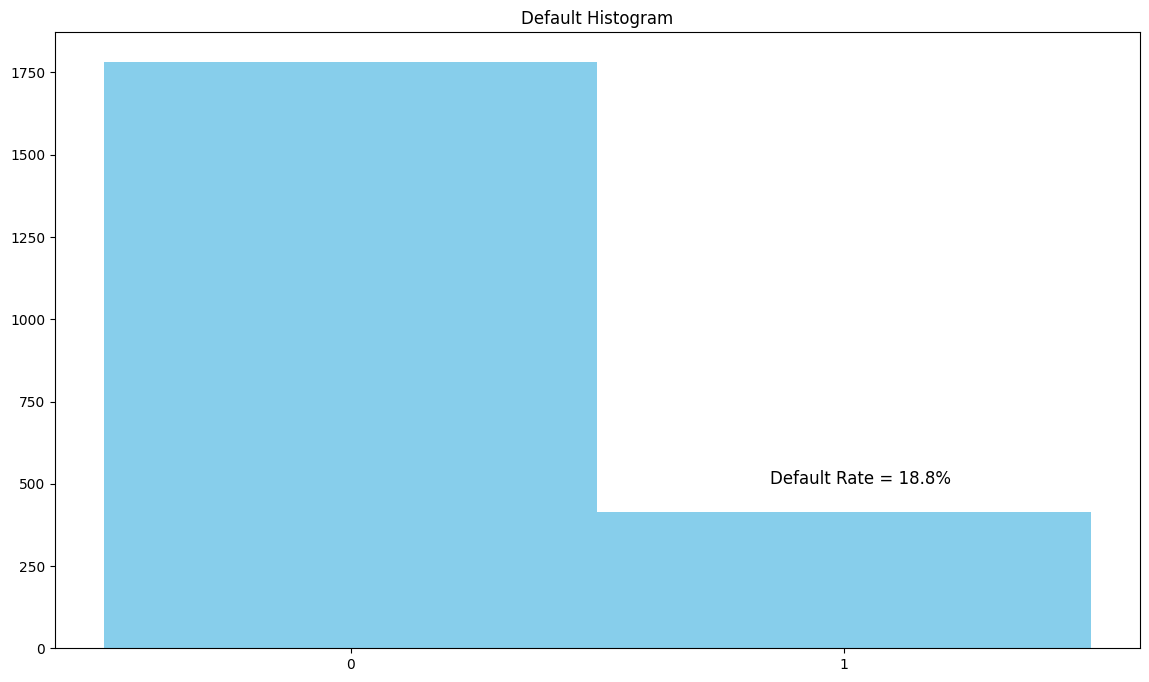

In [ ]:
plt.figure(figsize=(14, 8))
plt.hist(credit['bad'], bins=[-0.5, 0.5, 1.5], color='skyblue')
plt.xticks([0, 1])
plt.text(0.85, 500,
         'Default Rate = {:.1f}%'.format(
             (credit[credit['bad'] == 1].shape[0] / credit.shape[0]) * 100),
         fontsize = 12)
plt.title('Default Histogram')
plt.show()

# Feature Selection
By manually sifting through the dataset, we found that nearly all the categorical variables were binary. There were only 3 exceptions, 2 of which were insignificant when tested against default. For all the binary categorical variables, filtering for variables with values = [0, 1] was our classification method.

After classifying all the variables as either continuous and categorical, we were able to run an ANOVA test on the continuous variables and a Chi-Squared test on the categorical variables to test for significance in relation to default.

## ANOVA Test on Continous Variables


*   Out of the 199 continuous variables, 137 of them were significant.
*   Many of the continuous variables describe the same account feature, but are observed over different periods of time. In most cases, if one of the observations are insignificant, the entire group of variables are also insignificant.
*   In other terms, many of the continuous variables are highly correlated.
* Note: Since dependent variable is binary, we must determine explanatory variable significance by ANOVA instead of using a correlation heatmap.








In [ ]:
sel_con_vars = []

# iterate over each continous feature and determine if the feature correlation
# with the dependent variable is statistically significant
for feature in con_vars:
    group_list = credit.groupby('bad')[feature].apply(list)
    anova_results = f_oneway(*group_list)

    # if the F-test rejects the null hypothesis at the 95% confidence level
    # add it to the list of selected continous variables
    if (anova_results[1] < 0.05):
        print('P-Value: {:10.4e} | {} is RELATED with Default'.format(
            anova_results[1], feature,
        ))
        sel_con_vars.append(feature)
    else:
        print('P-Value: {:10.4e} | {} is NOT related with Default'.format(
            anova_results[1], feature,
        ))

print('Number of Continuous Variales: ', len(con_vars))
print('Number of Significant Continuous Variables: ', len(sel_con_vars))

P-Value: 2.5818e-02 | m_bba_p_d_since_validated_trade is RELATED with Default
P-Value: 3.3685e-05 | m_bba_p_default_history is RELATED with Default
P-Value: 1.1286e-01 | m_ccr_cd_cnt is NOT related with Default
P-Value: 5.4463e-02 | m_bba_p_d_since_first_seen_by_c is NOT related with Default
P-Value: 8.4152e-02 | m_bba_p_d_since_last_seen_by_cl is NOT related with Default
P-Value: 1.1140e-02 | m_bba_p_default_rate_60_days_ago is RELATED with Default
P-Value: 3.2404e-03 | m_bba_p_default_rate_61_365_d_a is RELATED with Default
P-Value: 6.8090e-03 | m_caaea_col2758 is RELATED with Default
P-Value: 8.5639e-04 | m_caaea_col5060 is RELATED with Default
P-Value: 2.0736e-03 | m_caaea_iqt9410 is RELATED with Default
P-Value: 3.8064e-03 | m_caaea_iqt9415 is RELATED with Default
P-Value: 2.1000e-03 | m_caaea_iqt9425 is RELATED with Default
P-Value: 7.1618e-03 | m_caaea_iqt9426 is RELATED with Default
P-Value: 4.9202e-01 | m_CAAS_ALL_ato_24_hours_ago is NOT related with Default
P-Value: 2.2756e-0

## Chi-Squared Test on Categorical Variables
*   Out of the 87 categorical variables, 46 were significant.
*   Of the 46 remaining variables, we noticed significant redundancies and exact collinearity issues in later analysis.
*   This step serves as a broad first filter in determining categorical variables that drive default.

In [ ]:
sel_cat_vars = []

# iterate over each categorical variable and perform a Chi-Squared test
# to determine if there is a statistically significant relationship with
# the dependent variable
for cat_var in cat_vars:
    ct = pd.crosstab(credit['bad'], credit[cat_var])
    chisqtest = chi2_contingency(ct)

    # if the Chi-Squared test rejects the null hypothesis at the 95%
    # confidence interval, add the categorical variable to the selection list
    if chisqtest[1] < 0.05:
        print('P-Value: {:10.4e} | {} is RELATED with Default'.format(
            chisqtest[1], cat_var,
        ))
        sel_cat_vars.append(cat_var)
    else:
        print('P-Value: {:10.4e} | {} is NOT related with Default'.format(
            chisqtest[1], cat_var,
        ))
print('Number of Continuous Variales: ', len(cat_vars))
print('Number of Significant Categorical Variables: ', len(sel_cat_vars))

P-Value: 3.6347e-02 | m_inq_date_of_last_activity is RELATED with Default
P-Value: 1.5050e-03 | m_CCRS_ALL_dd_7_years_ago is RELATED with Default
P-Value: 1.5415e-04 | m_ccr_days_since_last_ontime_pmt is RELATED with Default
P-Value: 2.7412e-04 | m_ccr_days_since_last_loan_pmt is RELATED with Default
P-Value: 1.0000e+00 | m_inq_net_monthly_income is NOT related with Default
P-Value: 5.7750e-02 | m_bba_p_A05 is NOT related with Default
P-Value: 3.1735e-01 | m_bba_p_A06 is NOT related with Default
P-Value: 1.3172e-02 | m_bba_p_B38 is RELATED with Default
P-Value: 5.7750e-02 | m_cbb_A05 is NOT related with Default
P-Value: 3.1735e-01 | m_cbb_A06 is NOT related with Default
P-Value: 2.2169e-03 | m_cbb_B04 is RELATED with Default
P-Value: 1.3172e-02 | m_cbb_B38 is RELATED with Default
P-Value: 2.6969e-01 | m_ccr_cd_10 is NOT related with Default
P-Value: 2.6776e-03 | m_ccr_cd_29 is RELATED with Default
P-Value: 2.3770e-01 | m_ccr_cd_32 is NOT related with Default
P-Value: 1.9455e-06 | m_ccr

In [ ]:
# check for significance on manually identified categorical variables
test_vars = ['m_ccrea_aua6280', 'm_ccrea_bcc6160', 'm_ccrea_iln6230']
for cat_var in test_vars:
    ct = pd.crosstab(credit['bad'], credit[cat_var])
    chisqtest = chi2_contingency(ct)

    # if the Chi-Squared test rejects the null hypothesis at the 95%
    # confidence interval, add the categorical variable to the selection list
    if chisqtest[1] < 0.05:
        print('P-Value: {:10.4e} | {} is RELATED with Default'.format(
            chisqtest[1], cat_var,
        ))
    else:
        print('P-Value: {:10.4e} | {} is NOT related with Default'.format(
            chisqtest[1], cat_var,
        ))

P-Value: 6.7063e-04 | m_ccrea_aua6280 is RELATED with Default
P-Value: 9.1164e-02 | m_ccrea_bcc6160 is NOT related with Default
P-Value: 5.0570e-02 | m_ccrea_iln6230 is NOT related with Default


In [ ]:
# @title Add Categorical Variable from Manual Variable Verification
# correct feature selection lists

# remove categorical variables from continuous variable selection
for i in range(len(test_vars)):
    if test_vars[i] in sel_con_vars:
        sel_con_vars.remove(test_vars[i])

# add important variable to categorical variable selection
if 'm_ccrea_aua6280' in credit.columns:
    test_df = pd.get_dummies(credit[test_vars[0]]).astype(int)
    test_names = []
    for i in range(len(test_df.columns)):
        test_names.append(test_vars[0] + '_' + str(i))
    test_df.columns = test_names

    credit = pd.concat([credit, test_df], axis=1)
    credit_factors = pd.concat([credit_factors, test_df], axis=1)
    credit = credit.drop('m_ccrea_aua6280', axis=1)
    credit_factors = credit_factors.drop('m_ccrea_aua6280', axis=1)

    for name in test_names:
        if name not in sel_cat_vars:
            sel_cat_vars.append(name)

## Preliminary K-Means Clustering on Selected Features
* ✅ Why K-Means?
    * works well for data where the number of clusters is known/can be estimated
    * works well for data that that does not exhibit a dependent, hierarchial structure but has distinct, independent groups
* ❌ Hierarchical Clustering
    * works better for data that can be structured in a tree-like hierarchy
    * especially used for data where clusters tend to **nest**
* ❌ Expectation-Maximization
    * assumes underlying data is follows a Gaussian distribution (normal)

Here, we perform 2 K-Means clusterings of the data. The *first* is on the raw data without filtering, transformations, or corrections. This serves as a baseline example of how poor clustering performes on raw data that has not underwent any level of pre-processing. The *second* is on statistically significant explanatory variables with the continous variables standardized. While this variable set does not include processing to correct for multicollinearity and noise caused by high dimentionality, we note the **significant** improvement of the K-Means clustering performance with applied high-level filtering and standardization techniques alone.

In [ ]:
# @title K-Means Clustering Without **Any** Data Filtering or Corrections
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(credit_factors)

klabels = pd.Series(kmeans.labels_)
klabels.name = 'cluster'
credit_labeled = pd.concat([credit[['app_id', 'bad']], klabels], axis=1)

K = range(0, max(credit_labeled['cluster']) + 1)
clusters = pd.DataFrame(columns=['Size','Default Rate'])
for i in K:
  cluster = credit_labeled[credit_labeled['cluster']==i]
  clusters.loc[i, 'Size'] = len(cluster)
  clusters.loc[i, 'Default Rate'] = cluster['bad'].sum() / len(cluster)

clusters.sort_values(by='Default Rate')

Size Default Rate
9   92     0.076087
3   34     0.088235
1   43     0.139535
8  303     0.158416
5   43     0.186047
6  904     0.188053
7   90     0.188889
0  407      0.19656
2  122     0.237705
4  158      0.28481

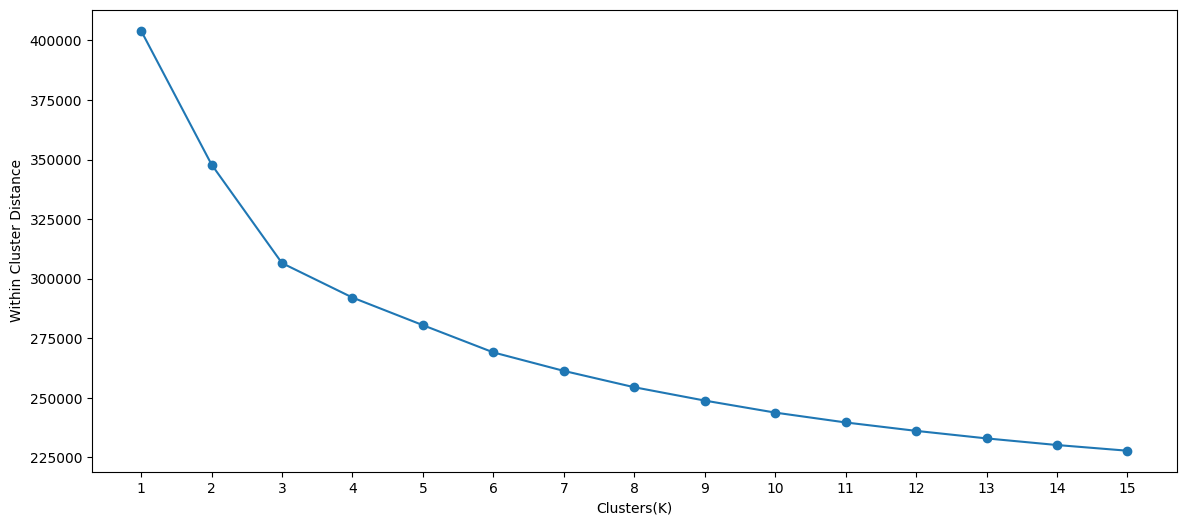

In [ ]:
# @title Scree Plot
# standardize data
scaler = StandardScaler()
credit_factors_stan = pd.DataFrame(
    scaler.fit_transform(credit_factors[sel_con_vars + sel_cat_vars])
)
credit_factors_stan.columns = credit_factors[
    sel_con_vars + sel_cat_vars
].columns
plot_kscree(credit_factors_stan)

In [ ]:
# @title K-Means Clustering with Significant Variables and Standardization
# perform K-Means clustering analysis using standardized significant variables
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(credit_factors_stan)

klabels = pd.Series(kmeans.labels_)
klabels.name = 'cluster'
credit_labeled = pd.concat([credit[['app_id', 'bad']], klabels], axis=1)

K = range(0, max(credit_labeled['cluster']) + 1)
clusters = pd.DataFrame(columns=['Size', 'Default Rate'])
for i in K:
  cluster = credit_labeled[credit_labeled['cluster']==i]
  clusters.loc[i, 'Size'] = len(cluster)
  clusters.loc[i, 'Default Rate'] = cluster['bad'].sum() / len(cluster)

clusters.sort_values(by='Default Rate')

Size Default Rate
8  207     0.130435
9  360     0.144444
5  268     0.145522
1  263     0.148289
4  137     0.160584
7  126     0.198413
6  205     0.214634
2  171      0.22807
3  141     0.262411
0  318     0.279874

# Collinearity & Correlation Analysis
After distinguishing the variables related to default from variables that were not, addressing colinearity in variables was next. Colinearity was diagnosed using correlation heatmaps.

We found that in many of the variables, a high correlation (>= 0.7) was a good indicator for redundancy in the dataset. Any pairs/groups of variables with nearly perfect colinearity (correlation >= 0.95) had all but one variable dropped at our discretion. To create more digestable visualizations of these relationships, we first filtered the initial correlation matrix to variables with high correlation.

Next, we performed K-Means clustering on the filtered correlation matrix; this resulted in clusters of variables with similar correlation patterns. Although not perfect, the clusters served as a great starting point for grouping the variables for dimensionality reduction.

## Continous Variables

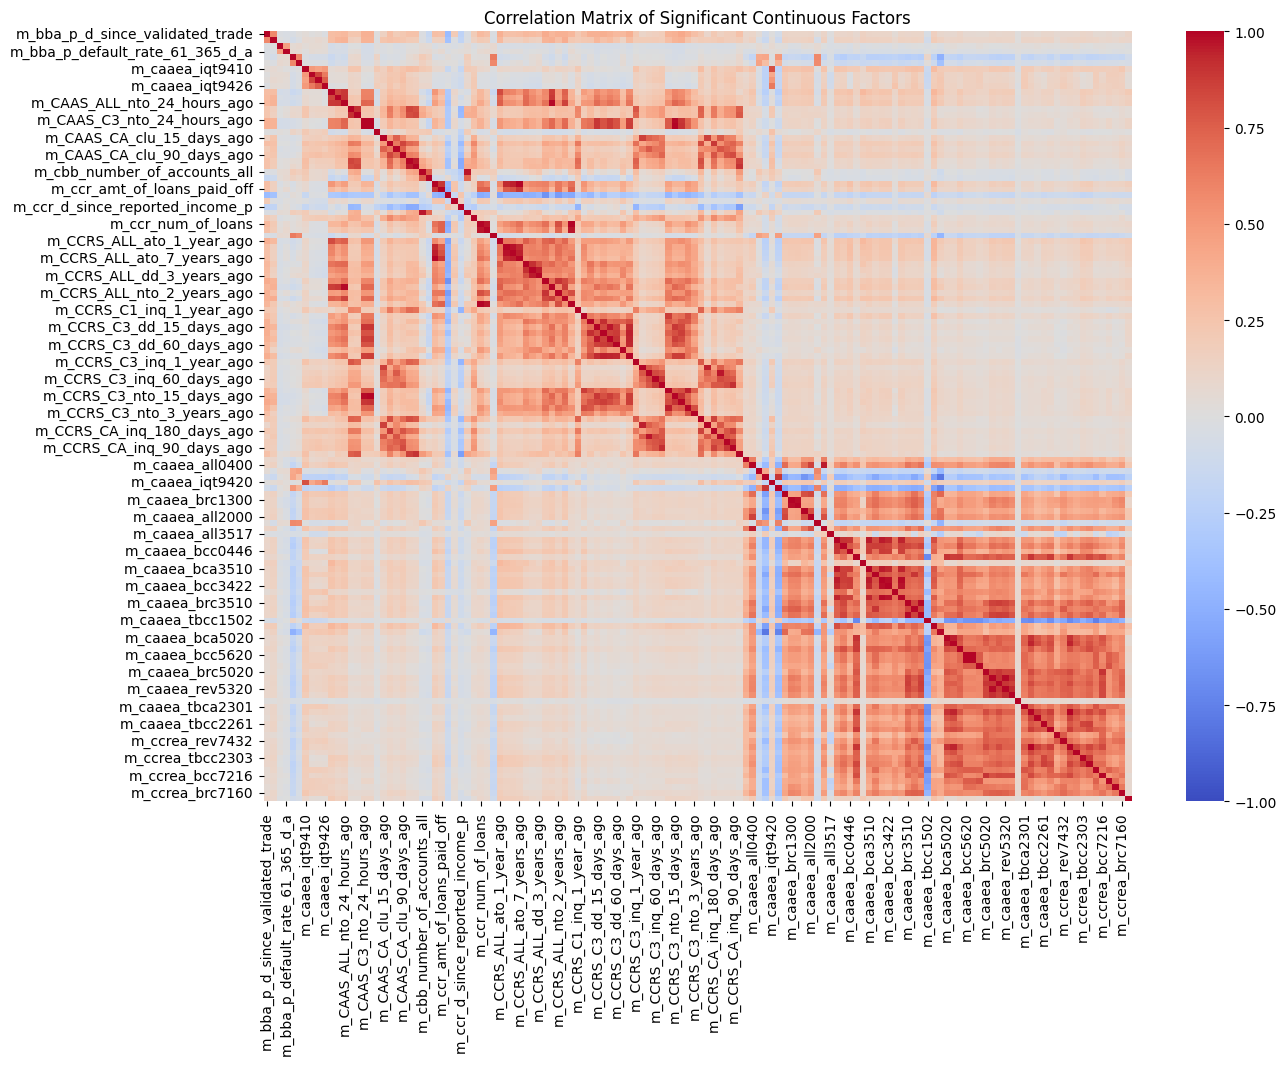

In [ ]:
# @title Correlation Matrix of Significant Continous Factors

sel_con_corr = credit_factors[sel_con_vars].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(sel_con_corr, cmap='coolwarm', annot=False, fmt=".2f",
            vmin=-1, vmax=1)
plt.title('Correlation Matrix of Significant Continuous Factors')
plt.show()

Correlated Continous Variables:  115


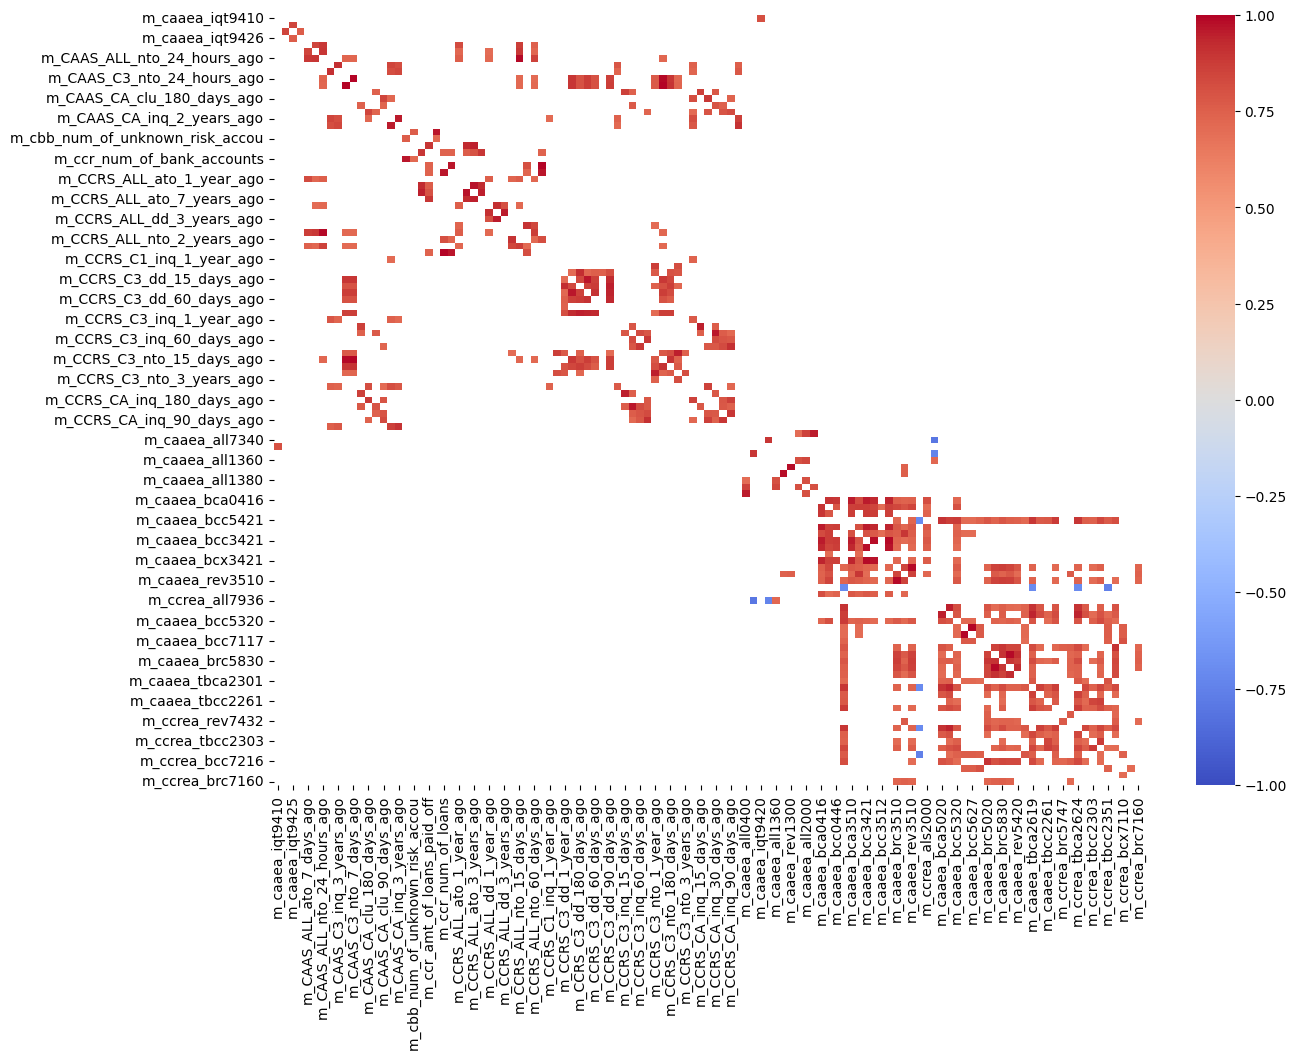

In [ ]:
# @title Filter Matrix for Continous Variables Correlated > 70%
filter_sel_con_corr = sel_con_corr.mask(
    (np.abs(sel_con_corr) <= 0.7) | (sel_con_corr == 1)
)
filter_sel_con_corr = filter_sel_con_corr.dropna(
    axis=0, how='all').dropna(axis=1, how='all')
plt.figure(figsize=(14, 10))
sns.heatmap(filter_sel_con_corr, cmap='coolwarm', fmt='.2f',
            vmin=-1, vmax=1)
print('Correlated Continous Variables: ', filter_sel_con_corr.shape[1])
plt.show()

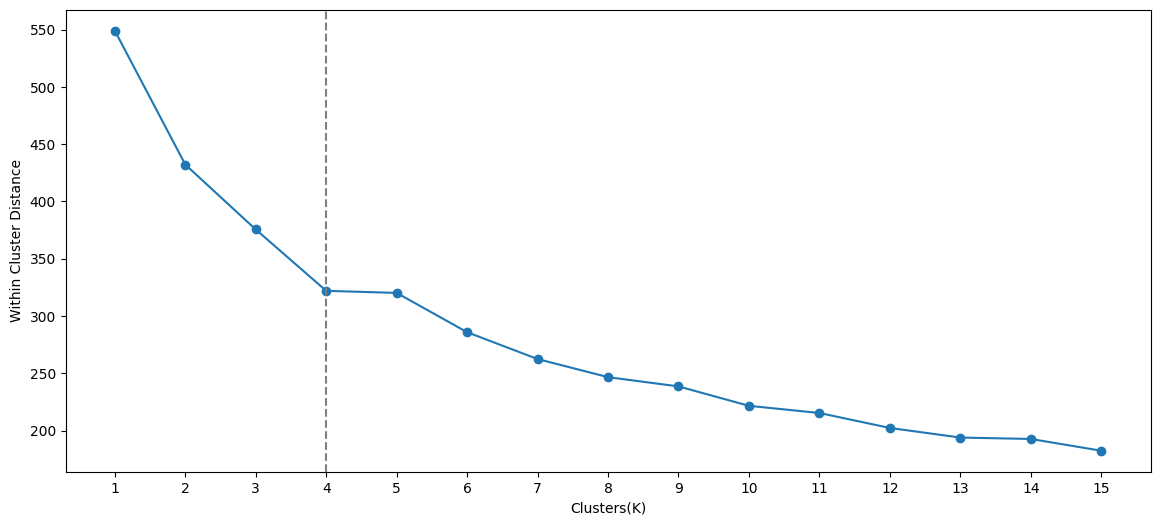

In [ ]:
# @title K-Means Scree Plot over Correlated (>70%) Continous Variables
plot_kscree(filter_sel_con_corr.fillna(0).values, vline=4)

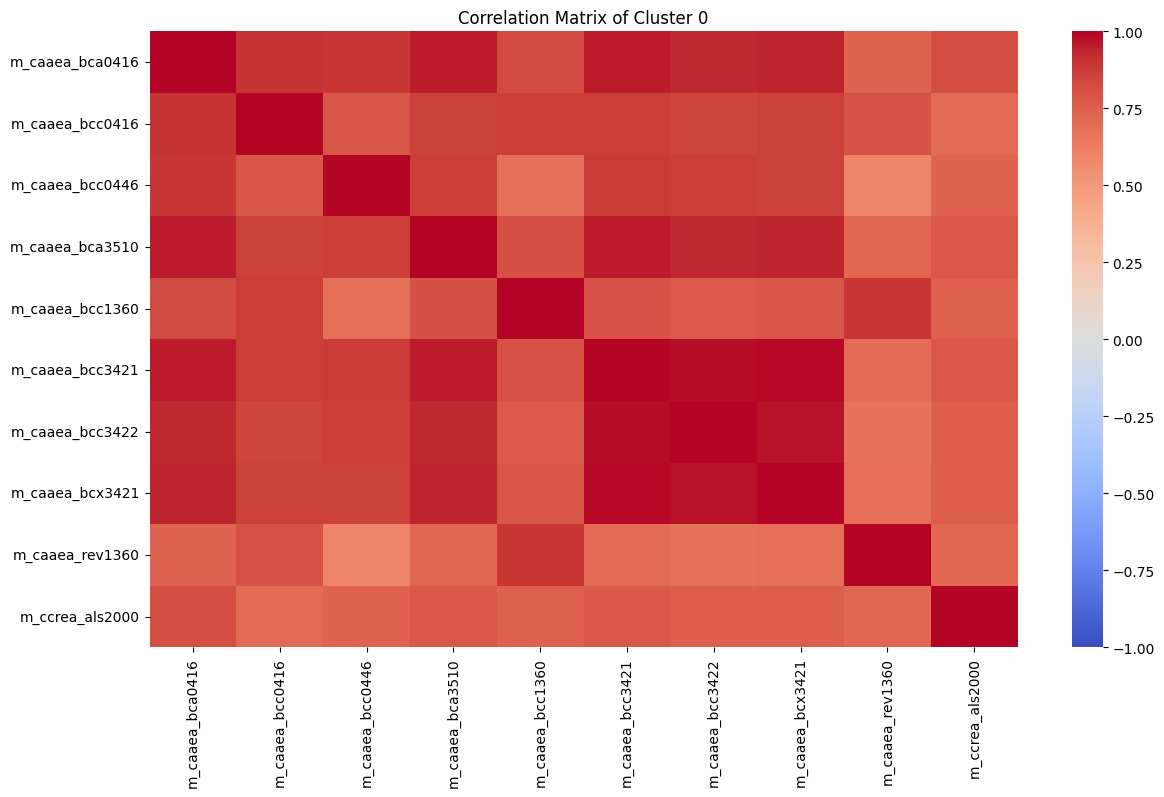

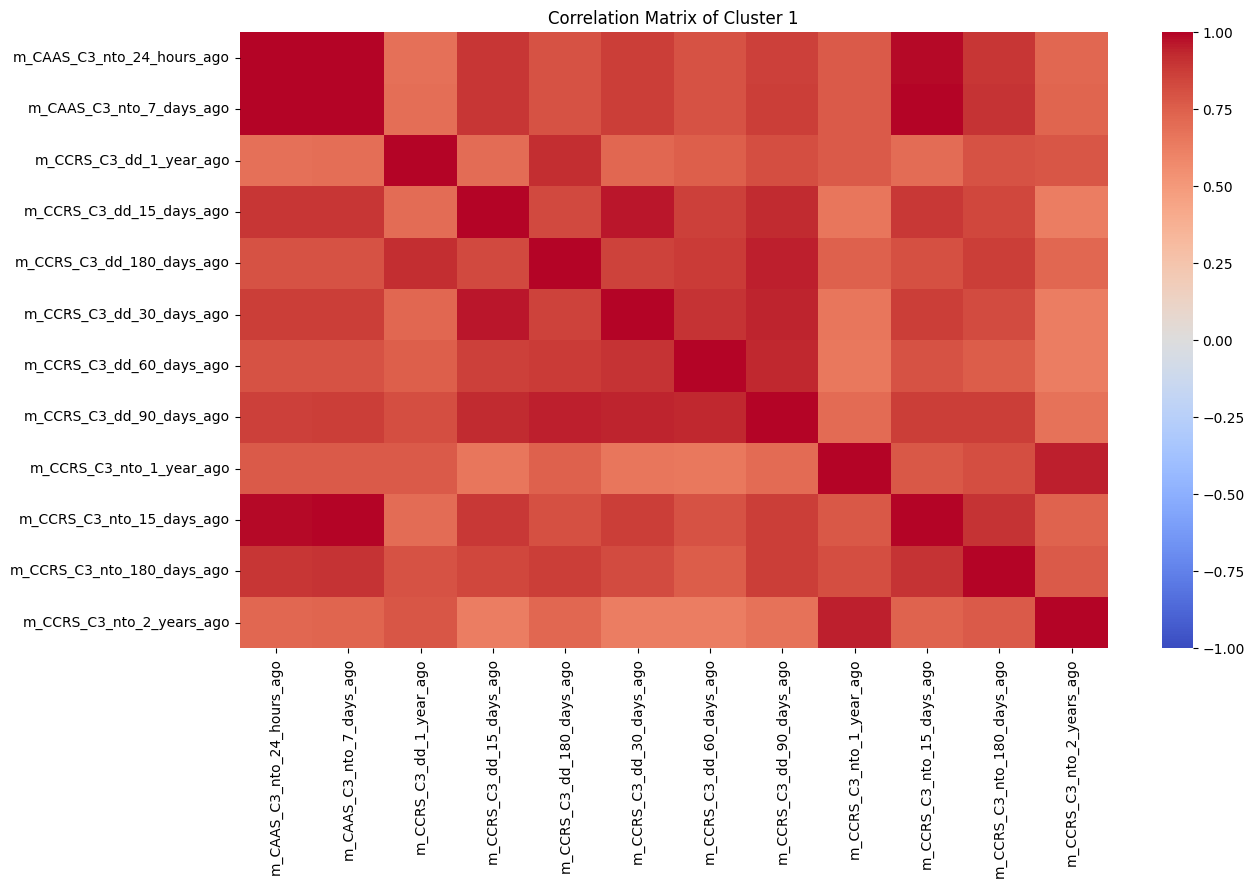

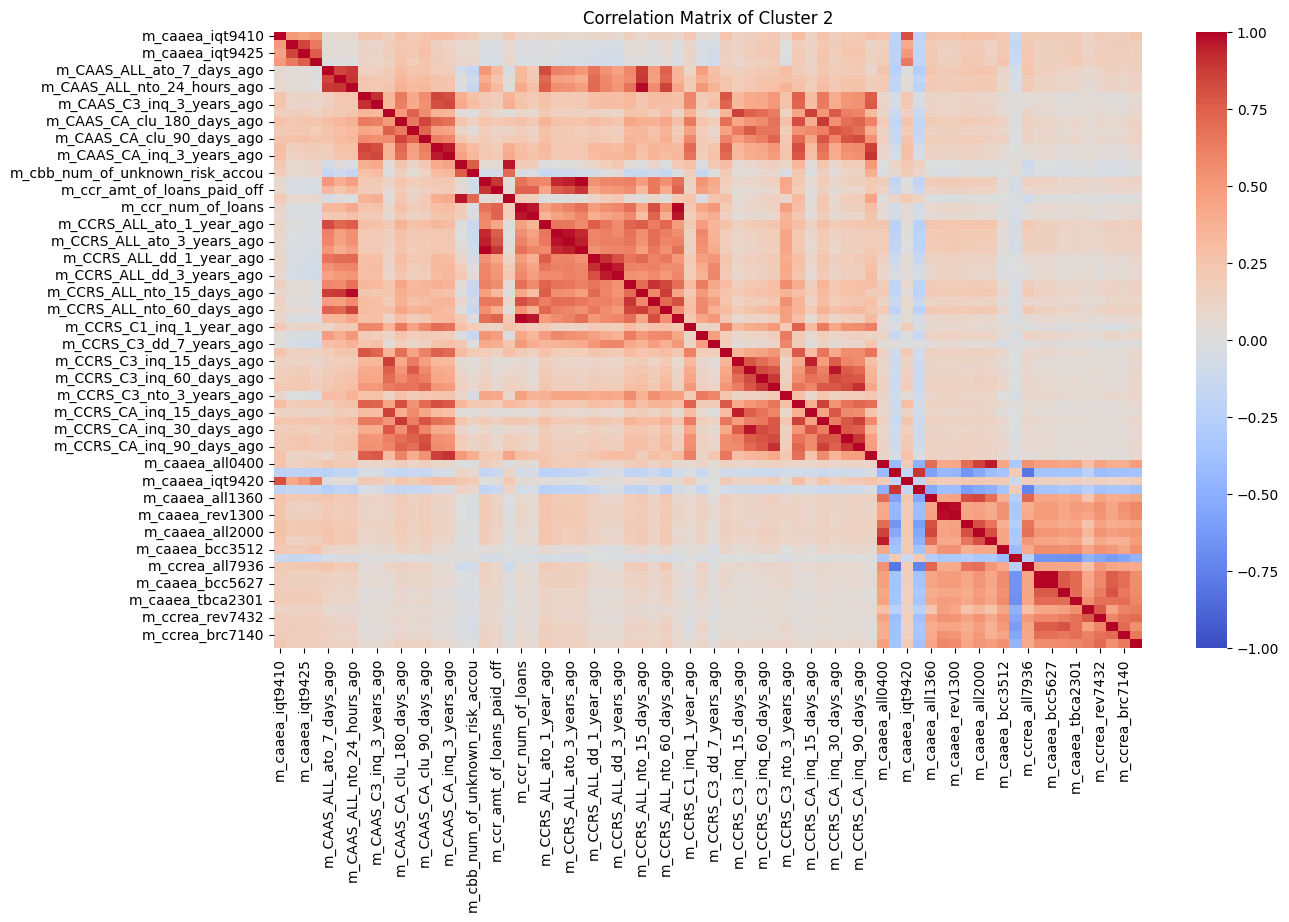

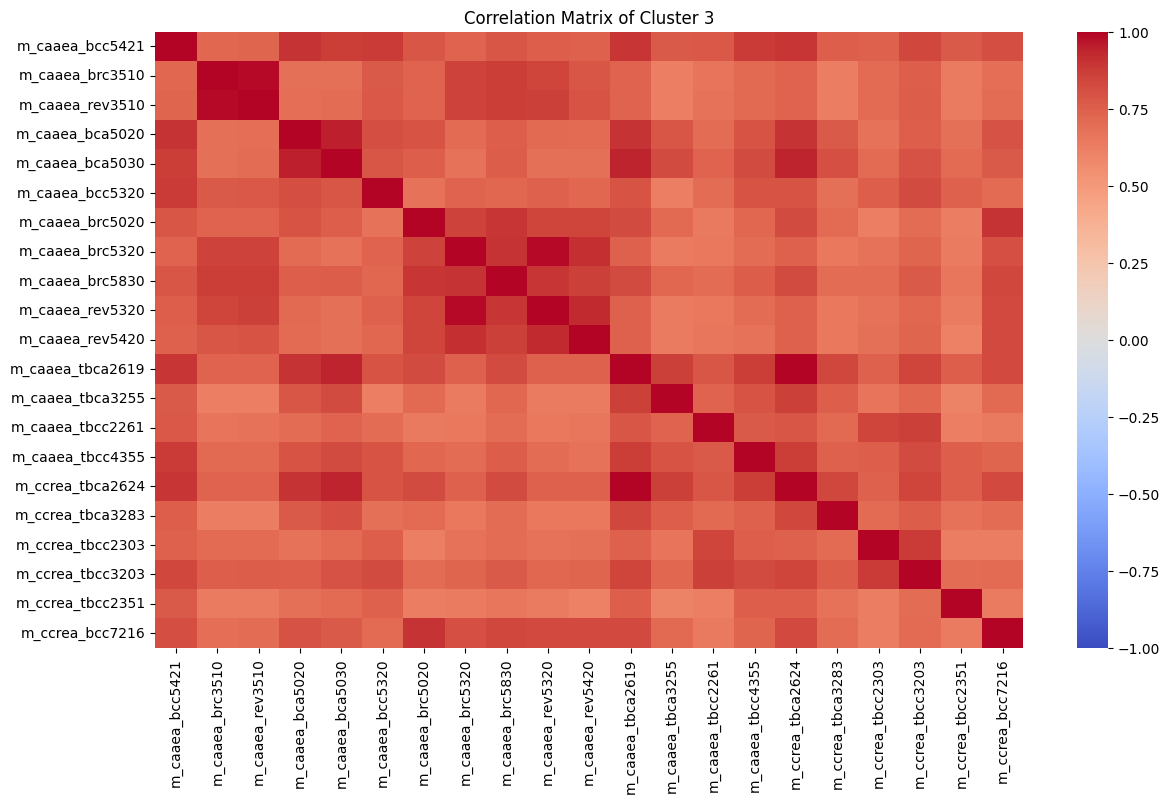

In [ ]:
# @title K-Means Clustering on the Correlated (>70%) Continuous Variables
model = KMeans(n_clusters=4, random_state=42, n_init=10)
model.fit(filter_sel_con_corr.fillna(0).values)
klabels = pd.DataFrame([filter_sel_con_corr.columns, model.labels_]).T
klabels.columns = ['Variable', 'Cluster']
#pd.DataFrame(klabels).to_csv(dir+'klabels_over70.csv')
for i in range(0, max(klabels['Cluster']) + 1):
    plot_kcorr(klabels, i)
    print('\n')

Number of Variables in Cluster 2: 72


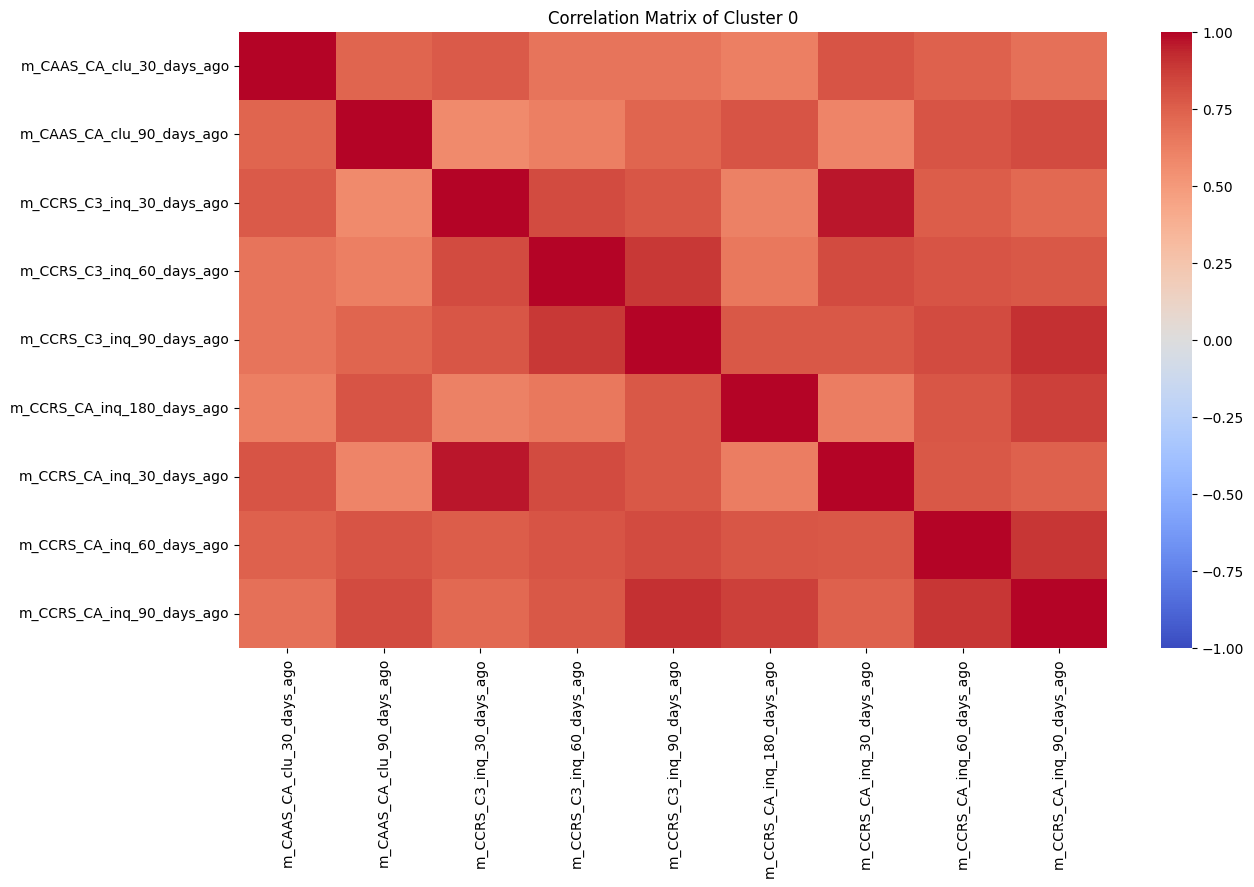

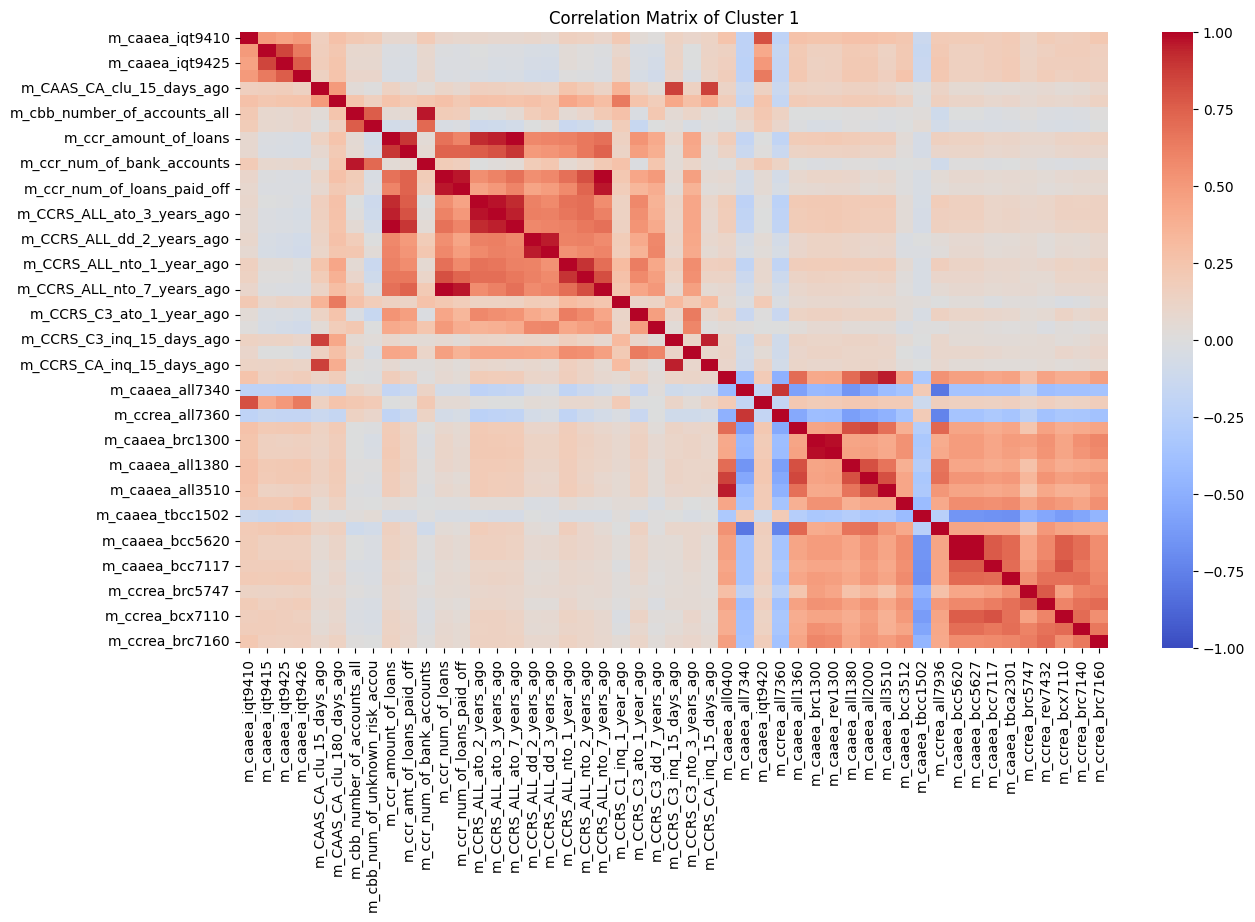

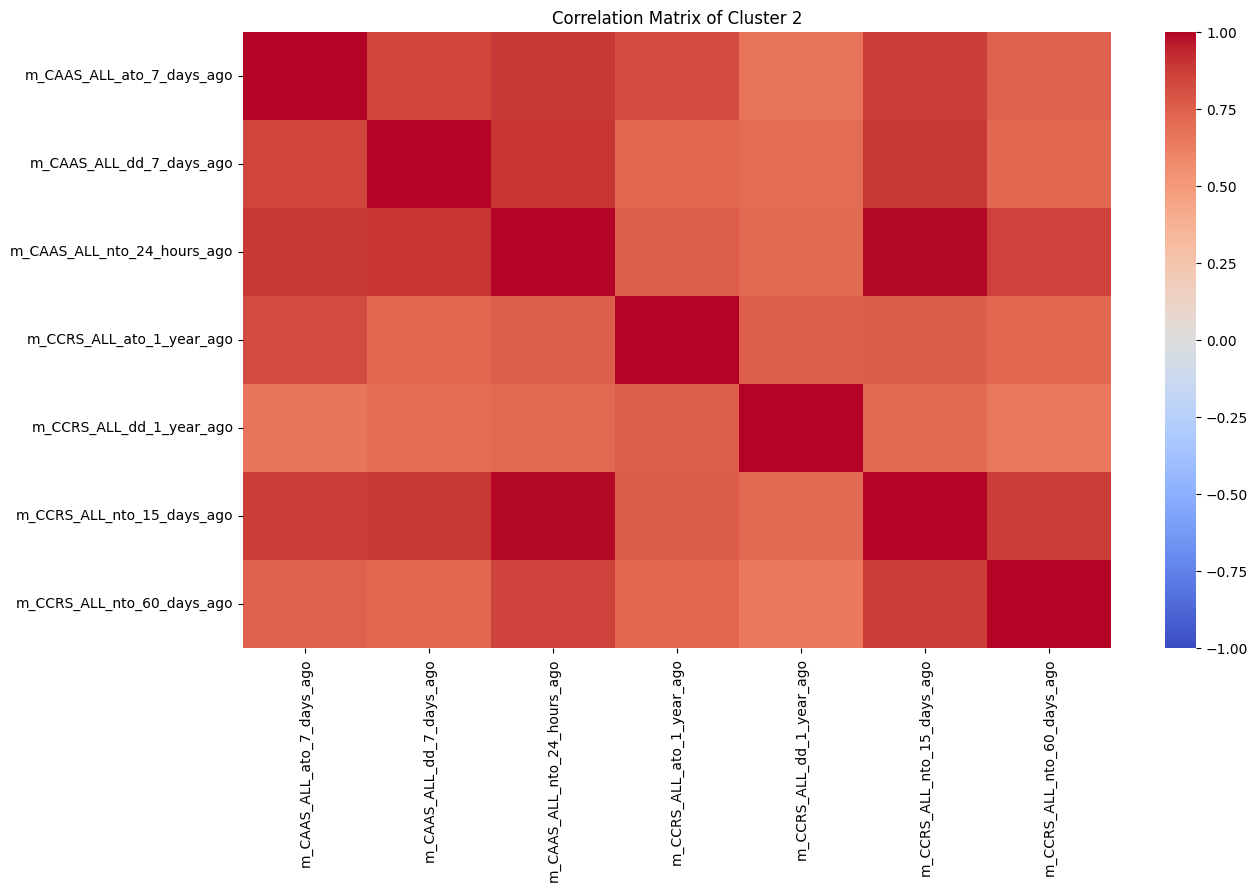

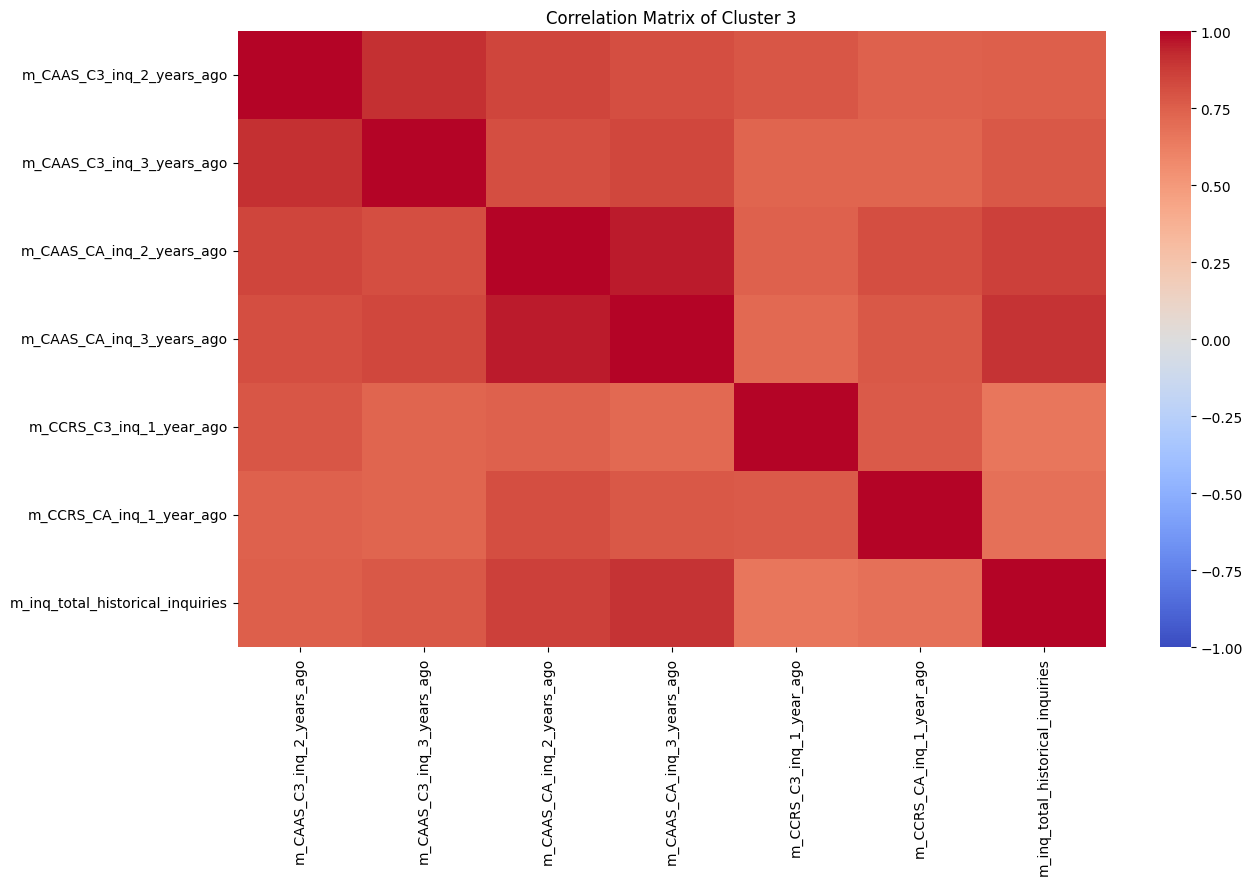

In [ ]:
 # @title K-Means Clustering on Cluster 2

print('Number of Variables in Cluster 2: {:.0f}'.format(
    len(klabels[klabels['Cluster'] == 2]['Variable'])))

model = KMeans(n_clusters=4, random_state=42, n_init=10)
model.fit(filter_sel_con_corr.loc[
    klabels[klabels['Cluster'] == 2]['Variable'],
    klabels[klabels['Cluster'] == 2]['Variable']].fillna(0).values)
klabels2 = pd.DataFrame([
    filter_sel_con_corr.loc[
        klabels[klabels['Cluster'] == 2]['Variable'],
        klabels[klabels['Cluster'] == 2]['Variable']].columns,
    model.labels_
    ]).T
klabels2.columns = ['Variable', 'Cluster']

# pd.DataFrame(klabels2).to_csv(dir+'klabels2_over70_.csv')

for i in range(0, max(klabels2['Cluster']) + 1):
    plot_kcorr(klabels2, i)
    print('\n')

## Categorical Variables
**Cramér's V Correlation Analysis of Categorical Variables** [("Solving Statistical Puzzles with Cramer’s V" by Dr. Walid Soula)](https://medium.com/illumination/cramers-v-1a5b1953094d)
*   Cramér's V coefficient is analogous to the Pearson correlation coefficient
    *   we convert the categorical variables into cross-tabulation pairs
    *   effectively this represents a categorical variable as continuous
    *   Cramér's V formula then interprets the frequency pairs as correlation

*   correlation analysis allowed us to dropp obviously exact collinear variables
*   clustering allowed us to process variable descriptions to make inferrences on potential MCA groups

Correlated Categorical Variables:  50


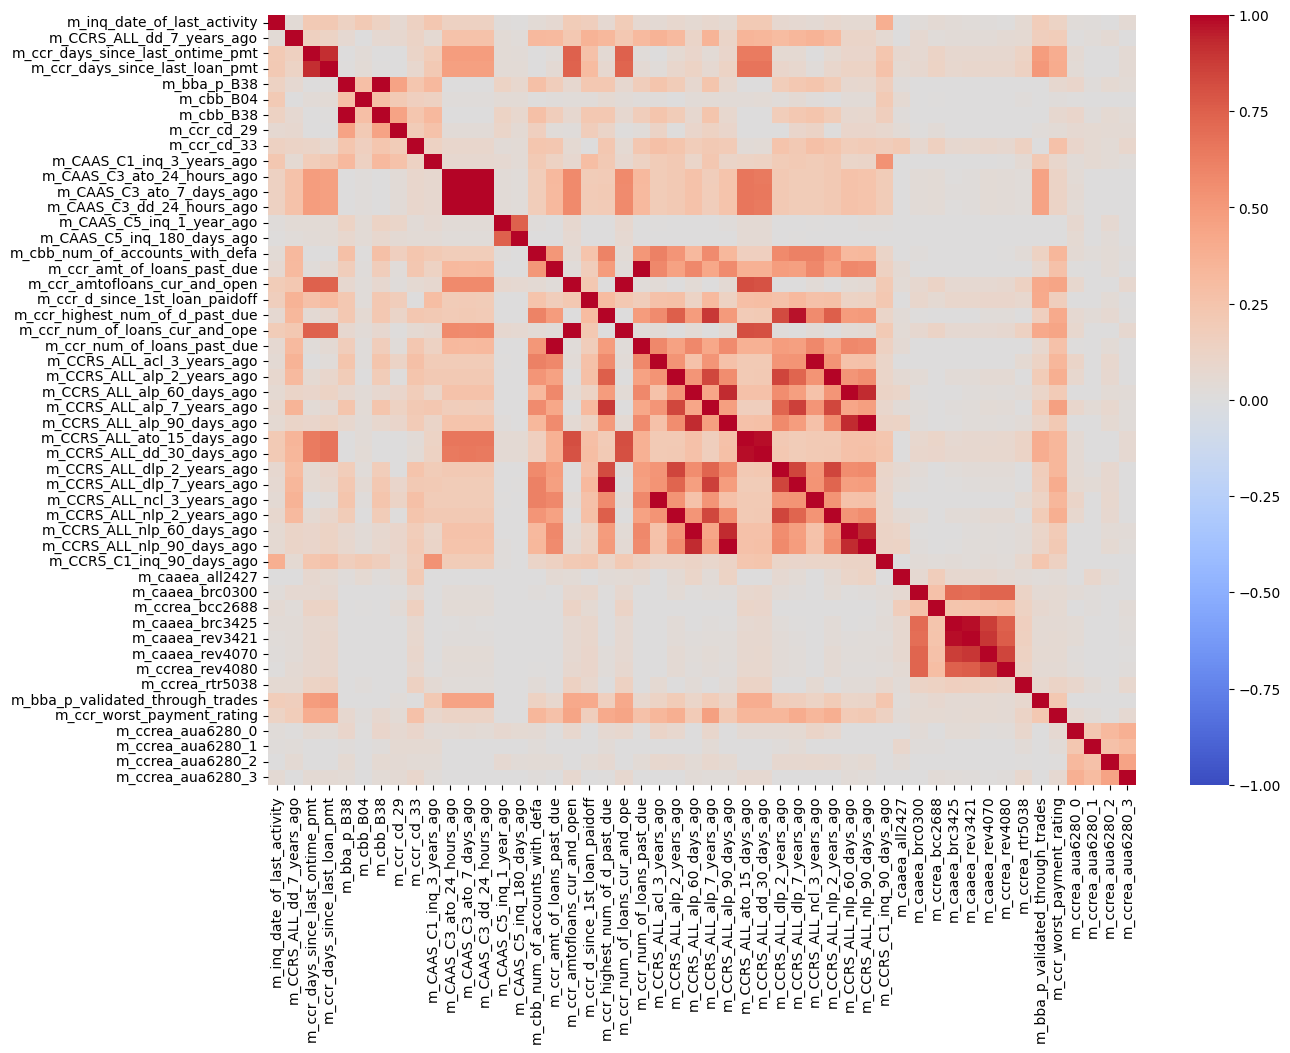

In [ ]:
# @title Cramér's V Correlation Matrix

v_matrix = cramers_v_matrix(credit_factors[sel_cat_vars])

fig = plt.figure(figsize=(14, 10))
sns.heatmap(v_matrix, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
print('Correlated Categorical Variables: ', v_matrix.shape[1])
plt.show()

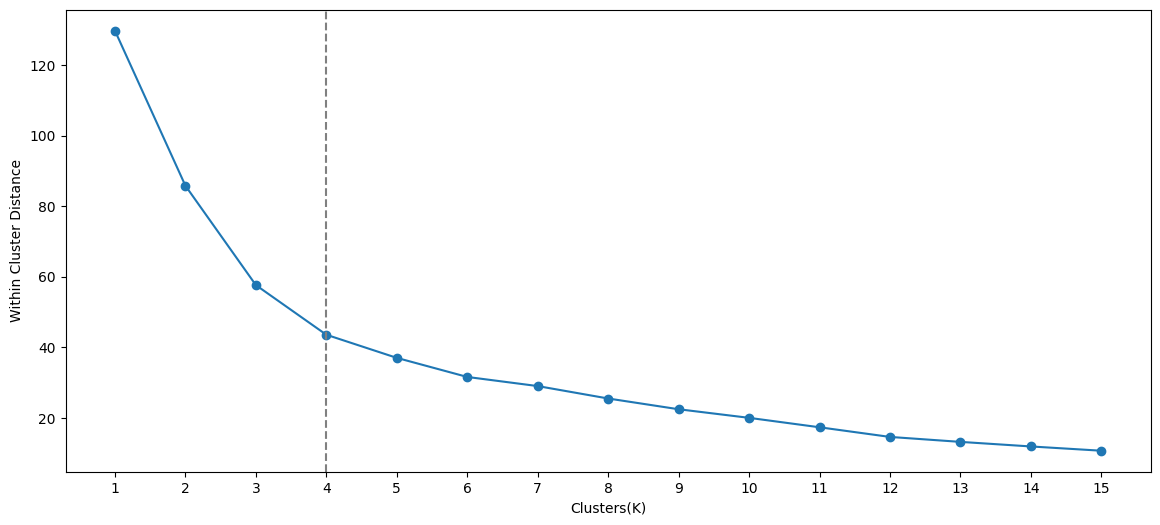

In [ ]:
# @title Plot K-Means Scree Plot on Cramér's V Matrix
plot_kscree(v_matrix.values, vline=4)

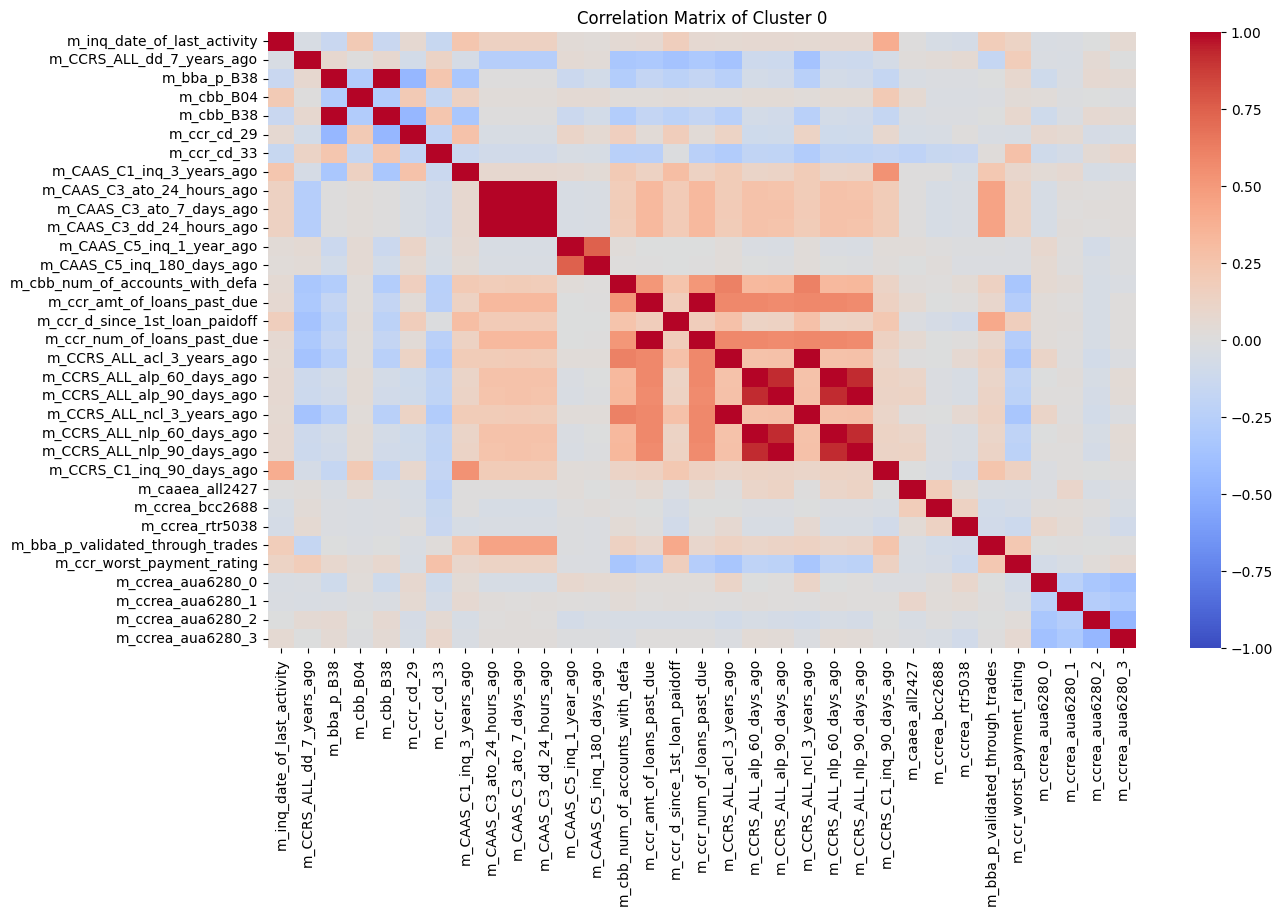

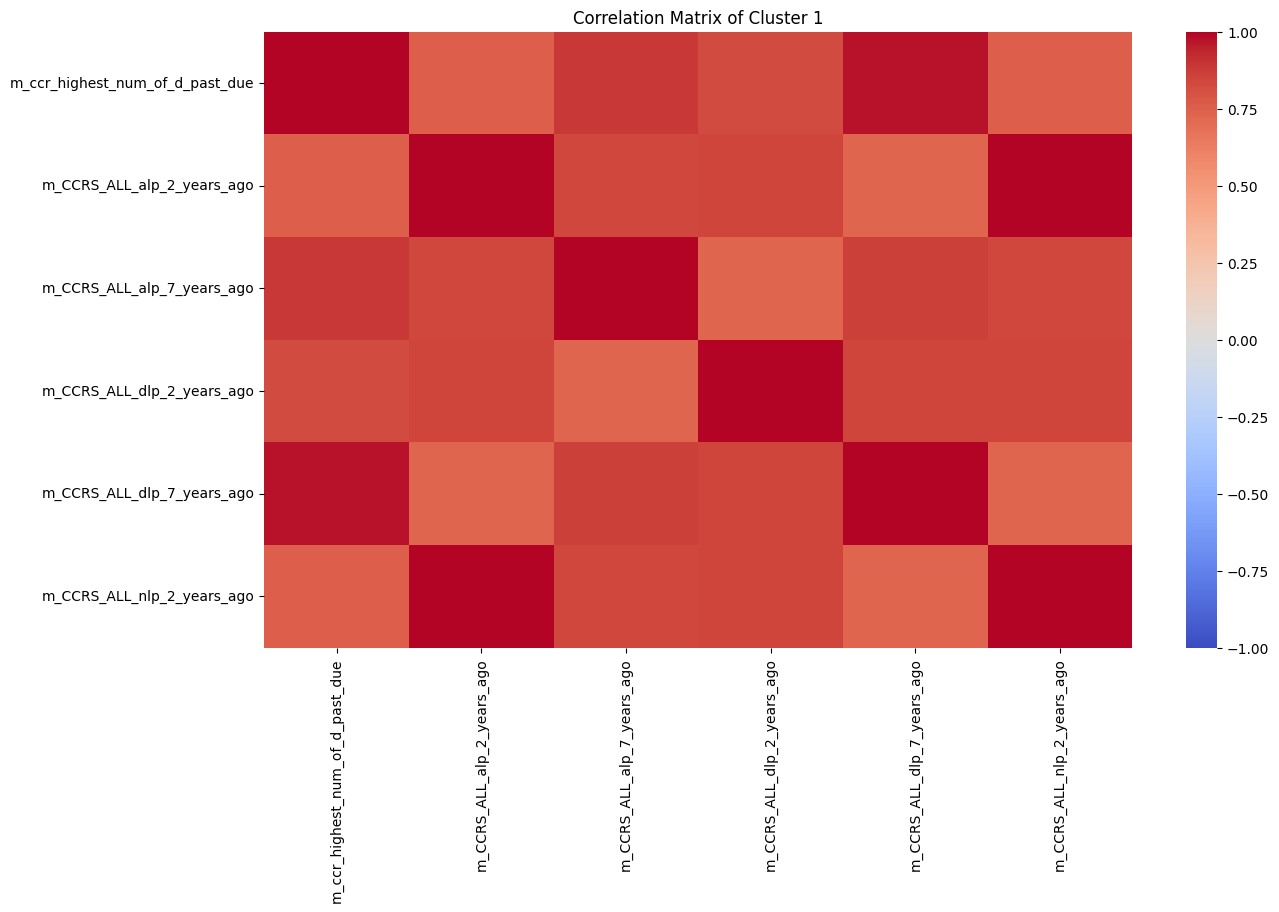

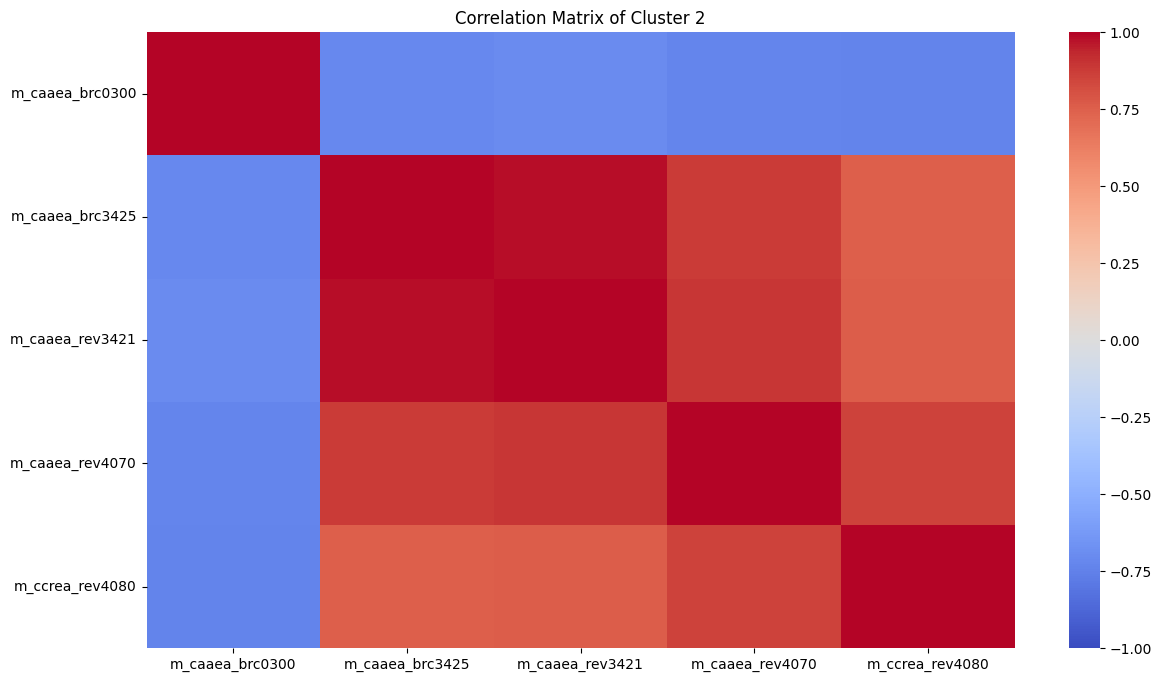

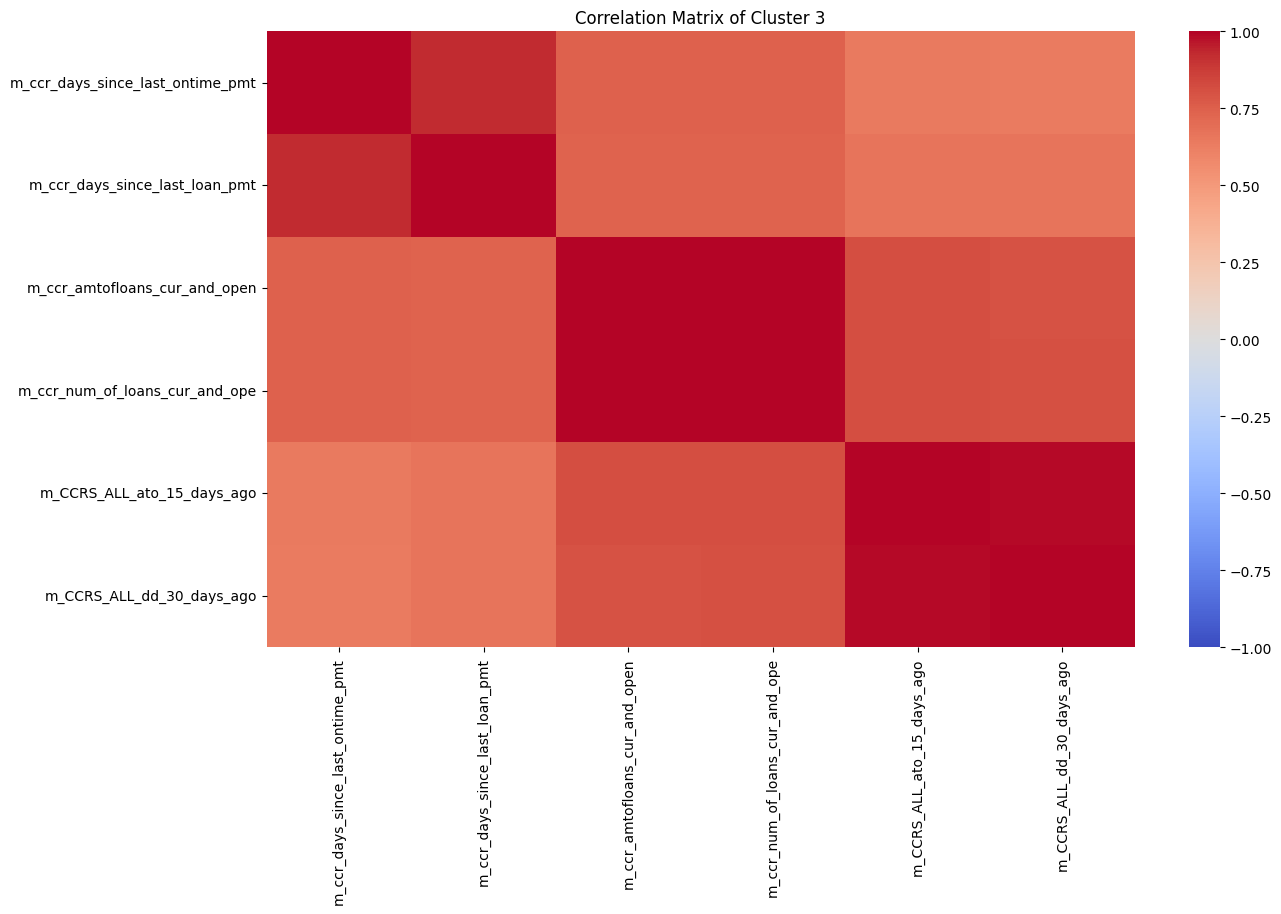

In [ ]:
# @title Filter for Cramér Correlations >70% and Perform K-Means Clustering

filter_sel_cat_corr = v_matrix.mask(
    (np.abs(v_matrix) <= 0.7) | (v_matrix == 1)
)

model = KMeans(n_clusters=4, random_state=42, n_init=10)
model.fit(filter_sel_cat_corr.fillna(0).values)
klabels = pd.DataFrame([filter_sel_cat_corr.fillna(0).columns, model.labels_]).T
klabels.columns = ['Variable', 'Cluster']

# pd.DataFrame(klabels).to_csv(dir + 'klabels_cat_over70.csv')

for i in range(0, max(klabels['Cluster']) + 1):
    plot_kcorr(klabels, i)
    print('\n')

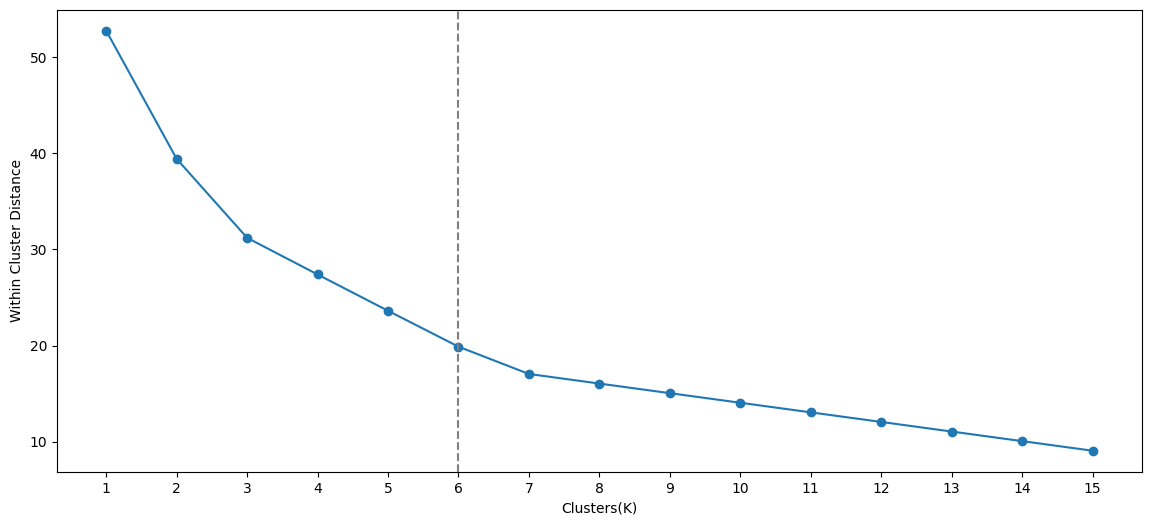

In [ ]:
# @title Investigate Cluster 0
plot_kscree(filter_sel_cat_corr.loc[
    klabels[klabels['Cluster'] == 0]['Variable'],
    klabels[klabels['Cluster'] == 0]['Variable']].fillna(0).values,
            vline=6)

Number of Variables in Cluster 1: 33


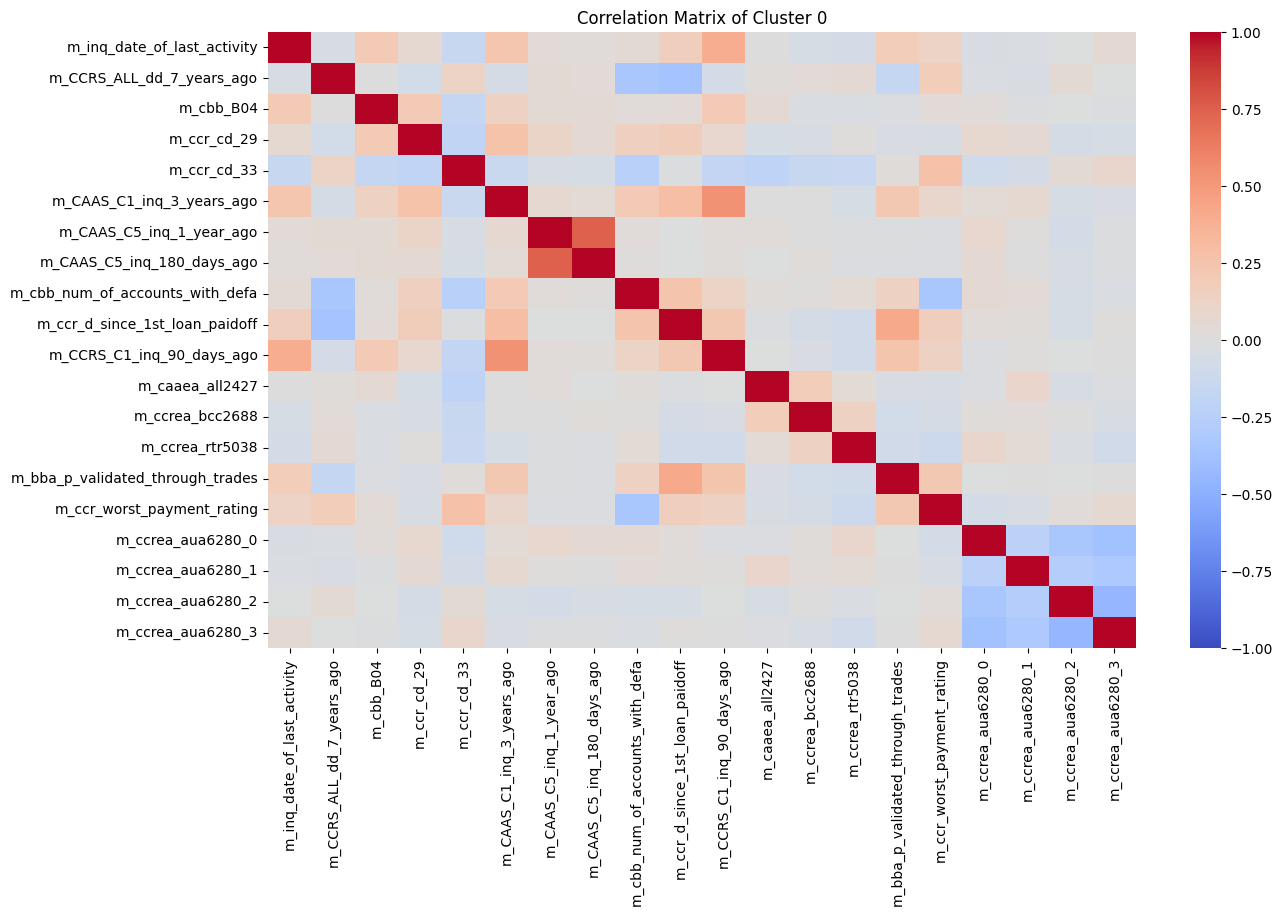

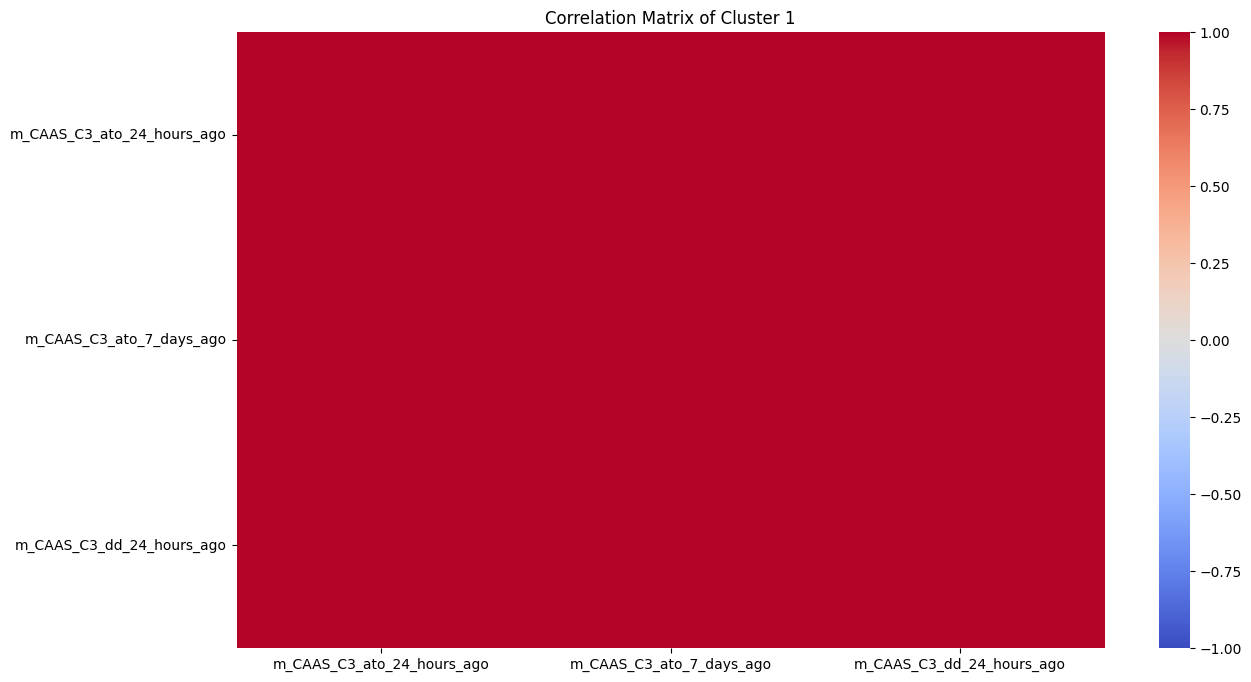

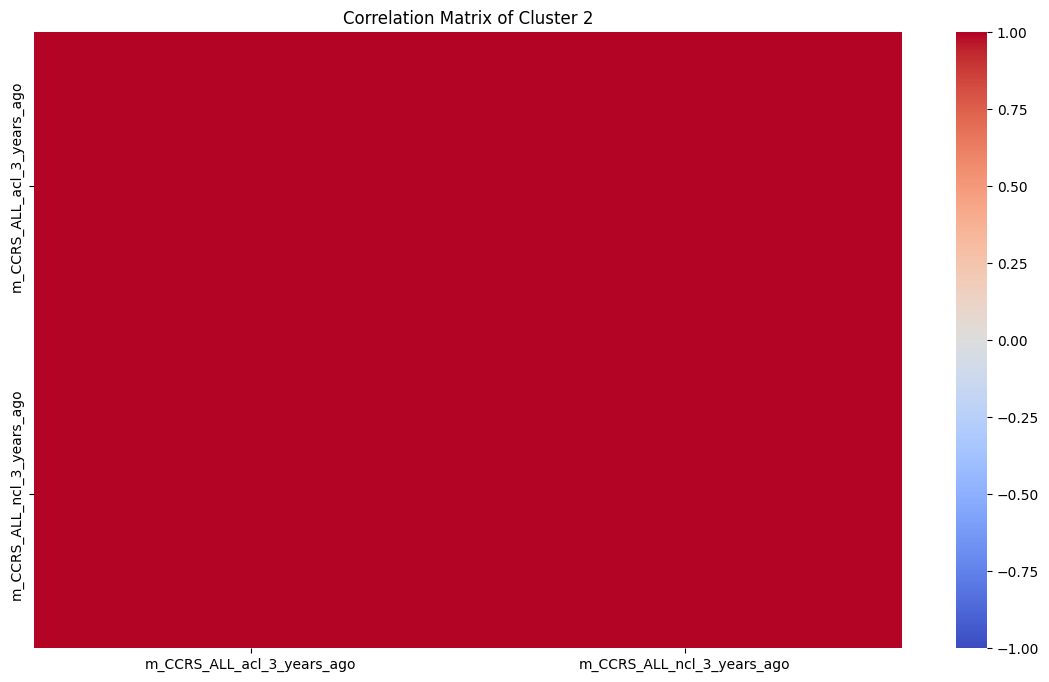

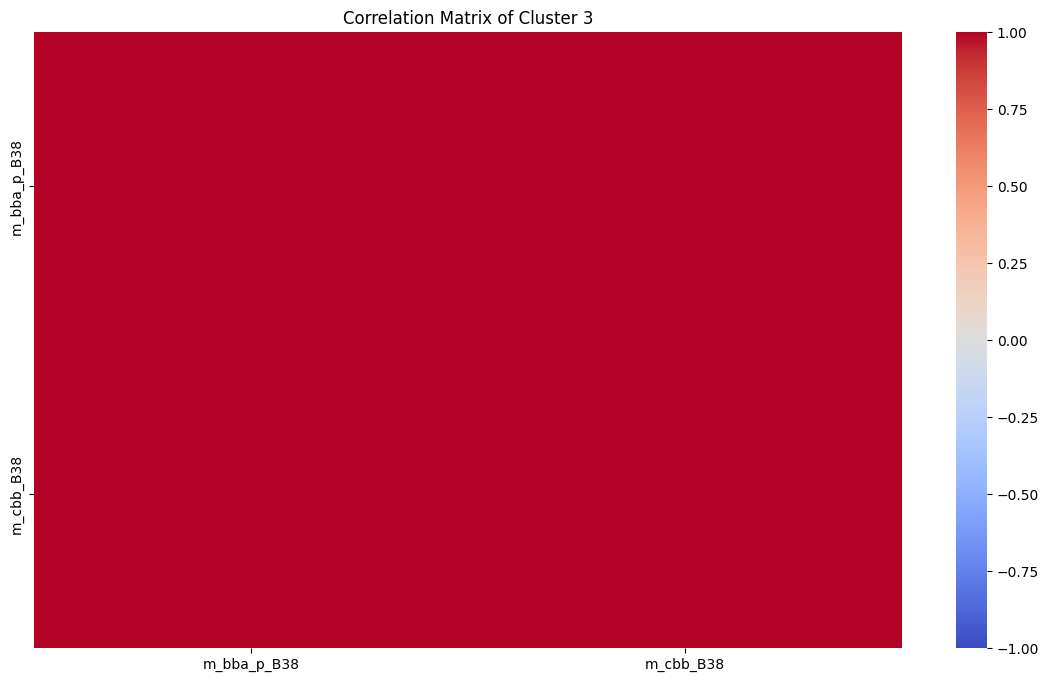

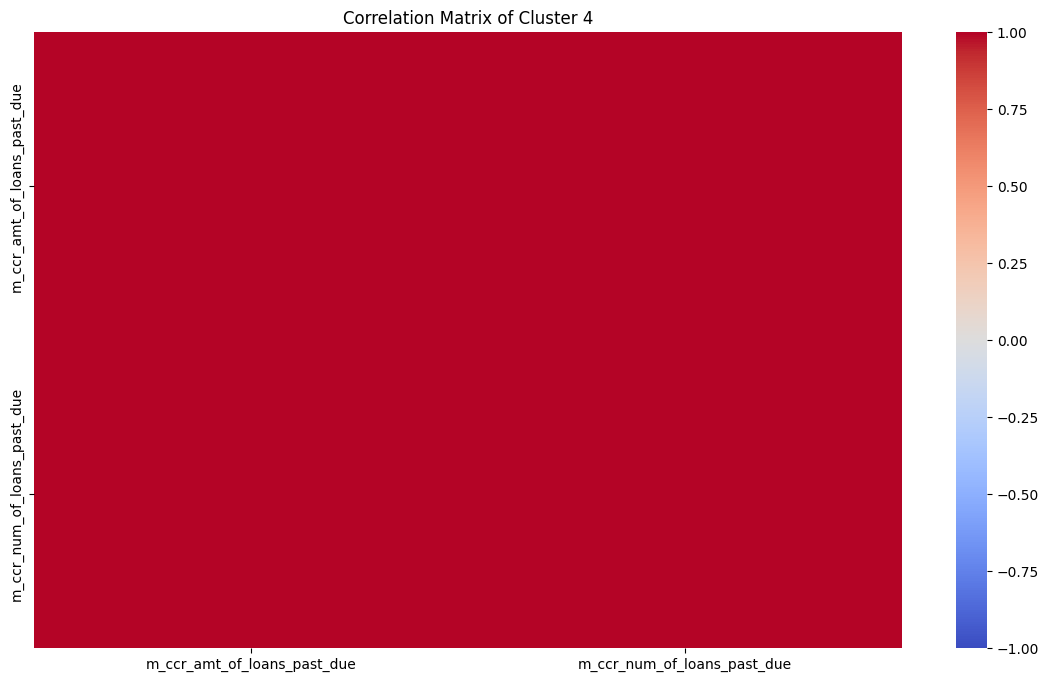

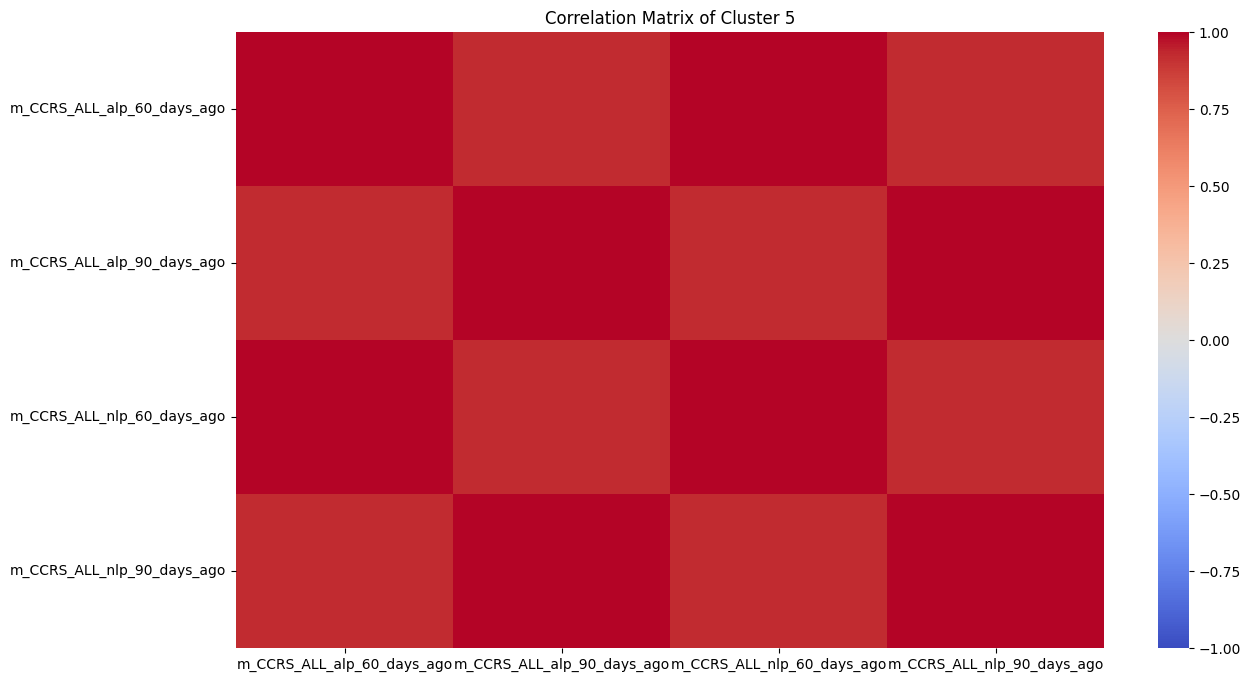

In [ ]:
# @title Perform K-Means Clustering on Cluster 1

print('Number of Variables in Cluster 1: {:.0f}'.format(
    len(klabels[klabels['Cluster'] == 0]['Variable'])))

model = KMeans(n_clusters=6, random_state=42, n_init=10)
model.fit(filter_sel_cat_corr.loc[
    klabels[klabels['Cluster'] == 0]['Variable'],
    klabels[klabels['Cluster'] == 0]['Variable']].fillna(0).values)
klabels2 = pd.DataFrame([
    filter_sel_cat_corr.loc[
        klabels[klabels['Cluster'] == 0]['Variable'],
        klabels[klabels['Cluster'] == 0]['Variable']].columns,
    model.labels_
    ]).T
klabels2.columns = ['Variable', 'Cluster']

# pd.DataFrame(klabels2).to_csv(dir + 'klabels2_cat_over70.csv')

for i in range(0, max(klabels2['Cluster']) + 1):
    plot_kcorr(klabels2, i)
    print('\n')

# Dimensionality Reduction
Using the clustered correlation matrices as guidance, we began stratifying the variables into broad groups for dimensionality reduction.

For the continuous variables, we arranged the variables into four groups:


*   Bank/Credit Card Activity and Trades
*   Credit Card Utilization
*   Inquiries
*   Loan Activity

For categorical variables, the variables were split into two groups:

*   Inquiry and Activity
*   Risk-Implied and Late Payments

Any variables that did not fit into the groups above were left as "raw" variables. In total, there were 18 variables left over. After review, these variables were deemed important, standalone predictors of default.

*   Focuses on delinquent and derogatory accounts
*   High balances and collections
*   Consumer Profile

In [ ]:
# read in grouped datasets
pca_col = pd.read_csv(dir + 'PCA_groups.csv')
mca_col = pd.read_csv(dir + 'MCA_groups.csv')

pca_col = pca_col.sort_values(by='PCA Groups')
mca_col = mca_col.sort_values(by='MCA Group')

# read in remainder variables (not selected for PCA/MCA/dropped)
remainder_vars = list(pd.read_csv(dir + 'remainder_vars.csv', header=None)[0])

print('>>>>>>>>>>>>>>>>>>>>     PCA Groups     <<<<<<<<<<<<<<<<<<<<')
display(pd.concat([pca_col.head(), pca_col.tail()]))

print('\n')
print('>>>>>>>>>>>>>>>>>>>>     MCA Groups     <<<<<<<<<<<<<<<<<<<<')
display(pd.concat([mca_col.head(), mca_col.tail()]))

pd.set_option('display.max_colwidth', None)
print('\n')
print('>>>>>>>>>>>>>>>>>>>>     Remainder     <<<<<<<<<<<<<<<<<<<<')
display(pd.read_csv(dir + 'remainder_vars.csv', header=None))
pd.set_option('display.max_colwidth', 50)

>>>>>>>>>>>>>>>>>>>>     PCA Groups     <<<<<<<<<<<<<<<<<<<<


Variable  Cluster  Sub-Cluster  \
0                m_caaea_bca0416      0.0          NaN   
91               m_ccrea_fip1380      NaN          NaN   
15               m_ccrea_rev7432      2.0          1.0   
13               m_ccrea_all7360      2.0          1.0   
12  m_cbb_number_of_accounts_all      2.0          1.0   
65      m_CCRS_C3_dd_15_days_ago      1.0          NaN   
64       m_CCRS_C3_dd_1_year_ago      1.0          NaN   
63    m_CAAS_C3_nto_24_hours_ago      1.0          NaN   
77    m_CCRS_ALL_ato_2_years_ago      2.0          1.0   
73         m_ccr_amount_of_loans      2.0          1.0   

                                          Description  \
0   Total number of open bankcard revolving and ch...   
91  Total number of personal finance trades never ...   
15  Percentage of revolving trades reported in the...   
13  Percentage of trades including collections tha...   
12  Returns the number of distinct bank accounts e...   
65  Number of days with one or more Online Install...   
64  Number of days with one or more Online Install...   
63  Number of Online Installment loans in the last...   
77          Total amount of loans in the last 2 years   
73                Total dollar amount of loans opened   

                            PCA Groups           Categories  
0   Bank/Credit Card Activity & Trades  nto bankcard trades  
91  Bank/Credit Card Activity & Trades                  NaN  
15  Bank/Credit Card Activity & Trades                  NaN  
13  Bank/Credit Card Activity & Trades                  NaN  
12  Bank/Credit Card Activity & Trades         nto accounts  
65                       Loan Activity  nto/dd online loans  
64                       Loan Activity  nto/dd online loans  
63                       Loan Activity  nto bankcard trades  
77                       Loan Activity        ato all loans  
73                       Loan Activity        ato all loans



>>>>>>>>>>>>>>>>>>>>     MCA Groups     <<<<<<<<<<<<<<<<<<<<


Variable  Cluster  Sub-Cluster  \
0   m_ccr_num_of_loans_cur_and_ope      0.0          NaN   
18                 m_caaea_brc0300      2.0          NaN   
17                     m_bba_p_B38      1.0          5.0   
16     m_ccr_num_of_loans_past_due      1.0          4.0   
15        m_CAAS_C3_ato_7_days_ago      1.0          2.0   
21  m_ccr_days_since_last_loan_pmt      0.0          NaN   
20       m_CCRS_ALL_dd_30_days_ago      0.0          NaN   
37               m_ccrea_aua6280_2      NaN          NaN   
28                 m_caaea_rev3421      2.0          NaN   
38               m_ccrea_aua6280_3      NaN          NaN   

                                          Description  \
0   Total number of open and current loans (no clo...   
18                 Total number of credit card trades   
17                              No Secondary Accounts   
16            Total number of open and past due loans   
15  Total amount of Online Installment loans in th...   
21         Number of days since last payment was made   
20  Number of days with one or more open/active lo...   
37  Worst ever status on an auto loan or lease tra...   
28  Total number of open revolving trades with a b...   
38  Worst ever status on an auto loan or lease tra...   

                       MCA Group  
0             Inquiry & Activity  
18            Inquiry & Activity  
17            Inquiry & Activity  
16            Inquiry & Activity  
15            Inquiry & Activity  
21  Risk-Implied & Late Payments  
20  Risk-Implied & Late Payments  
37  Risk-Implied & Late Payments  
28  Risk-Implied & Late Payments  
38  Risk-Implied & Late Payments



>>>>>>>>>>>>>>>>>>>>     Remainder     <<<<<<<<<<<<<<<<<<<<


0  \
0    m_bba_p_d_since_validated_trade   
1   m_bba_p_default_rate_60_days_ago   
2    m_bba_p_default_rate_61_365_d_a   
3                    m_caaea_col2758   
4                    m_caaea_col5060   
5          m_CAAS_C5_inq_2_years_ago   
6    m_ccr_d_since_last_loan_paidoff   
7    m_ccr_d_since_previous_bankacct   
8    m_ccr_d_since_reported_income_p   
9     m_ccr_num_of_employ_last_6_mon   
10                   m_ccrea_col3210   
11                   m_caaea_all0317   
12                   m_caaea_all5360   
13                   m_caaea_all2380   
14                   m_caaea_all3517   
15                   m_ccrea_fip1380   
16                  m_caaea_taua4710   
17                   m_ccrea_iln7150   

                                                                                                                                                                                                                                                                      1  
0                                                                                                                              Returns the number of days since Clarity has seen a tradeline, associated with the bank account, where the 1st payment cycle has passed.  
1                                                                                                                                                                       Returns the percentage of tradelines that defaulted for the routing number in the last 60 days.  
2                                                                                                                                                                   Returns the percentage of tradelines that defaulted for the routing number in the last 61-365 days.  
3                                                                                                                                                                                 Total number of collections that were placed with the collector in the last 24 months  
4                                                                                                                                                                                                                                          Total balance on collections  
5                                                                                                                                                                                                      Total number of Rent to Own Credit inquiries in the last 2 years  
6                                                                                                                                                                                                                               Number of days since last paid off loan  
7                                                                                                                                                                                            Number of days since the previous/newest bank account was first by Clarity  
8                                                                                                                                                                                                  Number of days since Clarity last received consumer reported income.  
9                                                                                                                                                                                                             Total number of employers reported in the last six months  
10                                                                                                                                                                                                                      Total number of collections with balance > $250  
11                                                                                

## Principal Component Analysis (PCA) to Reduce Continuous Variables
The PCA_transform function uses cumulative explained variance to select the optimal number of principal components for each group. Minimum explained variance threshold is set to 0.75. The results are the following:


*   Bank/Credit Card Activity and Trades: 4 Principal Components
*   Credit Card Utilization: 4 Principal Components
*   Inquiries: 3 Principal Components
*   Loan Activity: 3 Principal Components

Essentially, applying PCA to the continuous variables transformed the 118 highly correlated, ANOVA significant variables into 14 principal components that account for more than 75% of total variance.

In [ ]:
# list pca groups
pca_groups = pca_col['PCA Groups'].unique()

def PCA_transform(group_num, min_var):
    '''
    Selects data from variables in specified group and standardizes.
    Fits PCA to standardized group data and selects an optimal number of
    components to explain specified minimum variance.
    Transforms group data into optimal number of principal components.

    Parameters:
    group_num: specifies which group of variables to perform PCA on.
    min_var: specifies desired minimum cumulative variance

    Returns:
    group_trans: PCA transformed group data using optimal number of PCs.
    '''

    # prepare data
    group = pca_col[pca_col['PCA Groups'] == pca_groups[group_num]]['Variable']
    group_data = credit[group]

    # standardize data
    scaler = StandardScaler()
    group_data = pd.DataFrame(scaler.fit_transform(group_data))
    group_data.columns = group

    # fit PCA
    pca = PCA(random_state=42)
    pca.fit(group_data)

    # cumulative variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    print('Cumulative Variance by Number of Components:')
    print(cumulative_variance_ratio)

    # optimal number of components
    optimal_components = np.argmax(cumulative_variance_ratio >= min_var) + 1
    print('Optimal Number of Components: ', optimal_components)

    # plot cumulative variance vs. number of components
    plot_eigen(cumulative_variance_ratio,
               vline=optimal_components,
               hline=min_var,
               g_title=pca_groups[group_num])

    # transform data into optimal components
    pca = PCA(n_components=optimal_components, random_state=42)
    group_trans = pd.DataFrame(pca.fit_transform(group_data))

    colnames = []
    for i in range(0, optimal_components):
        col = pca_groups[group_num] + '_' + str(i)
        colnames.append(col)
    group_trans.columns = colnames

    return group_trans, pca

Cumulative Variance by Number of Components:
[0.55752864 0.65776769 0.72496294 0.78610386 0.83661412 0.87515804
 0.90991166 0.9323516  0.94903143 0.96279318 0.97294609 0.98158932
 0.98715538 0.99214579 0.99590056 0.99876662 1.        ]
Optimal Number of Components:  4


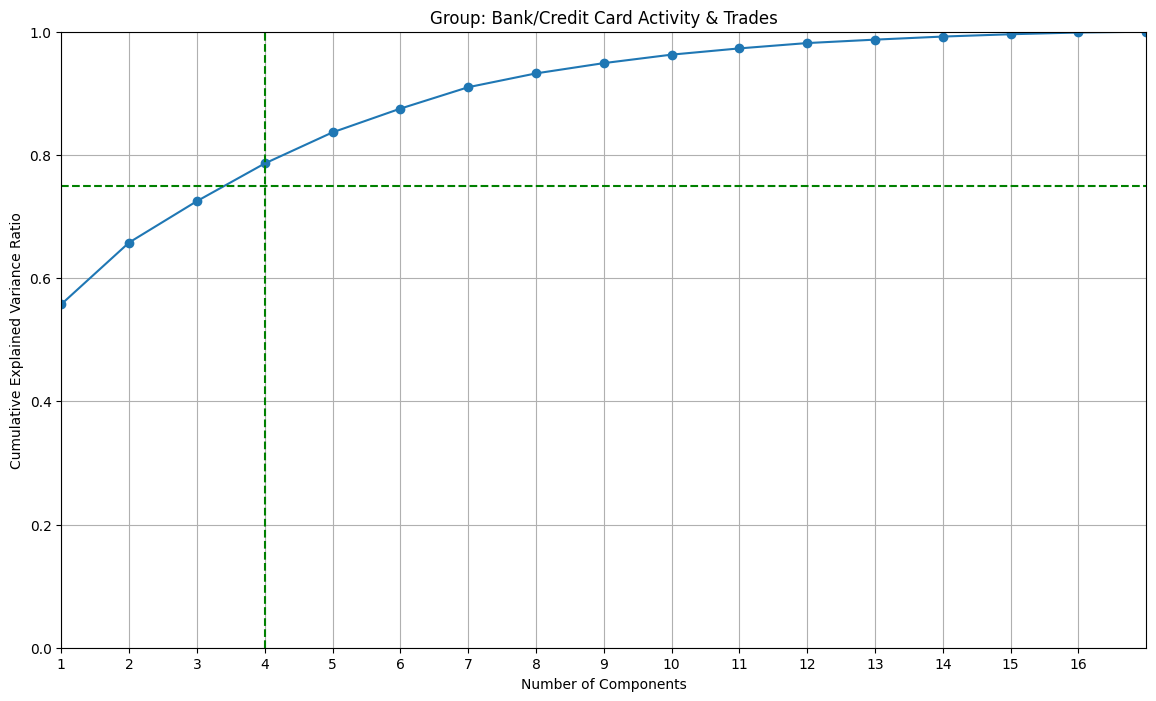

Cumulative Variance by Number of Components:
[0.61842153 0.67455626 0.72423517 0.77012742 0.80581256 0.83770952
 0.86068112 0.87669968 0.89119164 0.90376402 0.91560939 0.92584491
 0.93396356 0.94164602 0.94836724 0.95488222 0.96094643 0.96658148
 0.97184177 0.97657122 0.98092158 0.98494019 0.98800772 0.99097746
 0.99348702 0.99544669 0.99717651 0.99874451 1.        ]
Optimal Number of Components:  4


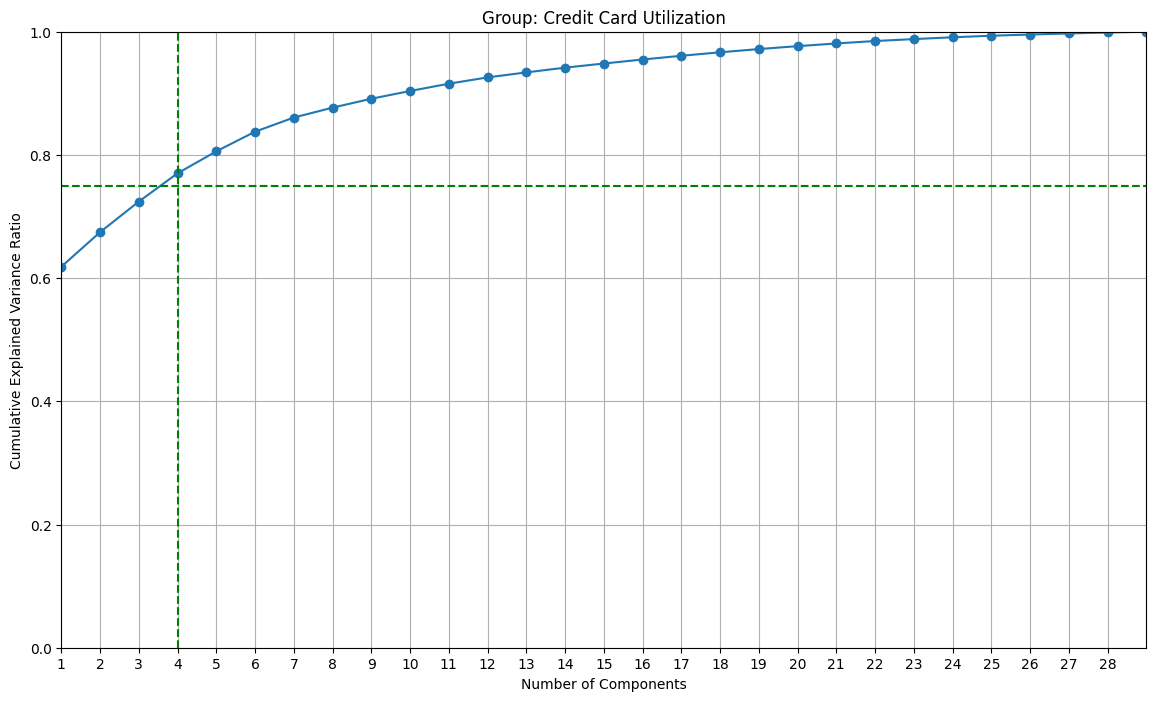

Cumulative Variance by Number of Components:
[0.5745728  0.70348914 0.75852552 0.80466478 0.84329464 0.87174667
 0.89521371 0.91487245 0.93126568 0.943393   0.95465538 0.96476784
 0.97168397 0.97810639 0.98396869 0.98885648 0.99246259 0.99577801
 0.99835716 1.        ]
Optimal Number of Components:  3


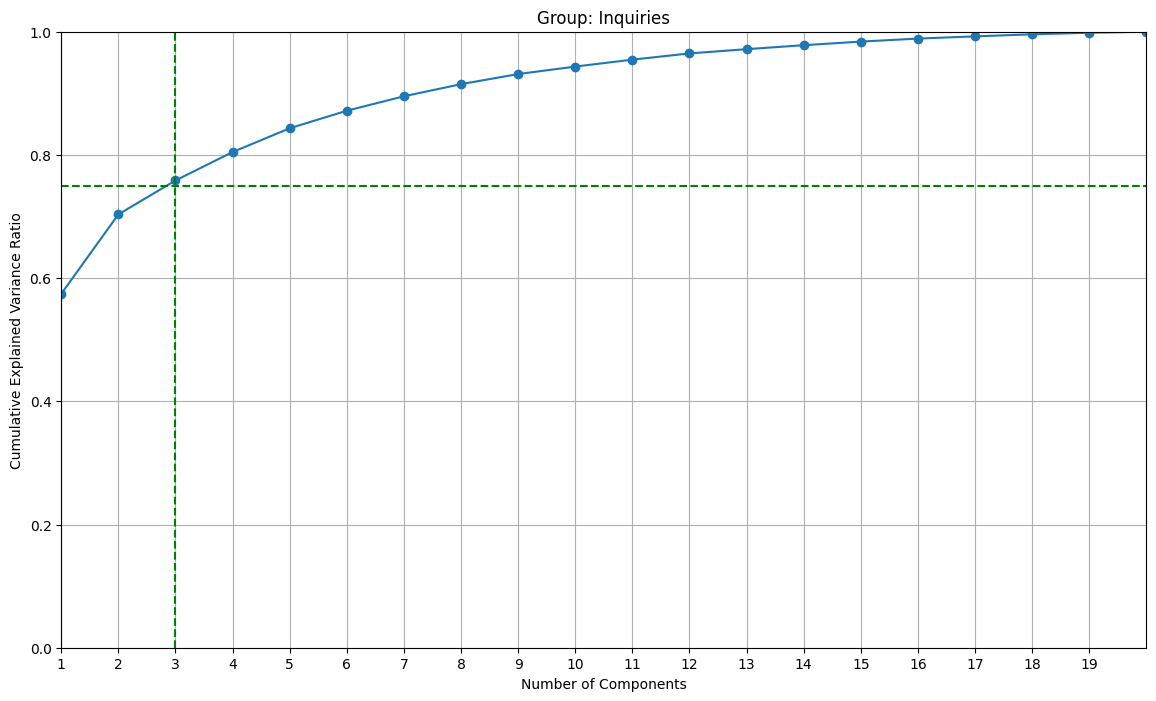

Cumulative Variance by Number of Components:
[0.57696984 0.71149356 0.78808545 0.82855273 0.86417564 0.89420384
 0.91198275 0.92506296 0.93648935 0.9470441  0.95678718 0.96481487
 0.9710366  0.97564471 0.97958752 0.98318322 0.98626683 0.98906253
 0.99144482 0.99355402 0.99527205 0.99659864 0.99780231 0.99879684
 0.99930709 0.99972181 1.        ]
Optimal Number of Components:  3


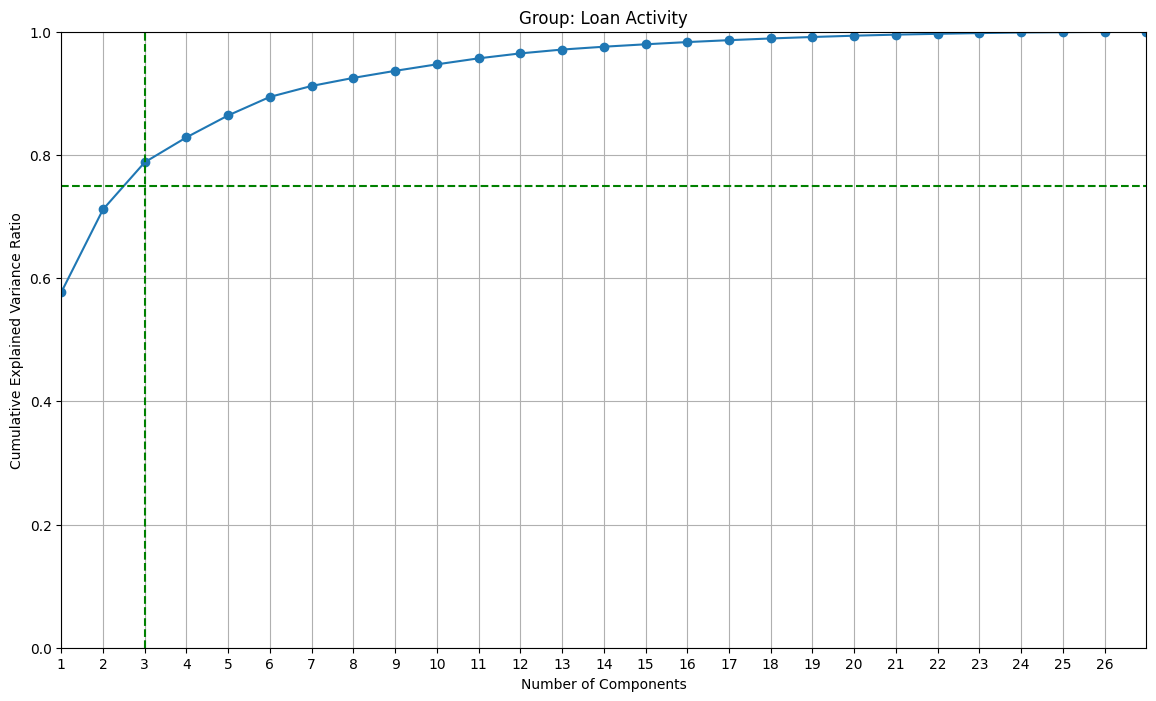

In [ ]:
# PCA transform continuous data
pca_trans = pd.DataFrame()
minimum_var = 0.75

pca_obj = []
for n in range(0, len(pca_groups)):
    data, pca = PCA_transform(n, minimum_var)
    pca_obj.append(pca)
    pca_trans = pd.concat([pca_trans, data], axis=1)

In [ ]:
# @title PCA Factor Loadings
for j, pca in enumerate(pca_obj):
    group = pca_col[pca_col['PCA Groups'] == pca_groups[j]]['Variable']
    col = []
    for i in range(pca.n_components_):
        col.append(pca_groups[j] + '_' + str(i))

    df = pd.DataFrame(pca.components_.T, index=group, columns=col)
    display(df.sort_values(by=df.columns[0], ascending=False).head())

Bank/Credit Card Activity & Trades_0  \
Variable                                                             
m_ccrea_all7360                                           0.221776   
m_cbb_number_of_accounts_all                              0.011083   
m_ccrea_fip1380                                          -0.098407   
m_ccrea_rev7432                                          -0.217537   
m_caaea_bcc0446                                          -0.237270   

                              Bank/Credit Card Activity & Trades_1  \
Variable                                                             
m_ccrea_all7360                                          -0.220115   
m_cbb_number_of_accounts_all                             -0.070020   
m_ccrea_fip1380                                           0.333618   
m_ccrea_rev7432                                          -0.091088   
m_caaea_bcc0446                                          -0.236092   

                              Bank/Credit Card Activity & Trades_2  \
Variable                                                             
m_ccrea_all7360                                          -0.206149   
m_cbb_number_of_accounts_all                             -0.431087   
m_ccrea_fip1380                                           0.360690   
m_ccrea_rev7432                                          -0.341176   
m_caaea_bcc0446                                           0.400000   

                              Bank/Credit Card Activity & Trades_3  
Variable                                                            
m_ccrea_all7360                                           0.169637  
m_cbb_number_of_accounts_all                              0.790529  
m_ccrea_fip1380                                           0.091981  
m_ccrea_rev7432                                          -0.241531  
m_caaea_bcc0446                                           0.264274

Credit Card Utilization_0  \
Variable                                                     
m_caaea_tbcc1502                                  0.169217   
m_cbb_num_of_unknown_risk_accou                   0.010325   
m_ccrea_iln7150                                  -0.023698   
m_caaea_bcc3421                                  -0.149792   
m_ccrea_brc5747                                  -0.156704   

                                 Credit Card Utilization_1  \
Variable                                                     
m_caaea_tbcc1502                                 -0.286930   
m_cbb_num_of_unknown_risk_accou                  -0.011384   
m_ccrea_iln7150                                  -0.007998   
m_caaea_bcc3421                                  -0.076862   
m_ccrea_brc5747                                  -0.007494   

                                 Credit Card Utilization_2  \
Variable                                                     
m_caaea_tbcc1502                                  0.080439   
m_cbb_num_of_unknown_risk_accou                   0.016944   
m_ccrea_iln7150                                  -0.044285   
m_caaea_bcc3421                                  -0.100891   
m_ccrea_brc5747                                   0.455199   

                                 Credit Card Utilization_3  
Variable                                                    
m_caaea_tbcc1502                                  0.247865  
m_cbb_num_of_unknown_risk_accou                  -0.131552  
m_ccrea_iln7150                                   0.358357  
m_caaea_bcc3421                                   0.542850  
m_ccrea_brc5747                                  -0.152592

Inquiries_0  Inquiries_1  Inquiries_2
Variable                                                         
m_CCRS_CA_inq_180_days_ago     0.263829    -0.021525    -0.070245
m_CCRS_CA_inq_90_days_ago      0.261142     0.133997    -0.041552
m_CCRS_CA_inq_1_year_ago       0.257477    -0.174091    -0.035777
m_CCRS_CA_inq_60_days_ago      0.255879     0.159460    -0.030292
m_CAAS_CA_clu_180_days_ago     0.255065    -0.078331    -0.043547

Loan Activity_0  Loan Activity_1  Loan Activity_2
Variable                                                                     
m_CCRS_C3_nto_180_days_ago         0.218299        -0.172789         0.076756
m_CCRS_C3_nto_15_days_ago          0.216932        -0.196292         0.029157
m_CCRS_C3_dd_180_days_ago          0.215941        -0.186579         0.131890
m_CCRS_C3_dd_90_days_ago           0.215543        -0.233351         0.059329
m_CAAS_C3_nto_24_hours_ago         0.215393        -0.198164         0.022827

In [ ]:
# @title Tranformed Data of the Continuous Variables
pca_trans

Bank/Credit Card Activity & Trades_0  \
0                                -3.501490   
1                                -3.212580   
2                                 1.325190   
3                                 4.143457   
4                                 2.739322   
...                                    ...   
2191                              3.481368   
2192                             -3.144597   
2193                              1.807501   
2194                             -0.747605   
2195                              1.180503   

      Bank/Credit Card Activity & Trades_1  \
0                                -0.770139   
1                                -0.934961   
2                                 1.384928   
3                                 0.257584   
4                                -0.817143   
...                                    ...   
2191                             -0.213354   
2192                             -0.873657   
2193                             -0.006291   
2194                             -0.969033   
2195                             -0.016502   

      Bank/Credit Card Activity & Trades_2  \
0                                -0.232947   
1                                -0.206564   
2                                 1.007564   
3                                 0.761229   
4                                 0.471273   
...                                    ...   
2191                              0.366648   
2192                             -1.705451   
2193                             -0.190971   
2194                              0.638465   
2195                             -1.318799   

      Bank/Credit Card Activity & Trades_3  Credit Card Utilization_0  \
0                                -1.126986                  -3.408323   
1                                -0.908136                  -3.268069   
2                                -0.652625                  -0.079764   
3                                -0.345281                  11.494608   
4                                -0.386170                  -0.451801   
...                                    ...                        ...   
2191                             -1.043222                   4.591756   
2192                              0.688287                  -0.554015   
2193                             -1.131359                  -0.187408   
2194                              0.889534                  -2.172266   
2195                             -0.556853                  -0.344608   

      Credit Card Utilization_1  Credit Card Utilization_2  \
0                      0.560223                  -0.004884   
1                     -0.300371                  -0.907304   
2                     -2.564963                  -0.986595   
3                      0.477352                  -0.452445   
4                     -2.247927                  -1.032707   
...                         ...                        ...   
2191                  -0.769331                   2.086309   
2192                  -2.104305                   0.654267   
2193                   0.929006                  -0.299797   
2194                  -0.673221                  -0.653831   
2195                  -2.010701                  -0.634854   

      Credit Card Utilization_3  Inquiries_0  Inquiries_1  Inquiries_2  \
0                      0.110480    -4.217744     1.485999    -0.107128   
1                      0.962718     7.046673     4.309911    -0.167451   
2                     -1.266624     4.246131    -0.033713    -0.524294   
3                      0.062660     1.013644     0.833351     1.860763   
4                     -0.968351    -3.420615     0.446798    -1.221256   
...                         ...          ...          ...          ...   
2191                  -0.432208    -3.985498     1.609863    -0.720624   
2192                   1.089870     1.183307    -1.898921     2.080631   
2193                  -0.879217    -3.451800     0.585828  

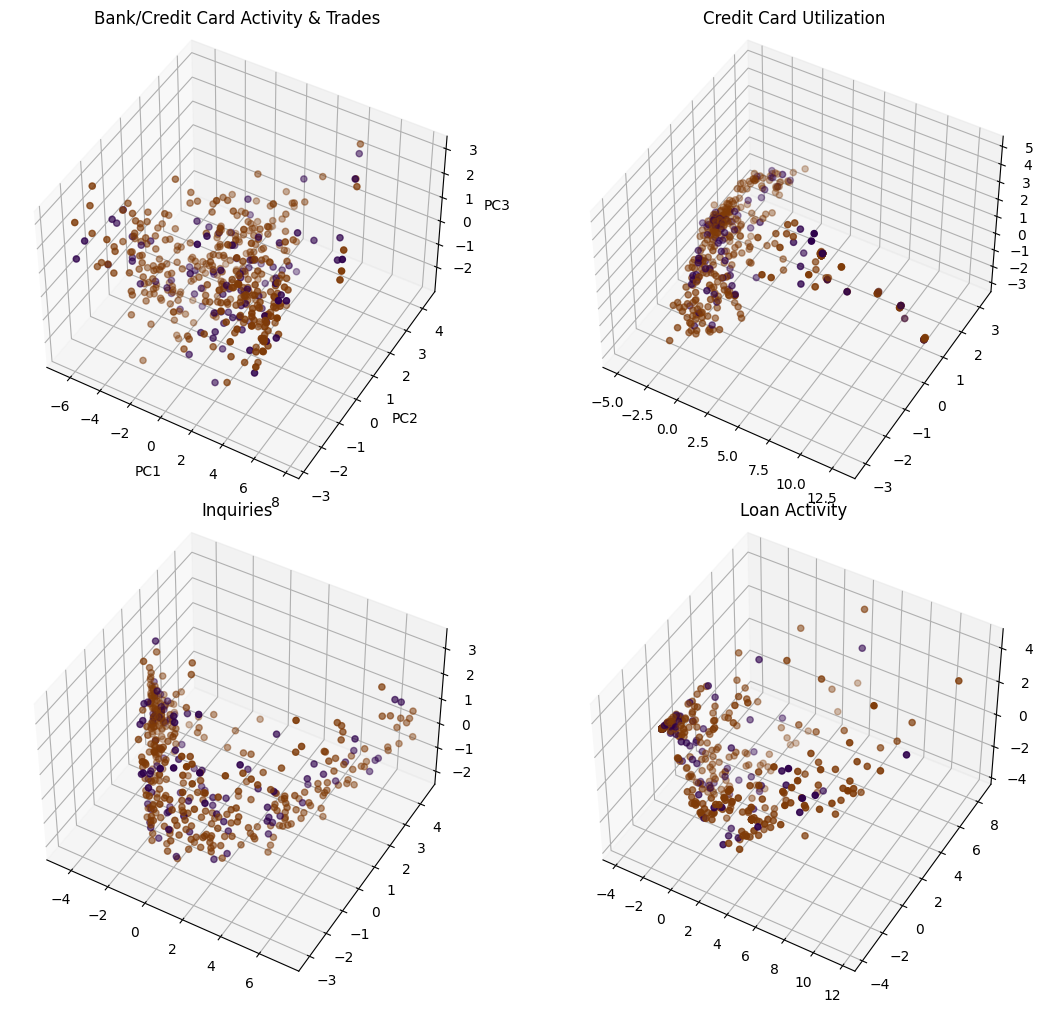

In [ ]:
# @title Visualizing the PCs (Purple = Default)

# split the data randomly for easier viewing
vis_split = pd.concat([credit['bad'], pca_trans], axis=1)
_, vis_split = train_test_split(vis_split, test_size=0.2, random_state=42)

# 3D plot the PCs with color mapping from default data
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0], projection='3d', elev=45)
ax1.scatter(vis_split.iloc[:, 1], vis_split.iloc[:, 2], vis_split.iloc[:, 3],
            c=vis_split['bad'], cmap='PuOr')

ax2 = fig.add_subplot(gs[1], projection='3d', elev=45)
ax2.scatter(vis_split.iloc[:, 5], vis_split.iloc[:, 6], vis_split.iloc[:, 7],
            c=vis_split['bad'], cmap='PuOr')

ax3 = fig.add_subplot(gs[2], projection='3d', elev=45)
ax3.scatter(vis_split.iloc[:, 9], vis_split.iloc[:, 10], vis_split.iloc[:, 11],
            c=vis_split['bad'], cmap='PuOr')

ax4 = fig.add_subplot(gs[3], projection='3d', elev=45)
ax4.scatter(vis_split.iloc[:, 12], vis_split.iloc[:, 13], vis_split.iloc[:, 14],
            c=vis_split['bad'], cmap='PuOr')

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(pca_groups[0])
ax2.set_title(pca_groups[1])
ax3.set_title(pca_groups[2])
ax4.set_title(pca_groups[3])

fig.tight_layout()
plt.show()

In [ ]:
# @title ### 3D Animated Labeled PCA Plot

fig = plt.figure(figsize=(6, 6), facecolor='whitesmoke')
gs = plt.GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0], projection='3d', elev=45)
ax1.scatter(vis_split.iloc[:, 12], vis_split.iloc[:, 13], vis_split.iloc[:, 14],
            c=vis_split['bad'], cmap='PuOr')

ax1.set_facecolor('whitesmoke')
ax1.set_title(pca_groups[3]) # change index to render different PCA group
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
fig.tight_layout()
plt.close()

def animate(frame):
    ax1.view_init(30, frame/3)
    plt.pause(0.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=250, interval=50)
HTML(anim.to_html5_video()) # comment out to save

# uncomment to save animation
# anim.save('3D-pca-labeled.gif', writer='pillow', fps=30)

## Multiple Correspondence Analysis (MCA) to Reduce Categorical Variables
*   an extension of PCA analysis for categorical variables
*   converts categorical variables to continous representations through cross-tabulation pairs
*   then, uses PCA under the hood to calculate eigenvalues

Optimal Number of Components:  10
Cumulative Variance by Number of Components:
[0.1734 0.2917 0.3762 0.4497 0.5167 0.5741 0.6269 0.6758 0.7209 0.7603
 0.7965 0.8299 0.8618 0.8919 0.9172 0.9391 0.9591 0.9775 0.9899]


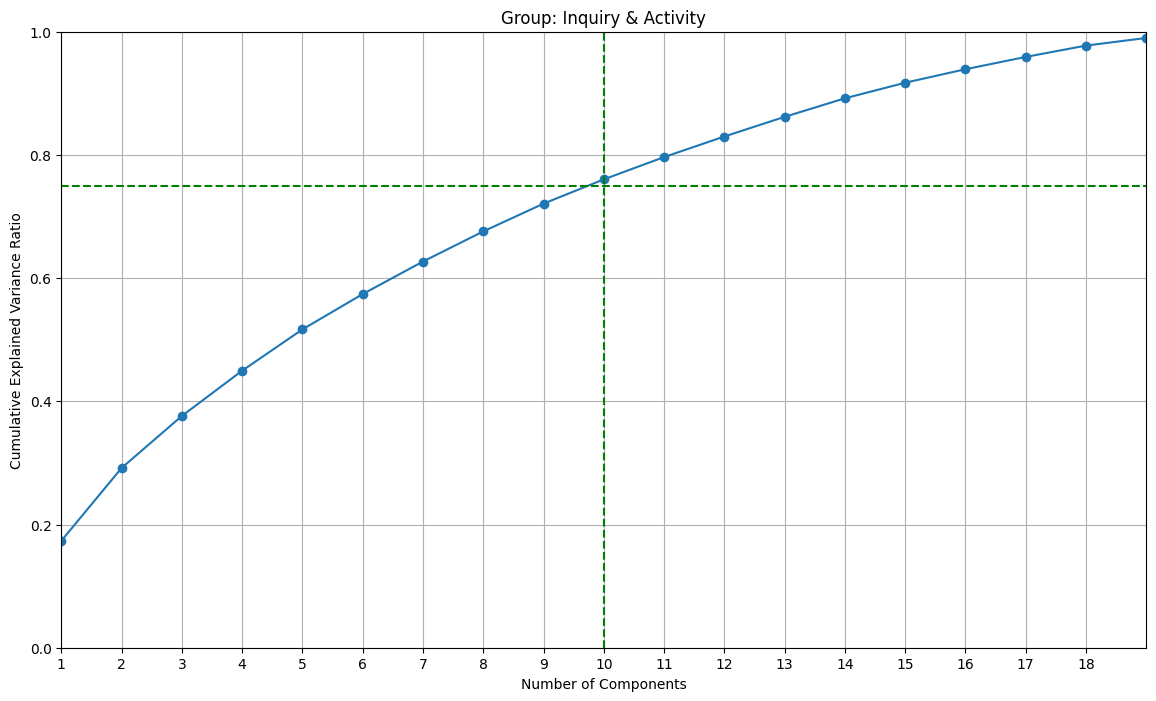



Optimal Number of Components:  6
Cumulative Variance by Number of Components:
[0.2851 0.4748 0.5809 0.6565 0.726  0.7901 0.8509 0.8866 0.9111 0.9313
 0.948  0.9634 0.9765 0.9885 0.9938 0.9974 0.999  1.    ]


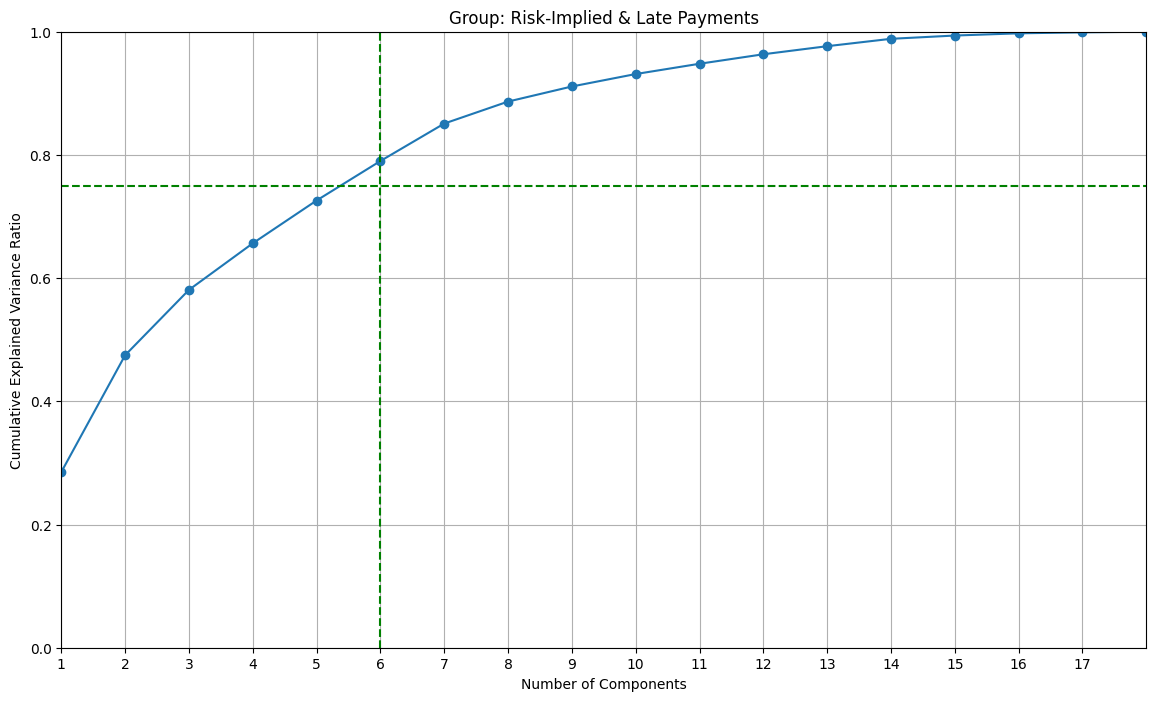

In [ ]:
mca_groups = mca_col['MCA Group'].unique()
min_var = 0.75
mca_trans = pd.DataFrame()
mca_obj = []

# graphically display MCA eigen values for analysis
for n in range(0, len(mca_groups)):
    # get the groups of variables
    col = mca_col[mca_col['MCA Group'] == mca_groups[n]]['Variable']

    # perform the MCA analysis
    mca = MCA(n_components=len(col) - 1, random_state=42)
    mca.fit(credit[col])

    # get a Series of cummulative eigenvalue ratios
    mca_cum_eigen = mca.eigenvalues_summary[
        '% of variance (cumulative)'
        ].str.replace('%', '').astype(float) / 100
    optimal_components = np.argmax(mca_cum_eigen >= min_var) + 1

    mca_obj.append(MCA(n_components=optimal_components, random_state=42).fit(
        credit[col]
    ))

    # prepare to label the columns of the transformed dataframe
    colnames = []
    for i in range(0, optimal_components):
        col_name = mca_groups[n] + '_' + str(i)
        colnames.append(col_name)

    # concatenate components
    trans = mca.row_coordinates(credit[col]).iloc[:, :optimal_components]
    trans.columns = colnames
    mca_trans = pd.concat([mca_trans, trans], axis=1)

    # show the results
    print('Optimal Number of Components: ', optimal_components)
    print('Cumulative Variance by Number of Components:')
    print(mca_cum_eigen.to_numpy())
    plot_eigen(mca_cum_eigen,
               vline=optimal_components,
               hline=min_var,
               g_title=mca_groups[n])
    print('\n')

In [ ]:
# @title MCA Factor Loadings
for j, mca in enumerate(mca_obj):
    col = []
    for i in range(mca.column_contributions_.shape[1]):
        col.append(mca_groups[j] + '_' + str(i))

    mca.column_contributions_.columns = col
    display(mca.column_contributions_.sort_values(
        by=mca.column_contributions_.columns[0], ascending=False
    ).head())

Inquiry & Activity_0  \
m_ccr_days_since_last_ontime_pmt_1              0.093765   
m_bba_p_validated_through_trades_1              0.078574   
m_CAAS_C3_ato_7_days_ago_1                      0.077795   
m_ccr_num_of_loans_cur_and_ope_1                0.071624   
m_ccr_num_of_loans_cur_and_ope_0                0.059996   

                                    Inquiry & Activity_1  \
m_ccr_days_since_last_ontime_pmt_1              0.038790   
m_bba_p_validated_through_trades_1              0.016141   
m_CAAS_C3_ato_7_days_ago_1                      0.020785   
m_ccr_num_of_loans_cur_and_ope_1                0.045717   
m_ccr_num_of_loans_cur_and_ope_0                0.038295   

                                    Inquiry & Activity_2  \
m_ccr_days_since_last_ontime_pmt_1              0.009825   
m_bba_p_validated_through_trades_1              0.003008   
m_CAAS_C3_ato_7_days_ago_1                      0.001180   
m_ccr_num_of_loans_cur_and_ope_1                0.004785   
m_ccr_num_of_loans_cur_and_ope_0                0.004008   

                                    Inquiry & Activity_3  \
m_ccr_days_since_last_ontime_pmt_1              0.000082   
m_bba_p_validated_through_trades_1              0.006927   
m_CAAS_C3_ato_7_days_ago_1                      0.062285   
m_ccr_num_of_loans_cur_and_ope_1                0.001895   
m_ccr_num_of_loans_cur_and_ope_0                0.001588   

                                    Inquiry & Activity_4  \
m_ccr_days_since_last_ontime_pmt_1              0.016203   
m_bba_p_validated_through_trades_1              0.002261   
m_CAAS_C3_ato_7_days_ago_1                      0.000072   
m_ccr_num_of_loans_cur_and_ope_1                0.012124   
m_ccr_num_of_loans_cur_and_ope_0                0.010155   

                                    Inquiry & Activity_5  \
m_ccr_days_since_last_ontime_pmt_1              0.003573   
m_bba_p_validated_through_trades_1              0.011098   
m_CAAS_C3_ato_7_days_ago_1                      0.003026   
m_ccr_num_of_loans_cur_and_ope_1                0.000024   
m_ccr_num_of_loans_cur_and_ope_0                0.000020   

                                    Inquiry & Activity_6  \
m_ccr_days_since_last_ontime_pmt_1              0.033888   
m_bba_p_validated_through_trades_1              0.007474   
m_CAAS_C3_ato_7_days_ago_1                      0.024963   
m_ccr_num_of_loans_cur_and_ope_1                0.055154   
m_ccr_num_of_loans_cur_and_ope_0                0.046200   

                                    Inquiry & Activity_7  \
m_ccr_days_since_last_ontime_pmt_1              0.003684   
m_bba_p_validated_through_trades_1              0.022121   
m_CAAS_C3_ato_7_days_ago_1                      0.021166   
m_ccr_num_of_loans_cur_and_ope_1                0.001147   
m_ccr_num_of_loans_cur_and_ope_0                0.000961   

                                    Inquiry & Activity_8  Inquiry & Activity_9  
m_ccr_days_since_last_ontime_pmt_1              0.000124              0.009159  
m_bba_p_validated_through_trades_1              0.018210              0.000531  
m_CAAS_C3_ato_7_days_ago_1                      0.000486              0.042073  
m_ccr_num_of_loans_cur_and_ope_1                0.001641              0.000529  
m_ccr_num_of_loans_cur_and_ope_0                0.001374              0.000443

Risk-Implied & Late Payments_0  \
m_CCRS_ALL_dlp_2_years_ago_1                        0.113483   
m_CCRS_ALL_nlp_2_years_ago_1                        0.103266   
m_CCRS_ALL_dlp_7_years_ago_1                        0.101164   
m_CCRS_ALL_alp_7_years_ago_1                        0.089705   
m_CCRS_ALL_nlp_90_days_ago_1                        0.082714   

                              Risk-Implied & Late Payments_1  \
m_CCRS_ALL_dlp_2_years_ago_1                        0.000781   
m_CCRS_ALL_nlp_2_years_ago_1                        0.000608   
m_CCRS_ALL_dlp_7_years_ago_1                        0.001205   
m_CCRS_ALL_alp_7_years_ago_1                        0.001003   
m_CCRS_ALL_nlp_90_days_ago_1                        0.000111   

                              Risk-Implied & Late Payments_2  \
m_CCRS_ALL_dlp_2_years_ago_1                        0.000027   
m_CCRS_ALL_nlp_2_years_ago_1                        0.000350   
m_CCRS_ALL_dlp_7_years_ago_1                        0.001518   
m_CCRS_ALL_alp_7_years_ago_1                        0.004301   
m_CCRS_ALL_nlp_90_days_ago_1                        0.026212   

                              Risk-Implied & Late Payments_3  \
m_CCRS_ALL_dlp_2_years_ago_1                        0.000009   
m_CCRS_ALL_nlp_2_years_ago_1                        0.000060   
m_CCRS_ALL_dlp_7_years_ago_1                        0.000205   
m_CCRS_ALL_alp_7_years_ago_1                        0.000196   
m_CCRS_ALL_nlp_90_days_ago_1                        0.000857   

                              Risk-Implied & Late Payments_4  \
m_CCRS_ALL_dlp_2_years_ago_1                        0.000530   
m_CCRS_ALL_nlp_2_years_ago_1                        0.000005   
m_CCRS_ALL_dlp_7_years_ago_1                        0.000308   
m_CCRS_ALL_alp_7_years_ago_1                        0.001032   
m_CCRS_ALL_nlp_90_days_ago_1                        0.049255   

                              Risk-Implied & Late Payments_5  
m_CCRS_ALL_dlp_2_years_ago_1                        0.000027  
m_CCRS_ALL_nlp_2_years_ago_1                        0.000411  
m_CCRS_ALL_dlp_7_years_ago_1                        0.000031  
m_CCRS_ALL_alp_7_years_ago_1                        0.000091  
m_CCRS_ALL_nlp_90_days_ago_1                        0.004940

In [ ]:
# @title Transformed Data of the Categorical Variables
mca_trans

Inquiry & Activity_0  Inquiry & Activity_1  Inquiry & Activity_2  \
0                -0.699553             -0.457828              0.060322   
1                 0.034842             -0.110989             -0.073564   
2                 0.332738             -0.302151             -0.172768   
3                -0.643531              0.290599              0.461278   
4                -0.485196             -0.106727              0.003799   
...                    ...                   ...                   ...   
2191             -0.230703             -0.525150             -0.124204   
2192              0.648303              0.289726              0.629599   
2193             -0.626018             -0.251024              0.018921   
2194             -0.281076              0.314523             -0.223350   
2195              0.018326              0.602734              0.487054   

      Inquiry & Activity_3  Inquiry & Activity_4  Inquiry & Activity_5  \
0                -0.095760             -0.090617             -0.022619   
1                -0.134519              0.336159             -0.062916   
2                 0.315014              0.701192             -0.259937   
3                 0.482835              0.033456              0.053506   
4                -0.273302             -0.091229              0.128721   
...                    ...                   ...                   ...   
2191              0.311122             -0.205484             -0.138310   
2192              0.164983              0.145819              0.170761   
2193             -0.167113             -0.162098              0.048027   
2194             -0.215436              0.239831             -0.458860   
2195              0.143474              0.535078             -0.502267   

      Inquiry & Activity_6  Inquiry & Activity_7  Inquiry & Activity_8  \
0                 0.007536             -0.156026             -0.106929   
1                -0.428244              0.068666              0.349198   
2                -0.073799              0.176584             -0.158319   
3                 0.134724             -0.017230              0.017551   
4                -0.060053             -0.040431             -0.162277   
...                    ...                   ...                   ...   
2191              0.281048             -0.298621             -0.014421   
2192              0.142004             -0.033684             -0.321549   
2193              0.123566             -0.100091             -0.093230   
2194              0.197008             -0.016227             -0.039765   
2195              0.021531              0.144425              0.502819   

      Inquiry & Activity_9  Risk-Implied & Late Payments_0  \
0                 0.053814                       -0.354110   
1                 0.180864                       -0.418919   
2                -0.070091                       -0.353128   
3                 0.045011                       -0.470884   
4                -0.191556                       -0.378740   
...                    ...                             ...   
2191              0.132540                       -0.279894   
2192             -0.002322                       -0.367677   
2193             -0.036837                       -0.378740   
2194              0.135030                        1.202857   
2195              0.029791                       -0.394289   

      Risk-Implied & Late Payments_1  Risk-Implied & Late Payments_2  \
0                          -0.112217                       -0.227424   
1                          -0.187770                        0.149078   
2                          -0.245857                        0.400339   
3                           1.258064                       -0.089505   
4                          -0.090835                       -0.337332   
...                              ...                             ...   
2191                       -0.139418                       -0.093355   
2192              

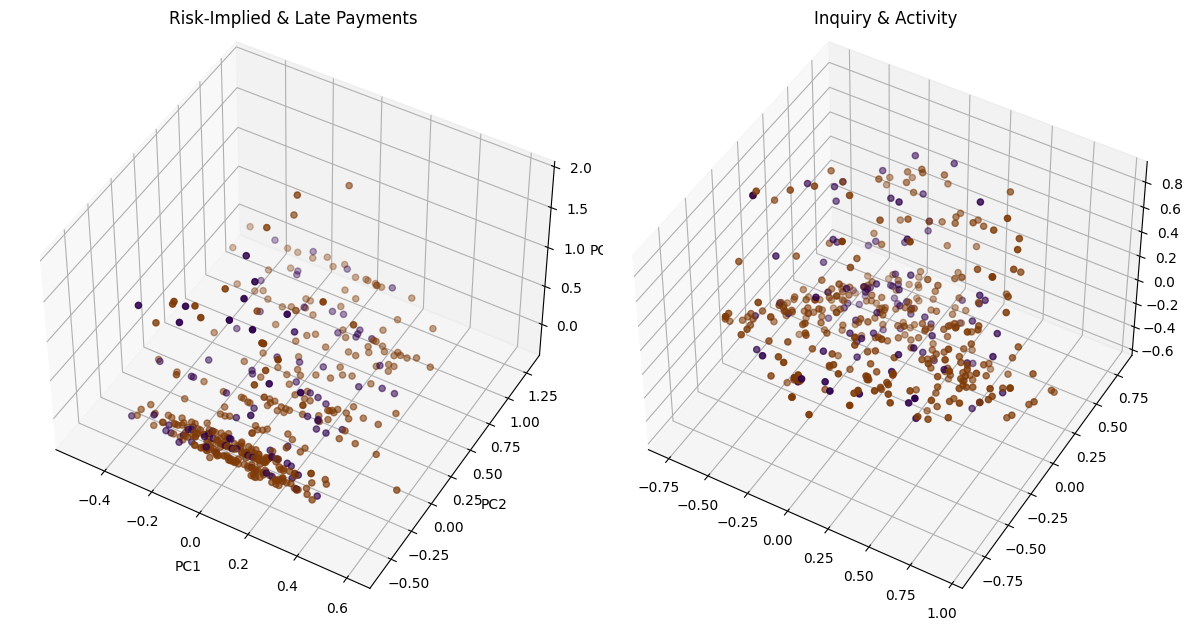

In [ ]:
# @title Visualizing the PCs (Purple = Default)

# split the data randomly for easier viewing
vis_split = pd.concat([credit['bad'], mca_trans], axis=1)
_, vis_split = train_test_split(vis_split, test_size=0.2, random_state=42)

# 3D plot the PCs with color mapping from default data
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0], projection='3d', elev=45)
ax1.scatter(vis_split.iloc[:, 10], vis_split.iloc[:, 11], vis_split.iloc[:, 12],
            c=vis_split['bad'], cmap='PuOr')

ax2 = fig.add_subplot(gs[1], projection='3d', elev=45)
ax2.scatter(vis_split.iloc[:, 1], vis_split.iloc[:, 2], vis_split.iloc[:, 3],
            c=vis_split['bad'], cmap='PuOr')

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(mca_groups[1])
ax2.set_title(mca_groups[0])

fig.tight_layout()
plt.show()

In [ ]:
# @title ### 3D Animated Labeled MCA Plot

fig = plt.figure(figsize=(6, 6), facecolor='whitesmoke')
gs = plt.GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0], projection='3d', elev=45)
ax1.scatter(vis_split.iloc[:, 10], vis_split.iloc[:, 11], vis_split.iloc[:, 12],
            c=vis_split['bad'], cmap='PuOr')

ax1.set_facecolor('whitesmoke')
ax1.set_title(mca_groups[1]) # change index to render different MCA group
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
fig.tight_layout()
plt.close()

def animate(frame):
    ax1.view_init(30, frame/3)
    plt.pause(0.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=250, interval=50)
HTML(anim.to_html5_video()) # comment out to save

# uncomment to save animation
# anim.save('3D-pca-labeled.gif', writer='pillow', fps=30)

# K-Means Clustering
*   combined transformed data with remaining continous variables
*   performed clustering analaysis again on standardized data to visualize customer groups and their default rates

**Note:** While we could have used the "elbow method" to determine the number of clusters `K`, we instead chose `K=10` for the quasi-interpretive ability to group clusters into "deciles". This allowed us to produce a `matplotlib` graph projecting default rate (y) on the clusters (x) that had a bit higher resolution.

In [ ]:
# @title Combine and Standardize Data

# standardize remainder variables
scaler = StandardScaler()
remainder_stan = pd.DataFrame(scaler.fit_transform(credit[remainder_vars]))
remainder_stan.columns = remainder_vars

# combine transformed and remainder variables into one dataset
credit_trans = pd.concat([pca_trans, mca_trans, remainder_stan], axis=1)
credit_trans

Bank/Credit Card Activity & Trades_0  \
0                                -3.501490   
1                                -3.212580   
2                                 1.325190   
3                                 4.143457   
4                                 2.739322   
...                                    ...   
2191                              3.481368   
2192                             -3.144597   
2193                              1.807501   
2194                             -0.747605   
2195                              1.180503   

      Bank/Credit Card Activity & Trades_1  \
0                                -0.770139   
1                                -0.934961   
2                                 1.384928   
3                                 0.257584   
4                                -0.817143   
...                                    ...   
2191                             -0.213354   
2192                             -0.873657   
2193                             -0.006291   
2194                             -0.969033   
2195                             -0.016502   

      Bank/Credit Card Activity & Trades_2  \
0                                -0.232947   
1                                -0.206564   
2                                 1.007564   
3                                 0.761229   
4                                 0.471273   
...                                    ...   
2191                              0.366648   
2192                             -1.705451   
2193                             -0.190971   
2194                              0.638465   
2195                             -1.318799   

      Bank/Credit Card Activity & Trades_3  Credit Card Utilization_0  \
0                                -1.126986                  -3.408323   
1                                -0.908136                  -3.268069   
2                                -0.652625                  -0.079764   
3                                -0.345281                  11.494608   
4                                -0.386170                  -0.451801   
...                                    ...                        ...   
2191                             -1.043222                   4.591756   
2192                              0.688287                  -0.554015   
2193                             -1.131359                  -0.187408   
2194                              0.889534                  -2.172266   
2195                             -0.556853                  -0.344608   

      Credit Card Utilization_1  Credit Card Utilization_2  \
0                      0.560223                  -0.004884   
1                     -0.300371                  -0.907304   
2                     -2.564963                  -0.986595   
3                      0.477352                  -0.452445   
4                     -2.247927                  -1.032707   
...                         ...                        ...   
2191                  -0.769331                   2.086309   
2192                  -2.104305                   0.654267   
2193                   0.929006                  -0.299797   
2194                  -0.673221                  -0.653831   
2195                  -2.010701                  -0.634854   

      Credit Card Utilization_3  Inquiries_0  Inquiries_1  ...  \
0                      0.110480    -4.217744     1.485999  ...   
1                      0.962718     7.046673     4.309911  ...   
2                     -1.266624     4.246131    -0.033713  ...   
3                      0.062660     1.013644     0.833351  ...   
4                     -0.968351    -3.420615     0.446798  ...   
...                         ...          ...          ...  ...   
2191                  -0.432208    -3.985498     1.609863  ...   
2192                   1.089870     1.183307    -1.898921  ...   
2193                  -0.879217    -3.451800     0.585828  ...   
2194                   1.349220    -2.085493     0.778278  ...   

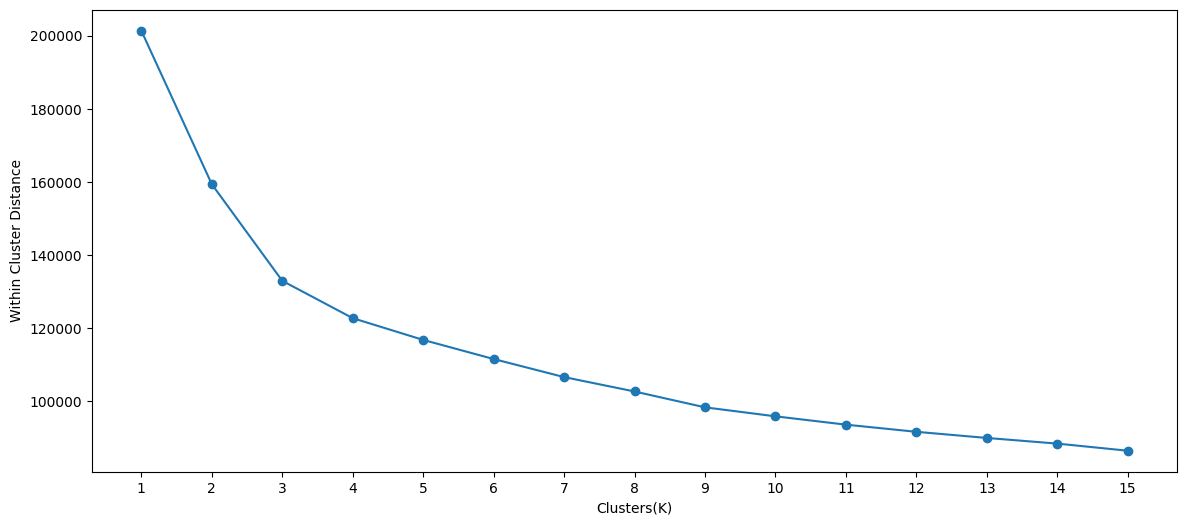

In [ ]:
# @title Scree Plot
plot_kscree(credit_trans) # steeper scree plot now

In [ ]:
# @title Clustered Default Rates
# K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(credit_trans)
k_labels = credit
k_labels['cluster'] = kmeans.labels_

# cluster details
K = range(0, max(k_labels['cluster']) + 1)
clusters = pd.DataFrame(columns=['Size', 'Default Rate'])
for i in K:
  cluster = k_labels[k_labels['cluster'] == i]
  clusters.loc[i, 'Size'] = len(cluster)
  clusters.loc[i, 'Default Rate'] = cluster['bad'].sum() / len(cluster)

clusters.sort_values(by='Default Rate')

Size Default Rate
1  317     0.132492
8  142     0.140845
4  191     0.157068
6  343      0.16035
0  187     0.165775
7  233     0.171674
2  117     0.179487
9  223     0.233184
5  142     0.267606
3  301      0.27907

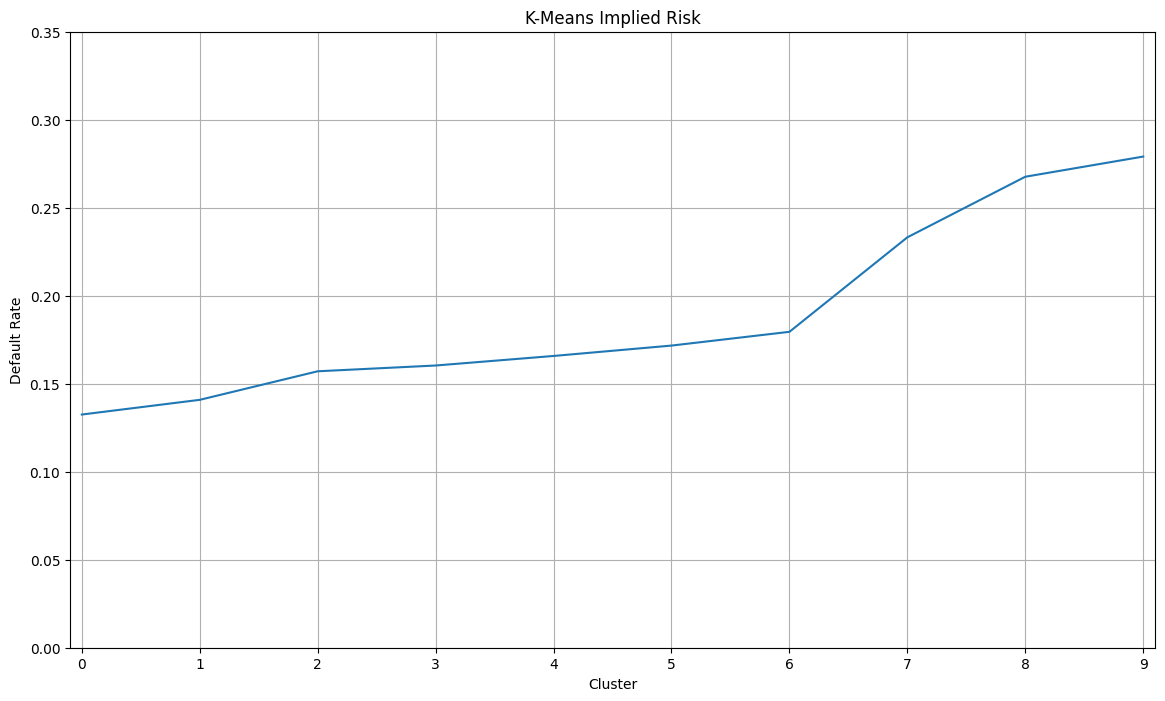

In [ ]:
# @title Visualize the Default Rate per Cluster

plt.figure(figsize=(14, 8))
plt.plot(list(range(len(clusters))),
         clusters.sort_values(by='Default Rate')['Default Rate'])

plt.ylim(0, 0.35)
plt.ylabel('Default Rate')

plt.xlim(-0.1, len(clusters) - 0.9)
plt.xticks(range(0, len(clusters)))
plt.xlabel('Cluster')

plt.title('K-Means Implied Risk')
plt.grid(True)
plt.show()

# Rebalance Dataset
*   Why balance?
    *   unbalanced data makes it difficult to clearly recogize the minority class
    *   reduces estimation bias
    *   reduces the risk of overfitting the model to the majority class
    *   improves overall model performance
        *   **we found rebalancing to have a significant effect on False Negative rate**

*   Resampling Method
    *   Upsampled miniority group - creates duplicates of the default class
    *   Downsampled majority group - randomly deletes some cases from the no-default class

*   SMOTE
    *   creates synthetic data points from the miniority (default) group
    *   uses K-Nearest Neighbors under the hood to generate points close to the data designation "_frontier_"

*   Resampling generally performed worse than SMOTE

In [ ]:
# @title Sampling Method

rebal_ratio = 0.5
target_min_bal = int(rebal_ratio * len(credit['bad']) - np.sum(credit['bad']))
target_maj_bal = int((len(credit['bad']) - np.sum(credit['bad'])) - \
                    (1 - rebal_ratio) * len(credit['bad']))

ros = RandomOverSampler(sampling_strategy={
    1: np.sum(credit['bad']) + target_min_bal
}, random_state=42)
X_over, y_over = ros.fit_resample(credit_trans, credit['bad'])

rus = RandomUnderSampler(sampling_strategy={
    0: (len(credit['bad']) - np.sum(credit['bad'])) - target_maj_bal
}, random_state=42)
X_under, y_under = rus.fit_resample(credit_trans, credit['bad'])

X_rebal = pd.DataFrame(np.vstack((X_over.loc[y_over == 1],
                                  X_under.loc[y_under == 0])),
                       columns=credit_trans.columns)
y_rebal = pd.Series(np.concatenate((y_over[y_over == 1],
                                    y_under[y_under == 0])), name='bad')

display(X_rebal)
display(y_rebal)

Bank/Credit Card Activity & Trades_0  \
0                                 1.636493   
1                                 2.282402   
2                                 4.920740   
3                                 2.279358   
4                                -1.680654   
...                                    ...   
2191                              0.516212   
2192                              0.895298   
2193                             -0.860373   
2194                             -0.455380   
2195                              0.091776   

      Bank/Credit Card Activity & Trades_1  \
0                                 1.380262   
1                                -1.573882   
2                                -1.050909   
3                                 0.358922   
4                                 2.546402   
...                                    ...   
2191                             -0.692506   
2192                              1.033520   
2193                              1.461222   
2194                              2.249951   
2195                              1.773894   

      Bank/Credit Card Activity & Trades_2  \
0                                -1.123086   
1                                -1.464785   
2                                -0.005723   
3                                -1.317971   
4                                 0.641144   
...                                    ...   
2191                              0.936464   
2192                             -0.803127   
2193                             -0.518970   
2194                              1.256279   
2195                             -0.663751   

      Bank/Credit Card Activity & Trades_3  Credit Card Utilization_0  \
0                                 0.288324                   2.456086   
1                                -0.158865                  -0.837627   
2                                 1.271337                   8.112041   
3                                -0.038072                   7.387887   
4                                -1.180176                  -1.830731   
...                                    ...                        ...   
2191                              0.232290                  -1.260738   
2192                             -1.082147                  -1.769830   
2193                             -0.890605                  -2.343678   
2194                             -0.247007                  -1.267879   
2195                              0.428451                   0.698623   

      Credit Card Utilization_1  Credit Card Utilization_2  \
0                     -1.627850                  -1.435158   
1                      1.245736                   0.736679   
2                      1.548227                  -2.276227   
3                     -1.433613                   4.885084   
4                     -0.934609                  -0.402347   
...                         ...                        ...   
2191                  -1.306502                  -0.350650   
2192                   2.746728                   0.306156   
2193                   1.246307                   0.044435   
2194                  -2.325054                  -0.780077   
2195                  -1.613423                  -0.817994   

      Credit Card Utilization_3  Inquiries_0  Inquiries_1  ...  \
0                     -1.567790    -3.297696     0.704228  ...   
1                     -1.951288     1.768257    -2.542241  ...   
2                     -0.267836     0.742753    -2.662578  ...   
3                     -0.358376    -1.531191    -1.693108  ...   
4                     -0.356348     4.091779    -0.271350  ...   
...                         ...          ...          ...  ...   
2191                   0.022479    -3.841344     0.989032  ...   
2192                  -1.977602    -4.244875     1.487352  ...   
2193                  -0.225395    -3.372983     1.254751  ...   
2194                  -0.038488    -4.116479     1.357130  ...   

0       1
1       1
2       1
3       1
4       1
       ..
2191    0
2192    0
2193    0
2194    0
2195    0
Name: bad, Length: 2196, dtype: int64

In [ ]:
# @title SMOTE Method
smote = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=10)
X_smote, y_smote = smote.fit_resample(credit_trans, credit['bad'])

display(X_smote)
display(y_smote)

Bank/Credit Card Activity & Trades_0  \
0                                -3.501490   
1                                -3.212580   
2                                 1.325190   
3                                 4.143457   
4                                 2.739322   
...                                    ...   
3561                             -2.428668   
3562                             -1.772018   
3563                             -0.146783   
3564                              1.632298   
3565                             -3.412038   

      Bank/Credit Card Activity & Trades_1  \
0                                -0.770139   
1                                -0.934961   
2                                 1.384928   
3                                 0.257584   
4                                -0.817143   
...                                    ...   
3561                              0.892662   
3562                             -0.122862   
3563                              1.655271   
3564                             -0.433027   
3565                             -0.678689   

      Bank/Credit Card Activity & Trades_2  \
0                                -0.232947   
1                                -0.206564   
2                                 1.007564   
3                                 0.761229   
4                                 0.471273   
...                                    ...   
3561                              0.318632   
3562                              0.885512   
3563                             -0.207038   
3564                             -0.603500   
3565                             -0.395888   

      Bank/Credit Card Activity & Trades_3  Credit Card Utilization_0  \
0                                -1.126986                  -3.408323   
1                                -0.908136                  -3.268069   
2                                -0.652625                  -0.079764   
3                                -0.345281                  11.494608   
4                                -0.386170                  -0.451801   
...                                    ...                        ...   
3561                             -0.284662                  -3.084841   
3562                              0.325342                  -2.853121   
3563                             -0.487208                  -0.670547   
3564                              0.928637                  -2.311480   
3565                             -0.615942                  -3.171595   

      Credit Card Utilization_1  Credit Card Utilization_2  \
0                      0.560223                  -0.004884   
1                     -0.300371                  -0.907304   
2                     -2.564963                  -0.986595   
3                      0.477352                  -0.452445   
4                     -2.247927                  -1.032707   
...                         ...                        ...   
3561                   0.000736                  -0.514502   
3562                  -0.119618                  -0.713706   
3563                  -0.832536                   0.010250   
3564                   1.528054                  -1.072642   
3565                  -0.676102                   0.004848   

      Credit Card Utilization_3  Inquiries_0  Inquiries_1  ...  \
0                      0.110480    -4.217744     1.485999  ...   
1                      0.962718     7.046673     4.309911  ...   
2                     -1.266624     4.246131    -0.033713  ...   
3                      0.062660     1.013644     0.833351  ...   
4                     -0.968351    -3.420615     0.446798  ...   
...                         ...          ...          ...  ...   
3561                   0.313110     4.983965     0.701230  ...   
3562                   0.770431    -3.403293     0.986787  ...   
3563                  -0.633086     0.974246    -2.418227  ...   
3564                  -1.725904     0.274763    -3.010199  ...   

0       0
1       0
2       0
3       0
4       0
       ..
3561    1
3562    1
3563    1
3564    1
3565    1
Name: bad, Length: 3566, dtype: int64

# Supervised Learning

## Logistic Regression
- Used as a baseline model for predicting default with the transformed dataset. Due to its simplicity and efficiency, the performance of logistic regression is a good point of comparison for more complex models.

- Regularization can be applied to logistic regression to reduce the risk of overfitting. However, when cross-validating the penalty terms (`l2` for Ridge and `None` for standard) and the penalty coefficient `C`, the grid search concluded 0.95 and 0.50 `C` values were optimal for the resample and SMOTE cases, respectively.

- The model had a 0.630 accuracy and a 0.630 ROC score for the resampling method. For the SMOTE method, the model had 0.62 and 0.70 accuracy and ROC score, respectively.



### Resample Method

In [ ]:
# @title Fit via Cross-Validation
# split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_rebal, y_rebal, test_size=0.2, random_state=42
)

# regularized logistic regression
# note: C is the inverse of regularization strength
ridge_log_reg = LogisticRegression(
    penalty='l2', C=1.0, random_state=42, max_iter=10000, n_jobs=-1
)
ridge_log_reg.fit(X_train, y_train)

# peform the grid search and get the optimum model
params = {'penalty': ['l2', None], # ridge or standard
          'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95]}
result = param_search(X_train, y_train, ridge_log_reg, params, splits=4)

# assess the model's performance
best_lr = result.best_estimator_
y_pred = best_lr.predict(X_test)

print('Accuracy: {:>8.4f}'.format(accuracy_score(y_test, y_pred)))
print('ROC Score:{:>8.4f}'.format(roc_auc_score(y_test, y_pred)))
#print('Penalty: {}'.format(result.best_params_['penalty']))
print('Penalty:  {:>8}'.format(
    'Ridge' if result.best_params_['penalty'] == 'l2' else 'None'
))
print('Lambda:   {:>8.4f}'.format(result.best_params_['C']))

Accuracy:   0.6295
ROC Score:  0.6297
Penalty:     Ridge
Lambda:     0.9000


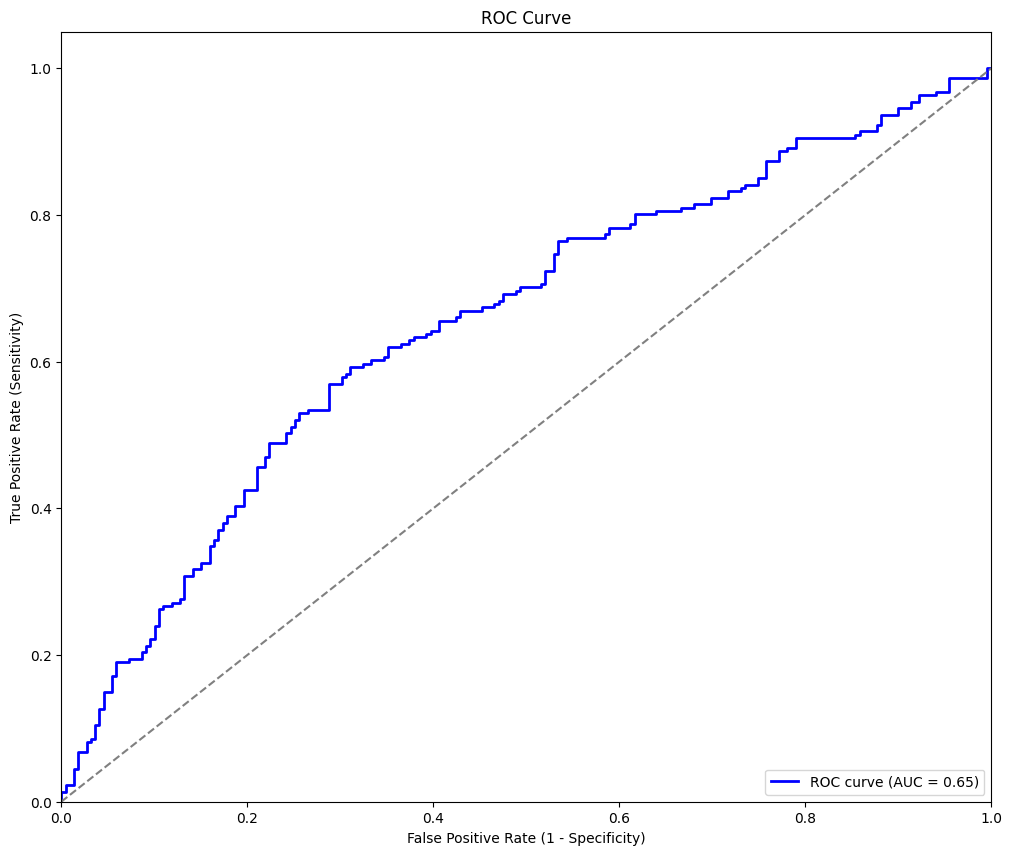

In [ ]:
# @title ROC Curve
# Probability of positive class (default)
# uses the optimum model from the gridsearch
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random classifier line

plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

Sample Size: 440
    ROC-AUC  ROC-AUC as Prob
0  0.629672         0.654642


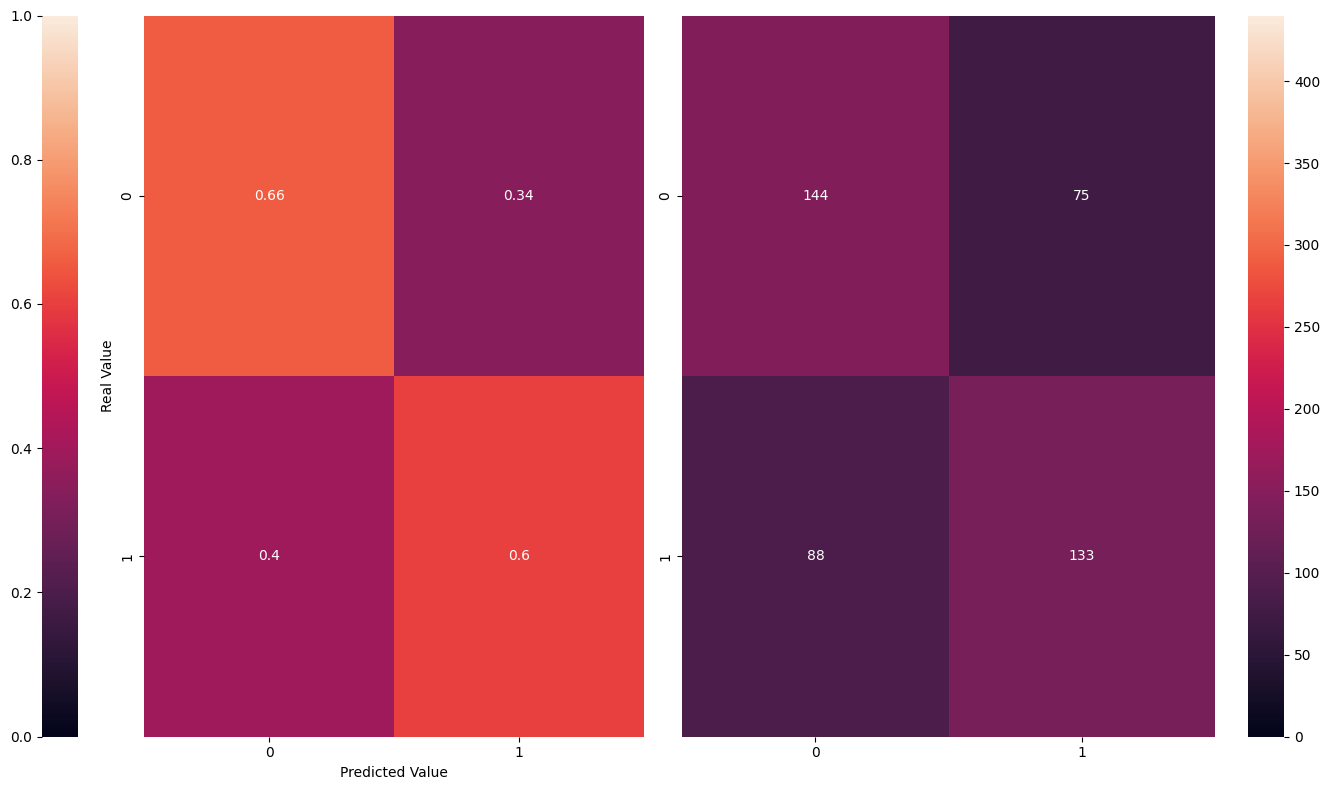

In [ ]:
# @title Confusion Matrix
print(f'Sample Size: {len(y_test)}')
model_matrix(X_test, y_test, best_lr)

### SMOTE Method

In [ ]:
# @title Fit via Cross-Validation
# split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

# regularized logistic regression
# note: C is the inverse of regularization strength
ridge_log_reg = LogisticRegression(
    penalty='l2', C=1.0, random_state=42, n_jobs=-1
)  # C is the inverse of regularization strength
ridge_log_reg.fit(X_train, y_train)

# peform the grid search and get the optimum model
params = {'penalty': ['l2', None], #ridge or standard
          'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.8, 0.9, 0.95]}
result = param_search(X_train, y_train, ridge_log_reg, params, splits=4)

# assess the model's performance
best_lr = result.best_estimator_
y_pred = best_lr.predict(X_test)

print('Accuracy: {:>8.4f}'.format(accuracy_score(y_test, y_pred)))
print('ROC Score:{:>8.4f}'.format(roc_auc_score(y_test, y_pred)))
print('Penalty:  {:>8}'.format(
    'Ridge' if result.best_params_['penalty'] == 'l2' else 'None'
))
print('Lambda:   {:>8.4f}'.format(result.best_params_['C']))

Accuracy:   0.6204
ROC Score:  0.6210
Penalty:     Ridge
Lambda:     0.5000


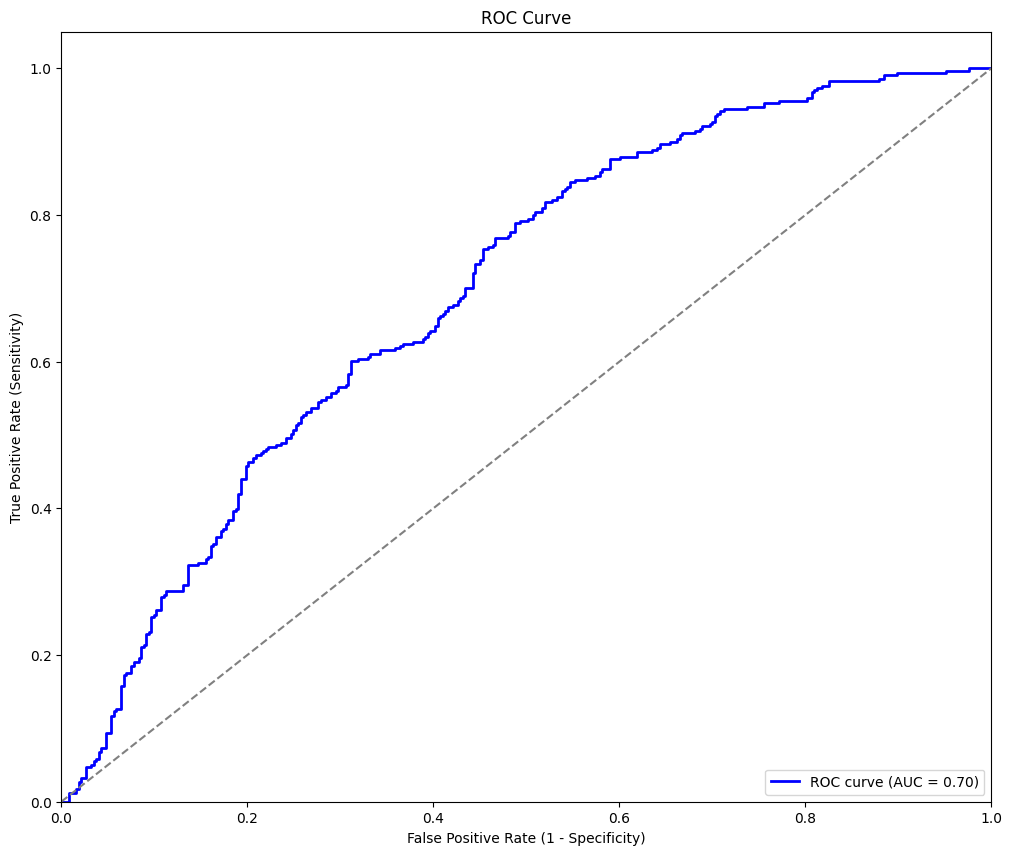

In [ ]:
# @title ROC Curve
# Probability of positive class (default)
# uses the optimum model from the gridsearch
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random classifier line

plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

Sample Size: 714
    ROC-AUC  ROC-AUC as Prob
0  0.621005         0.695125


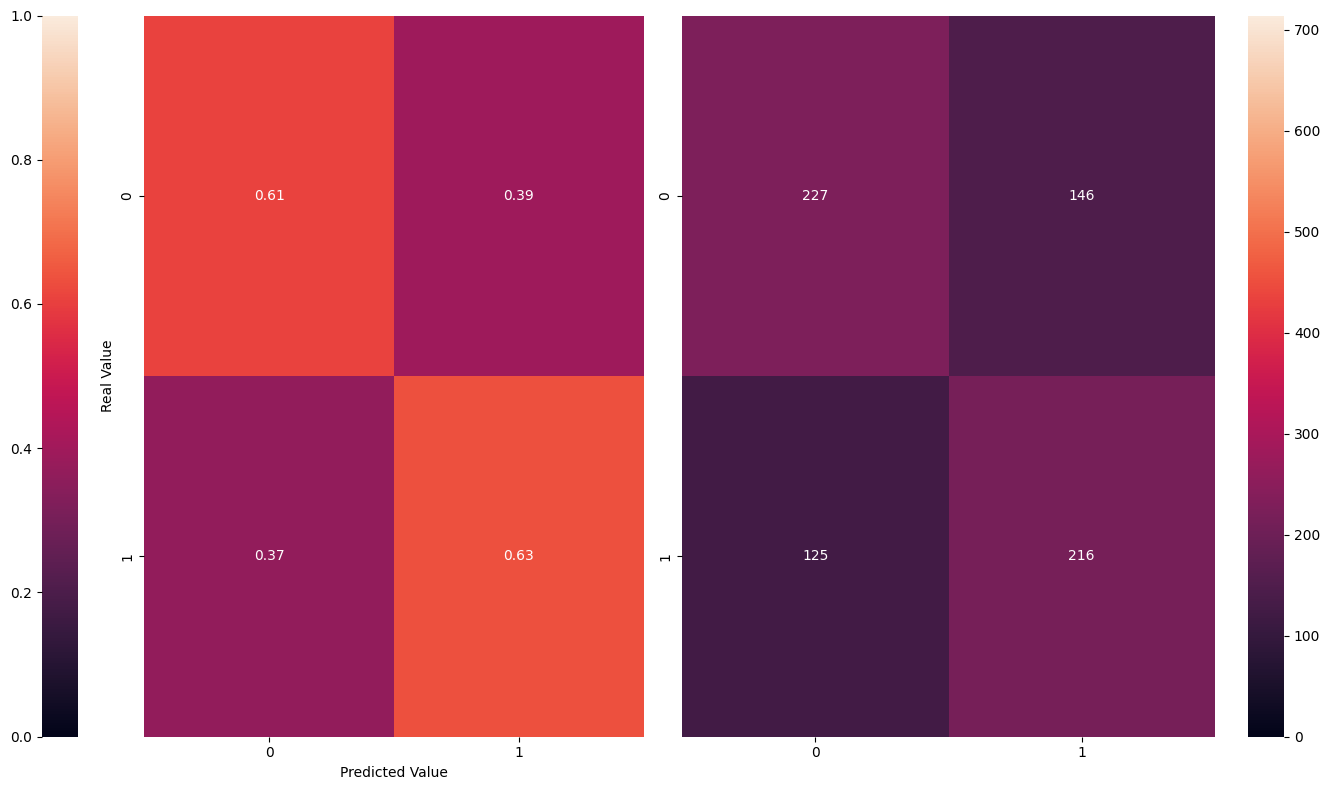

In [ ]:
# @title Confusion Matrix
print(f'Sample Size: {len(y_test)}')
model_matrix(X_test, y_test, best_lr)

## RandomForest
*   Non-parametric, **ensemble** model that use multiple DecisionTrees models
*   DecisionTrees segments data into a conditional hierarchy
*   Ideal when you know data tends to group with distinct features
*   More robust to unbalanced data
*   As also revealed by PCA/MCA and the K-Means clustering before, our credit risk data has a high propensity to cluster into groups with distinct default rates. RandomForest is ideal for an application with expalantory variable behavior like this since it capable of exploiting the distinct density patterns of default in the identified clusters.


### Resample Method
* Tested multiple test-train ratios between 20 and 40%.
* 20% the best for **highest accuracy** and **lowest false negative** rate

In [ ]:
# @title Fit via Cross-Validation
X_train, X_test, y_train, y_test = train_test_split(
    X_rebal, y_rebal, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# peform the grid search and get the optimum model
params = {'n_estimators': [300, 500, 700, 900]}
result = param_search(X_train, y_train, rf, params)

# assess the model's performance
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

print('Accuracy: {:>8.4f}'.format(accuracy_score(y_test, y_pred)))
print('ROC Score:{:>8.4f}'.format(roc_auc_score(y_test, y_pred)))
print('Number of Trees: {}'.format(result.best_params_['n_estimators']))

Accuracy:   0.8818
ROC Score:  0.8819
Number of Trees: 700


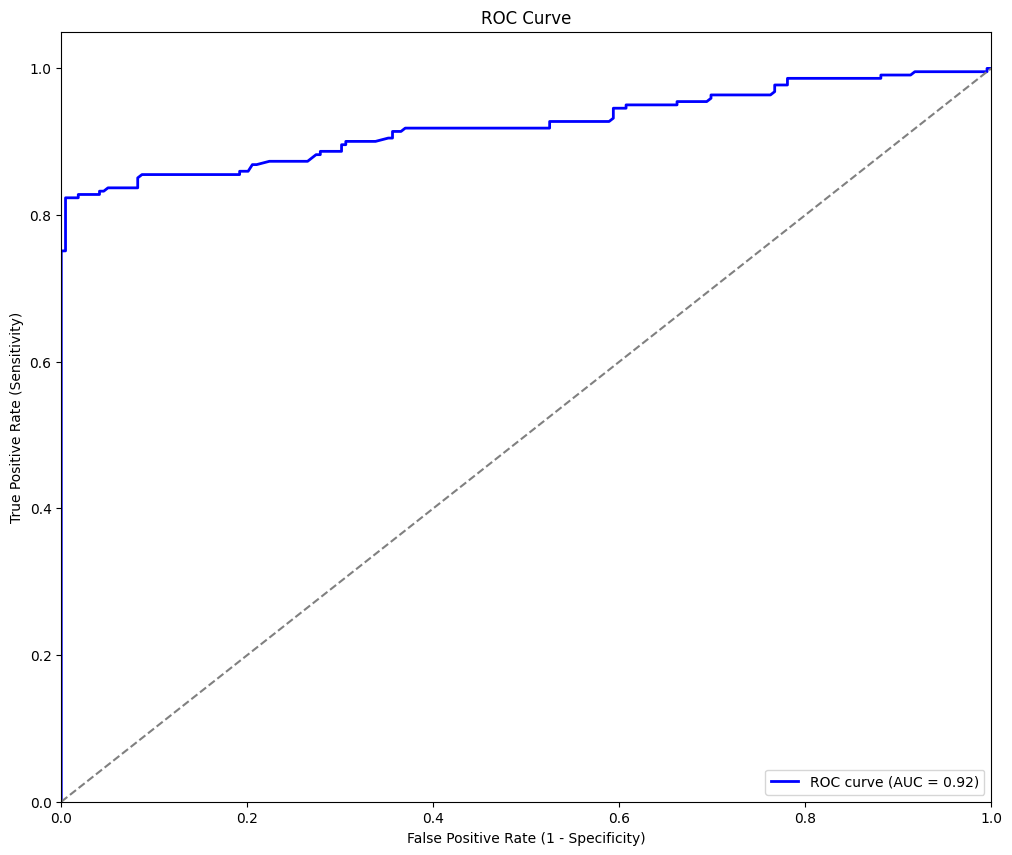

In [ ]:
# @title ROC Curve

# Probability of positive class (default)
# uses the optimum model from the gridsearch
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random classifier line

plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

Sample Size: 440
   ROC-AUC  ROC-AUC as Prob
0  0.88194         0.922095


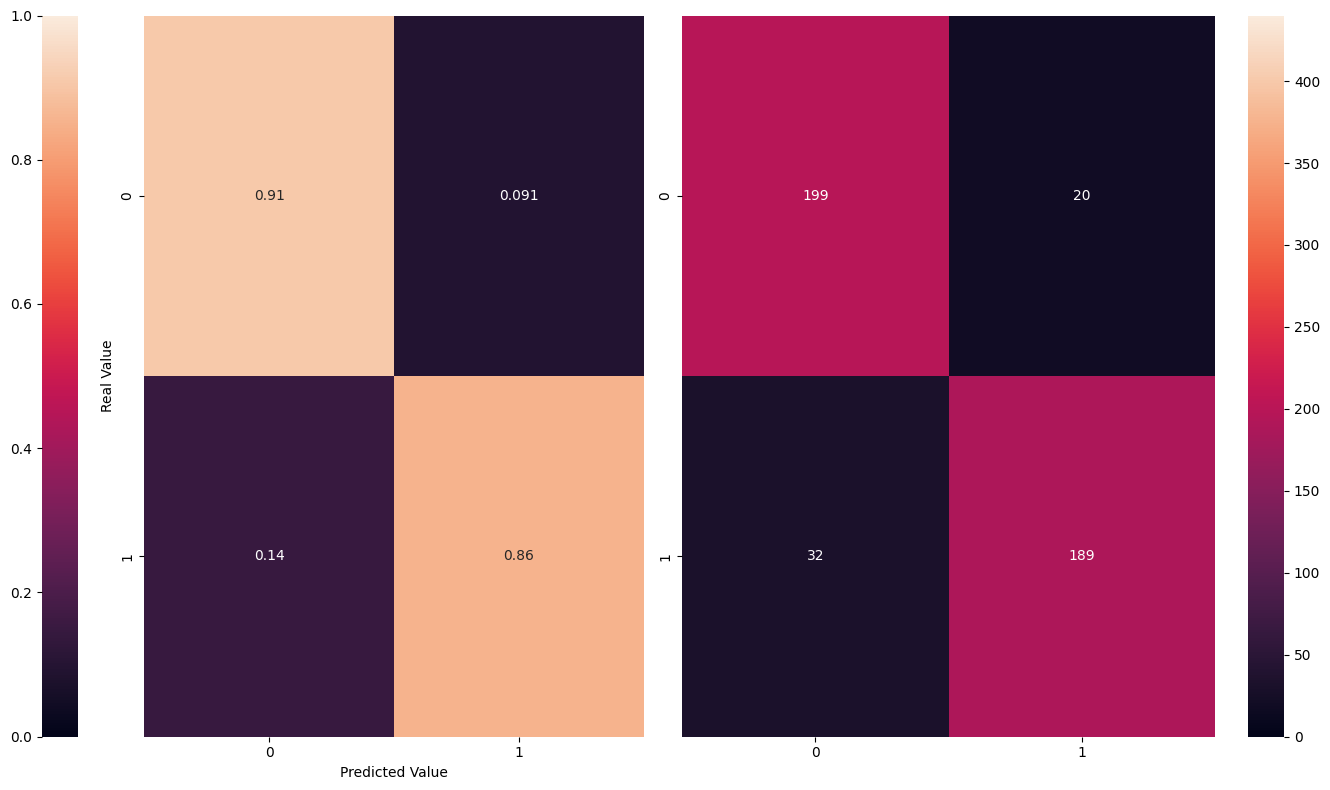

In [ ]:
# @title Confusion Matrix
print(f'Sample Size: {len(y_test)}')
model_matrix(X_test, y_test, best_model)

### SMOTE Method
* Tested multiple SMOTE sampling strategies.
* Tested multiple test-train split ratios.
* 1:1 sampling strategy and 20% test-size produced the **highest accuracy** and the **lowest false negative** rate

In [ ]:
# @title Fit via Cross-Validation

# used to test optimal sampling strategy
# smote = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=10)
# X_smote, y_smote = smote.fit_resample(credit_trans, credit['bad'])

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

# declare the model
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# peform the grid search and get the optimum model
params = {'n_estimators': [300, 500, 700]}
result = param_search(X_train, y_train, rf, params)

# assess the model's performance
best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

print('Accuracy: {:>8.4f}'.format(accuracy_score(y_test, y_pred)))
print('ROC Score:{:>8.4f}'.format(roc_auc_score(y_test, y_pred)))
print('Number of Trees: {}'.format(result.best_params_['n_estimators']))

Accuracy:   0.9202
ROC Score:  0.9181
Number of Trees: 500


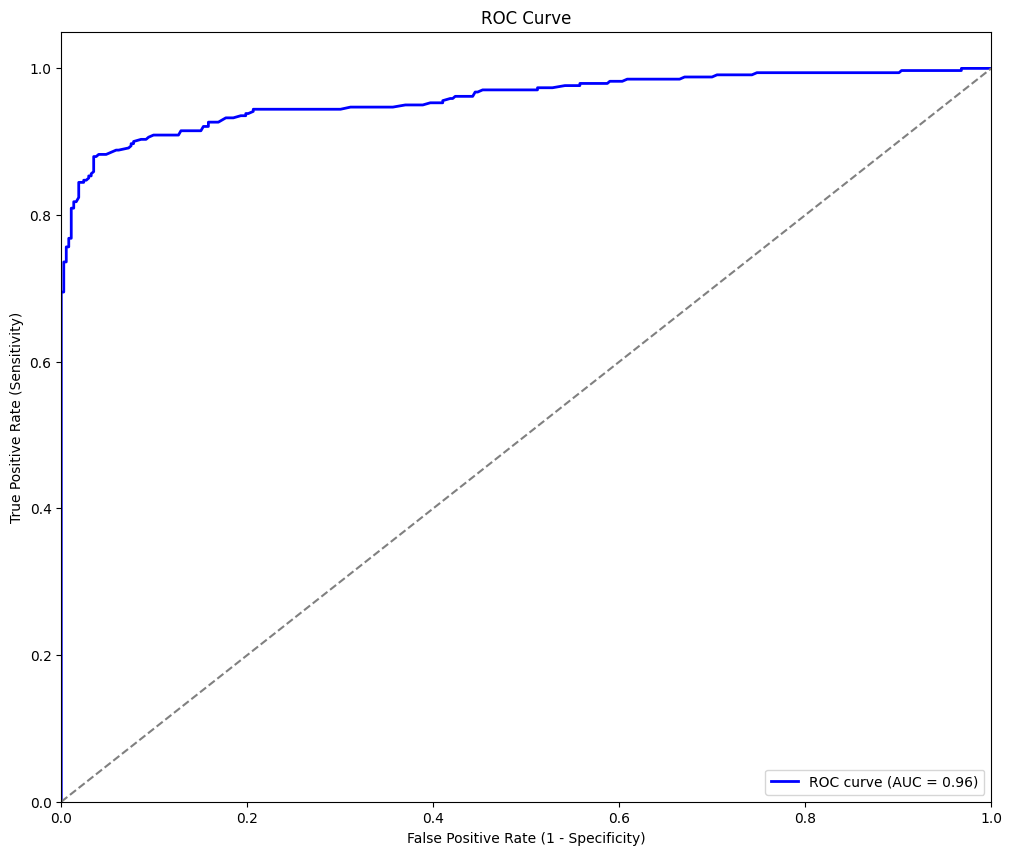

In [ ]:
# @title ROC Curve

# Probability of positive class (default)
# uses the optimum model from the gridsearch
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr, color='blue', lw=2,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random classifier line

plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

Sample Size: 714
    ROC-AUC  ROC-AUC as Prob
0  0.918058         0.958905


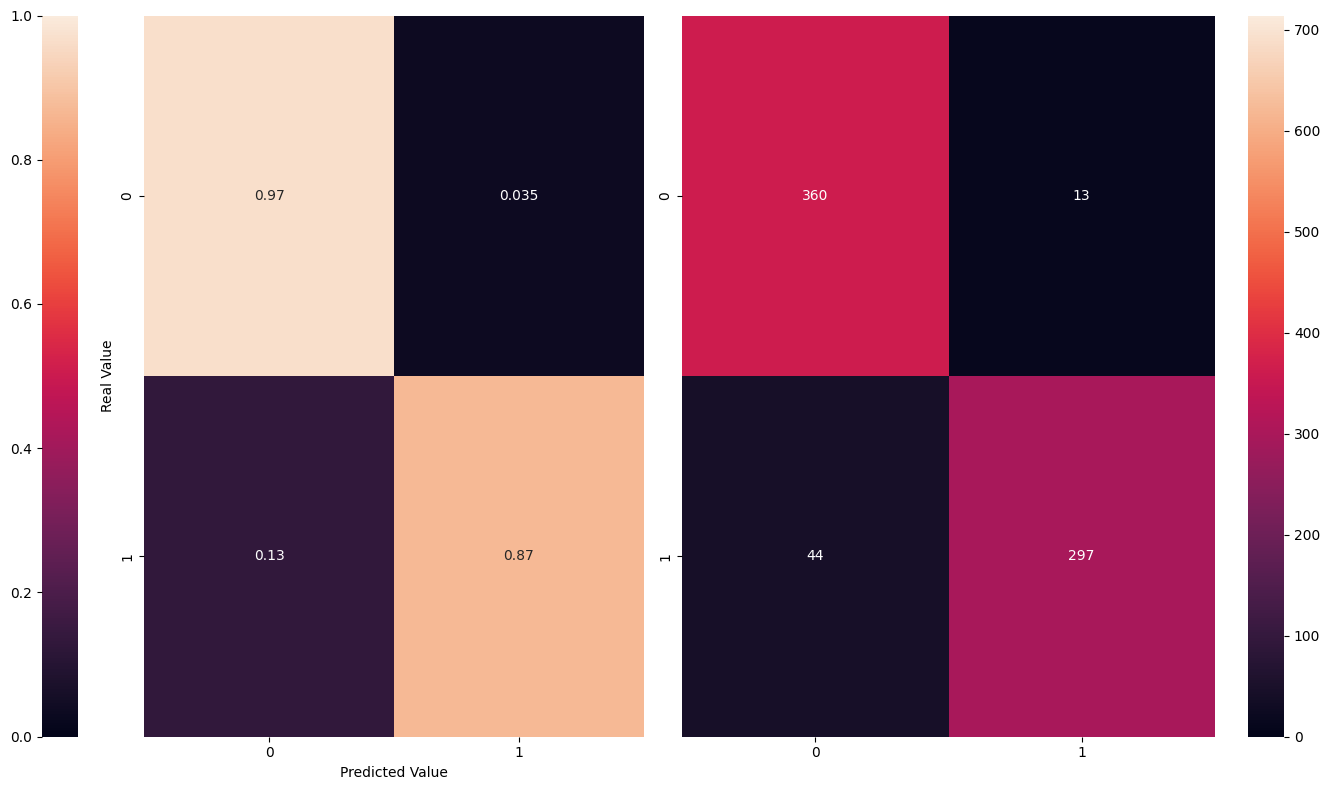

In [ ]:
# @title Confusion Matrix
print(f'Sample Size: {len(y_test)}')
model_matrix(X_test, y_test, best_model)

## Scorecard: Ridge Logistic Regression vs RandomForest
* Swap-IN: RandomForest's ability to predict default over LogisticRegression
* Swap-OUT: visa versa
* Swap-IN-Positive: RandomForest's ability to predict default better than LogisticRegression relative to actual default data
* Swap-IN-Negative: RandomForest's ability to predict non-defaults better than LogisticRegression relative to actual default data
* "Approved by First, Declined by Second":
    * "First" == LogisticRegression
    * "Second" == RandomForest
    * Business impact if deployed
    * RandomForest declines 595 applications approved by LogisticRegression

In [ ]:
print(f'Sample Size: {len(y_smote)}')
scorecard(X_smote, y_smote, best_lr, best_model)

Sample Size: 3566
------------------------------------------------------------------
Swap-IN Size:  1242
Swap-OUT Size: 21
Swap IN / Swap OUT: 59.142857142857146
Swap OUT / Swap IN: 0.016908212560386472
------------------------------------------------------------------
Swap-IN-Positive: 594
Swap-IN-Negative: 648
Swap-OUT-Positive: 20
Swap-OUT-Negative: 1
------------------------------------------------------------------
Approved by Both: 1145
Declined by Both: 1158
Approved by First, Declined By Second: 595
Declined by First, Approved By Second: 668


bad  model1_pred  model2_pred  model_2_swap_in  model_2_swap_out  \
0       0            0            0            False             False   
1       0            0            0            False             False   
2       0            1            0             True             False   
3       0            1            0             True             False   
4       0            0            0            False             False   
...   ...          ...          ...              ...               ...   
3561    1            0            1             True             False   
3562    1            0            1             True             False   
3563    1            0            1             True             False   
3564    1            1            1            False             False   
3565    1            1            1            False             False   

      model_2_swap_in_positive  model_2_swap_in_negative  \
0                        False                     False   
1                        False                     False   
2                        False                      True   
3                        False                      True   
4                        False                     False   
...                        ...                       ...   
3561                      True                     False   
3562                      True                     False   
3563                      True                     False   
3564                     False                     False   
3565                     False                     False   

      model_2_swap_out_positive  model_2_swap_out_negative  approved  \
0                         False                      False      True   
1                         False                      False      True   
2                         False                      False     False   
3                         False                      False     False   
4                         False                      False      True   
...                         ...                        ...       ...   
3561                      False                      False     False   
3562                      False                      False     False   
3563                      False                      False     False   
3564                      False                      False     False   
3565                      False                      False     False   

      declined     AD     DA  
0        False  False  False  
1        False  False  False  
2        False  False   True  
3        False  False   True  
4        False  False  False  
...        ...    ...    ...  
3561     False   True  False  
3562     False   True  False  
3563     False   True  False  
3564      True  False  False  
3565      True  False  False  

[3566 rows x 13 columns]

# Conclusion

Our Exploratory Data Analysis (EDA) proved to be incredibly beneficial. We effectively addressed multicollinearity issues, mitigated potential endogeneity and bias concerns, and enhanced model stability through standardization. The result of our unsupervised learning was clear K-Means clustering that demonstrated the ability to assign consumer credit scores based on the predictive density of defaulting in an assigned cluster.

Among the evaluated supervised learning models, the RandomForest classifier using the SMOTE rebalancing method emerged superior, achieving an impressive 92% accuracy and an exceptional Area Under the Curve (AUC) of 96%. This model's strength lies in its ability to capture complex, non-linear relationships within the data, exploiting the inherent cluster densities observed during the dimensionality reduction process (PCA/MCA) and K-Means clustering results.

In contrast, the Logistic Regression model encountered limitations due to its inherent assumption of linearity, which clearly does not hold true for our dataset from our unsupervised learning observations. This constraint likely hindered its predictive performance, underscoring the importance of selecting the appropriate model that aligns with the data's characteristics.

The comprehensive *Scorecard* evaluation further highlighted the RandomForest model's superiority, outperforming the Logistic Regression by 59x. However, we feel it's important to acknowledge that the RandomForest model did exhibit a slightly elevated false negative rate of 13%. This could be a significant area for improvement given the potential business implications of approving applications that are 13% likley to default.

Future iterations of this project could incorporate additional industry standard models, such as XGBoost, Support Vector Machines, and Neural Networks. This would provide a more comprehensive comparison and potentially uncover alternative modeling approaches better suited to the given dataset. Furthermore, we neglected to evaulate the marginal interpretability of the models fitted coefficients. Futher investigation could yield valuable insights into the relative influence of different predictors on the dependent variable.